In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

np.set_printoptions(precision=3)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
class Agent:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 1

class Agent0:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 0

class Agent1:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 1

class Agent2:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 2

class Agent3:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 3

class Agent4:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 4

In [3]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        # print("ACTIONL", action, "LAPS: ", self.laps_cleared, "PITSTOP", self.pitstop)
        
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

In [4]:
new_car = Car()
env = Track(new_car)

agent = Agent()

In [5]:
state = env.reset()    
done = False
G = 0
while not done:
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward

print("G: %d" % G)

G: -17334


### Race 1

In [6]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
start_state[3] = 900
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward


In [7]:
group1 = Agent()
group2 = Agent()
group3 = Agent()
group4 = Agent()
group5 = Agent()
group6 = Agent()
group7 = Agent()
group8 = Agent()
group9 = Agent()
group10 = Agent()
group11 = Agent()
group12 = Agent()
group13 = Agent()
group14 = Agent()
group15 = Agent()
group16 = Agent()
group17 = Agent()
group18 = Agent()
group19 = Agent()
group20 = Agent()

In [8]:
collect_single_action_results = []

In [9]:
# Race 1
start_weather, radius = start_state[2], start_state[3]
for agent in [group1, group2, group3, group4, group5, group6, group7, group8, group9]:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = radius               # assert common track radius
    done = False
    G = 0
    i = 0
    print(env._get_state())
    while not done:
        env.cur_weather = holder[i]   # assert weather transition
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        # added velocity for sanity check
        state = deepcopy(next_state)
        G += reward
        i += 1
    print("G: %.2f" % G)
    collect_single_action_results.append(G)

['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.87
['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.34
['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.66
['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.93
['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.46
['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.45
['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.63
['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.66
['Intermediate', 1.0, '40% Wet', 900, 0]
G: -16136.62


## Monte Carlo Tree Search - Upper Confidence 

In [10]:
import numpy as np
from collections import defaultdict

In [11]:
# Get all possible car conditions
car_conditions = []
for i in range(0,10000):
  car_conditions.append(round(i/10000, 4))
car_conditions.append(1.0)
print(car_conditions[-1])

1.0


In [12]:
# Get all states - actions for legal moves
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
legal_actions = {}
for tyre in possible_tyres:
  for car_cond in car_conditions:
    for weather in env.possible_weather:
        # legal actions to each state
        legal_actions[(tyre, car_cond, weather)]=[0,1,2,3,4]
print(legal_actions[("Ultrasoft", 1.0, "Dry")])
    

[0, 1, 2, 3, 4]


In [13]:
all_tyre_durability = {}
all_tyre_conditions = []

Durability from Highest Number of Laps to Lowest Number of Laps:
(1200, 'Dry', 'Ultrasoft') 20.563831229170095
(1150, 'Dry', 'Ultrasoft') 19.845847518527904
(1200, '20% Wet', 'Ultrasoft') 19.309062686027673
(1100, 'Dry', 'Ultrasoft') 19.18999437381743
(1150, '20% Wet', 'Ultrasoft') 18.71454467291248
(1050, 'Dry', 'Ultrasoft') 18.595896846321214
(1200, '40% Wet', 'Ultrasoft') 18.24049804060212
(1100, '20% Wet', 'Ultrasoft') 18.12221989772243
(1000, 'Dry', 'Ultrasoft') 18.063138842030042
(1150, '40% Wet', 'Ultrasoft') 17.709050236056175
(1050, '20% Wet', 'Ultrasoft') 17.591228214294038
(950, 'Dry', 'Ultrasoft') 17.53237904729459
(1200, '60% Wet', 'Ultrasoft') 17.29717146327009
(1100, '40% Wet', 'Ultrasoft') 17.238461535010163
(1000, '20% Wet', 'Ultrasoft') 17.121085472342063
(900, 'Dry', 'Ultrasoft') 17.003827314845424
(1150, '60% Wet', 'Ultrasoft') 16.828189068424955
(1050, '40% Wet', 'Ultrasoft') 16.71123816495243
(950, '20% Wet', 'Ultrasoft') 16.65283229934356
(850, 'Dry', 'Ultrasoft'

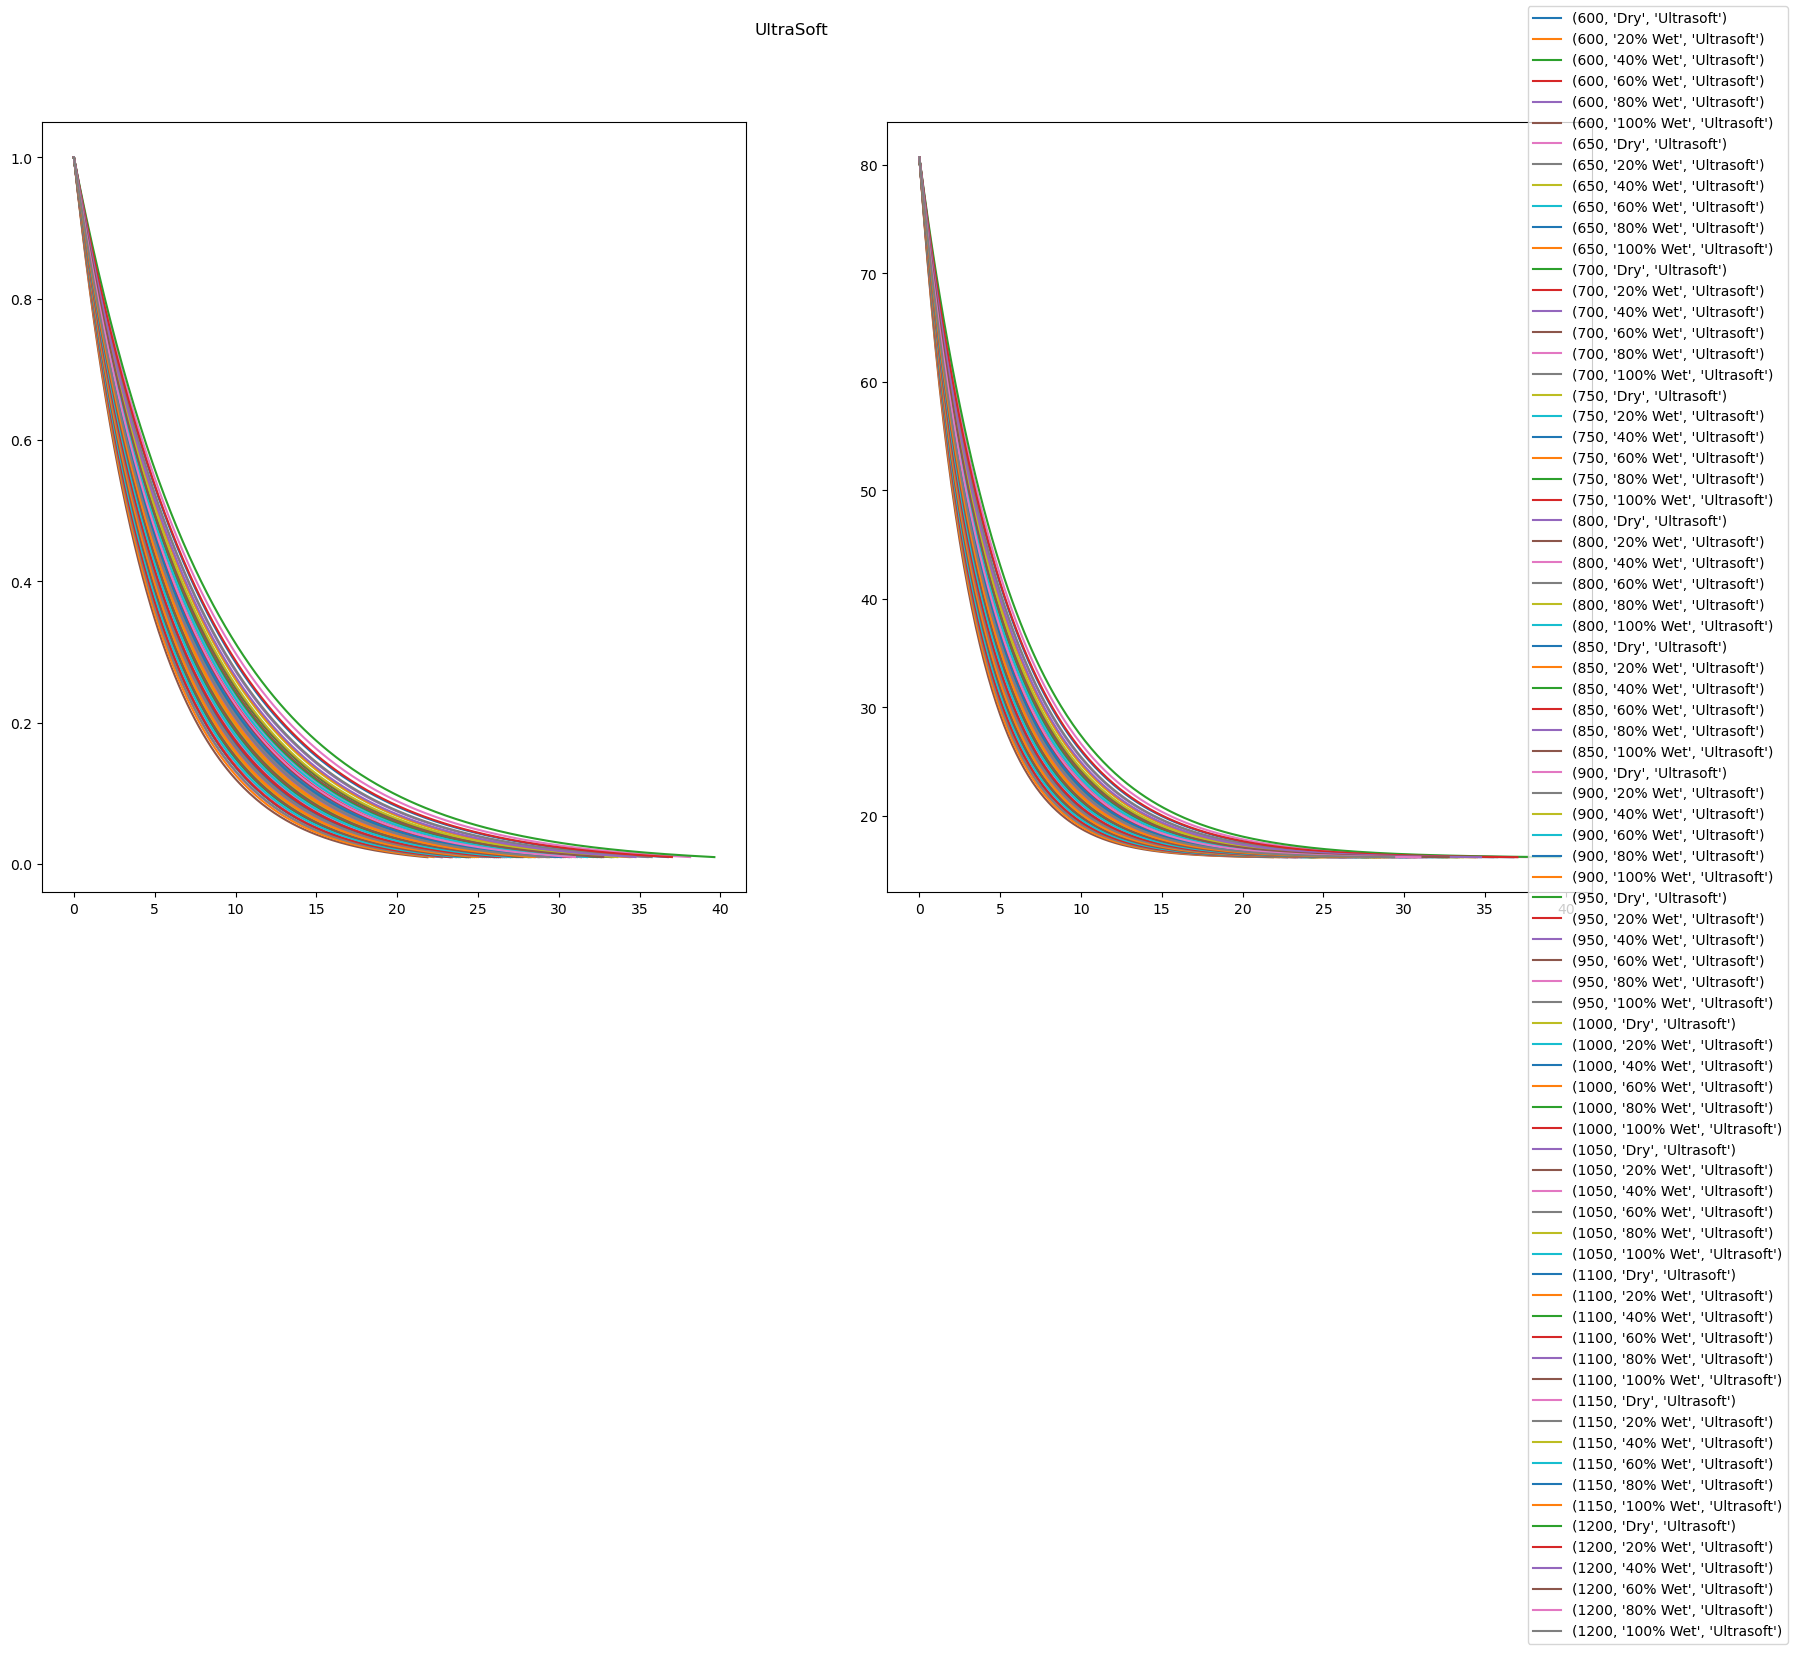

In [14]:
## Compute tire durability
'''
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
self.wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}

To compute tire durability, we first:
- Take each tyre compound and let it run for 162 laps over various 
    - wetness
    - radius : 600m - 1200m

Degradation Function:
def degrade(self, w, r):
    if self.tyre == "Ultrasoft":
        self.condition *= (1 - 0.0050*w - (2500-r)/90000)
    elif self.tyre == "Soft":
        self.condition *= (1 - 0.0051*w - (2500-r)/93000)
    elif self.tyre == "Intermediate":
        self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
    elif self.tyre == "Fullwet":
        self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)

Final Rollout Policy:
The rollout policy that takes advantage of these durabilities works as follows.
When the current tire set has reached its expected duration, the pit stop is 
performed with a probability of 0.9, or the decision is deferred by one lap with a
probability of 0.1. 

The choice of the next compound to use is deterministic: 
if there are any compounds whose durability would cover the remainder of the race, 
the policy suggests fitting the softest one among them. If there is no such
compound, the softest compound available is fitted instead

'''
import matplotlib.pyplot as plt
wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]

# Ultrasoft
legend = []
lap_at_zero_condition = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('UltraSoft')
for r in range(600, 1250, 50):
    for weather in possible_weather:
        condition = 1
        condition_values_ultrasoft = [1]
        
        velocity = 80.7
        velocities = [80.7]
        
        lap_count = 0
        lap = [0]
        w = wetness[weather]
        while lap_count != 162 and condition > 0.005:
            condition *= (1 - 0.0050*w - (2500-r)/90000)
            condition_values_ultrasoft.append(round(condition,8))
            all_tyre_conditions.append(round(condition,8))
            
            velocity = 80.7*(0.2 + 0.8*condition**1.5)
            velocities.append(velocity)
            
            lap_count += 0.125
            lap.append(lap_count)
            if condition < 0.01:
                lap_at_zero_condition[(r,weather, "Ultrasoft")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                all_tyre_durability[(r,weather, "Ultrasoft")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                break
        # create some x data and some integers for the y axis
        x = np.array(lap)
        y = np.array(condition_values_ultrasoft)
        z = np.array(velocities)
        # plot the data
        ax1.plot(x, y)
        ax2.plot(x, z)
        legend.append((r,weather, "Ultrasoft"))
        
fig.legend(legend)

print("Durability from Highest Number of Laps to Lowest Number of Laps:")
list_of_laps = sorted(lap_at_zero_condition, key=lap_at_zero_condition.get, reverse=True)
# print(list_of_laps)

for i in list_of_laps:
    print(i, lap_at_zero_condition[i])  

Durability from Highest Number of Laps to Lowest Number of Laps:
(1200, 'Dry', 'Soft') 21.218196033510914
(1150, 'Dry', 'Soft') 20.437901697550082
(1200, '20% Wet', 'Soft') 19.83955810553273
(1100, 'Dry', 'Soft') 19.77982225253882
(1150, '20% Wet', 'Soft') 19.24303048392042
(1050, 'Dry', 'Soft') 19.183484053664262
(1200, '40% Wet', 'Soft') 18.707845134444508
(1100, '20% Wet', 'Soft') 18.64848651154781
(1000, 'Dry', 'Soft') 18.58914986299824
(1150, '40% Wet', 'Soft') 18.11527053077105
(950, 'Dry', 'Soft') 18.056163832052125
(1050, '20% Wet', 'Soft') 18.056142513923533
(1100, '40% Wet', 'Soft') 17.642983563534646
(1200, '60% Wet', 'Soft') 17.64296220321823
(1000, '20% Wet', 'Soft') 17.584059014534873
(900, 'Dry', 'Soft') 17.525161179391684
(1150, '60% Wet', 'Soft') 17.172368055210836
(950, '20% Wet', 'Soft') 17.11368729732815
(1050, '40% Wet', 'Soft') 17.113665967525876
(850, 'Dry', 'Soft') 17.05501456888361
(1200, '80% Wet', 'Soft') 16.762117558009535
(1000, '40% Wet', 'Soft') 16.703649

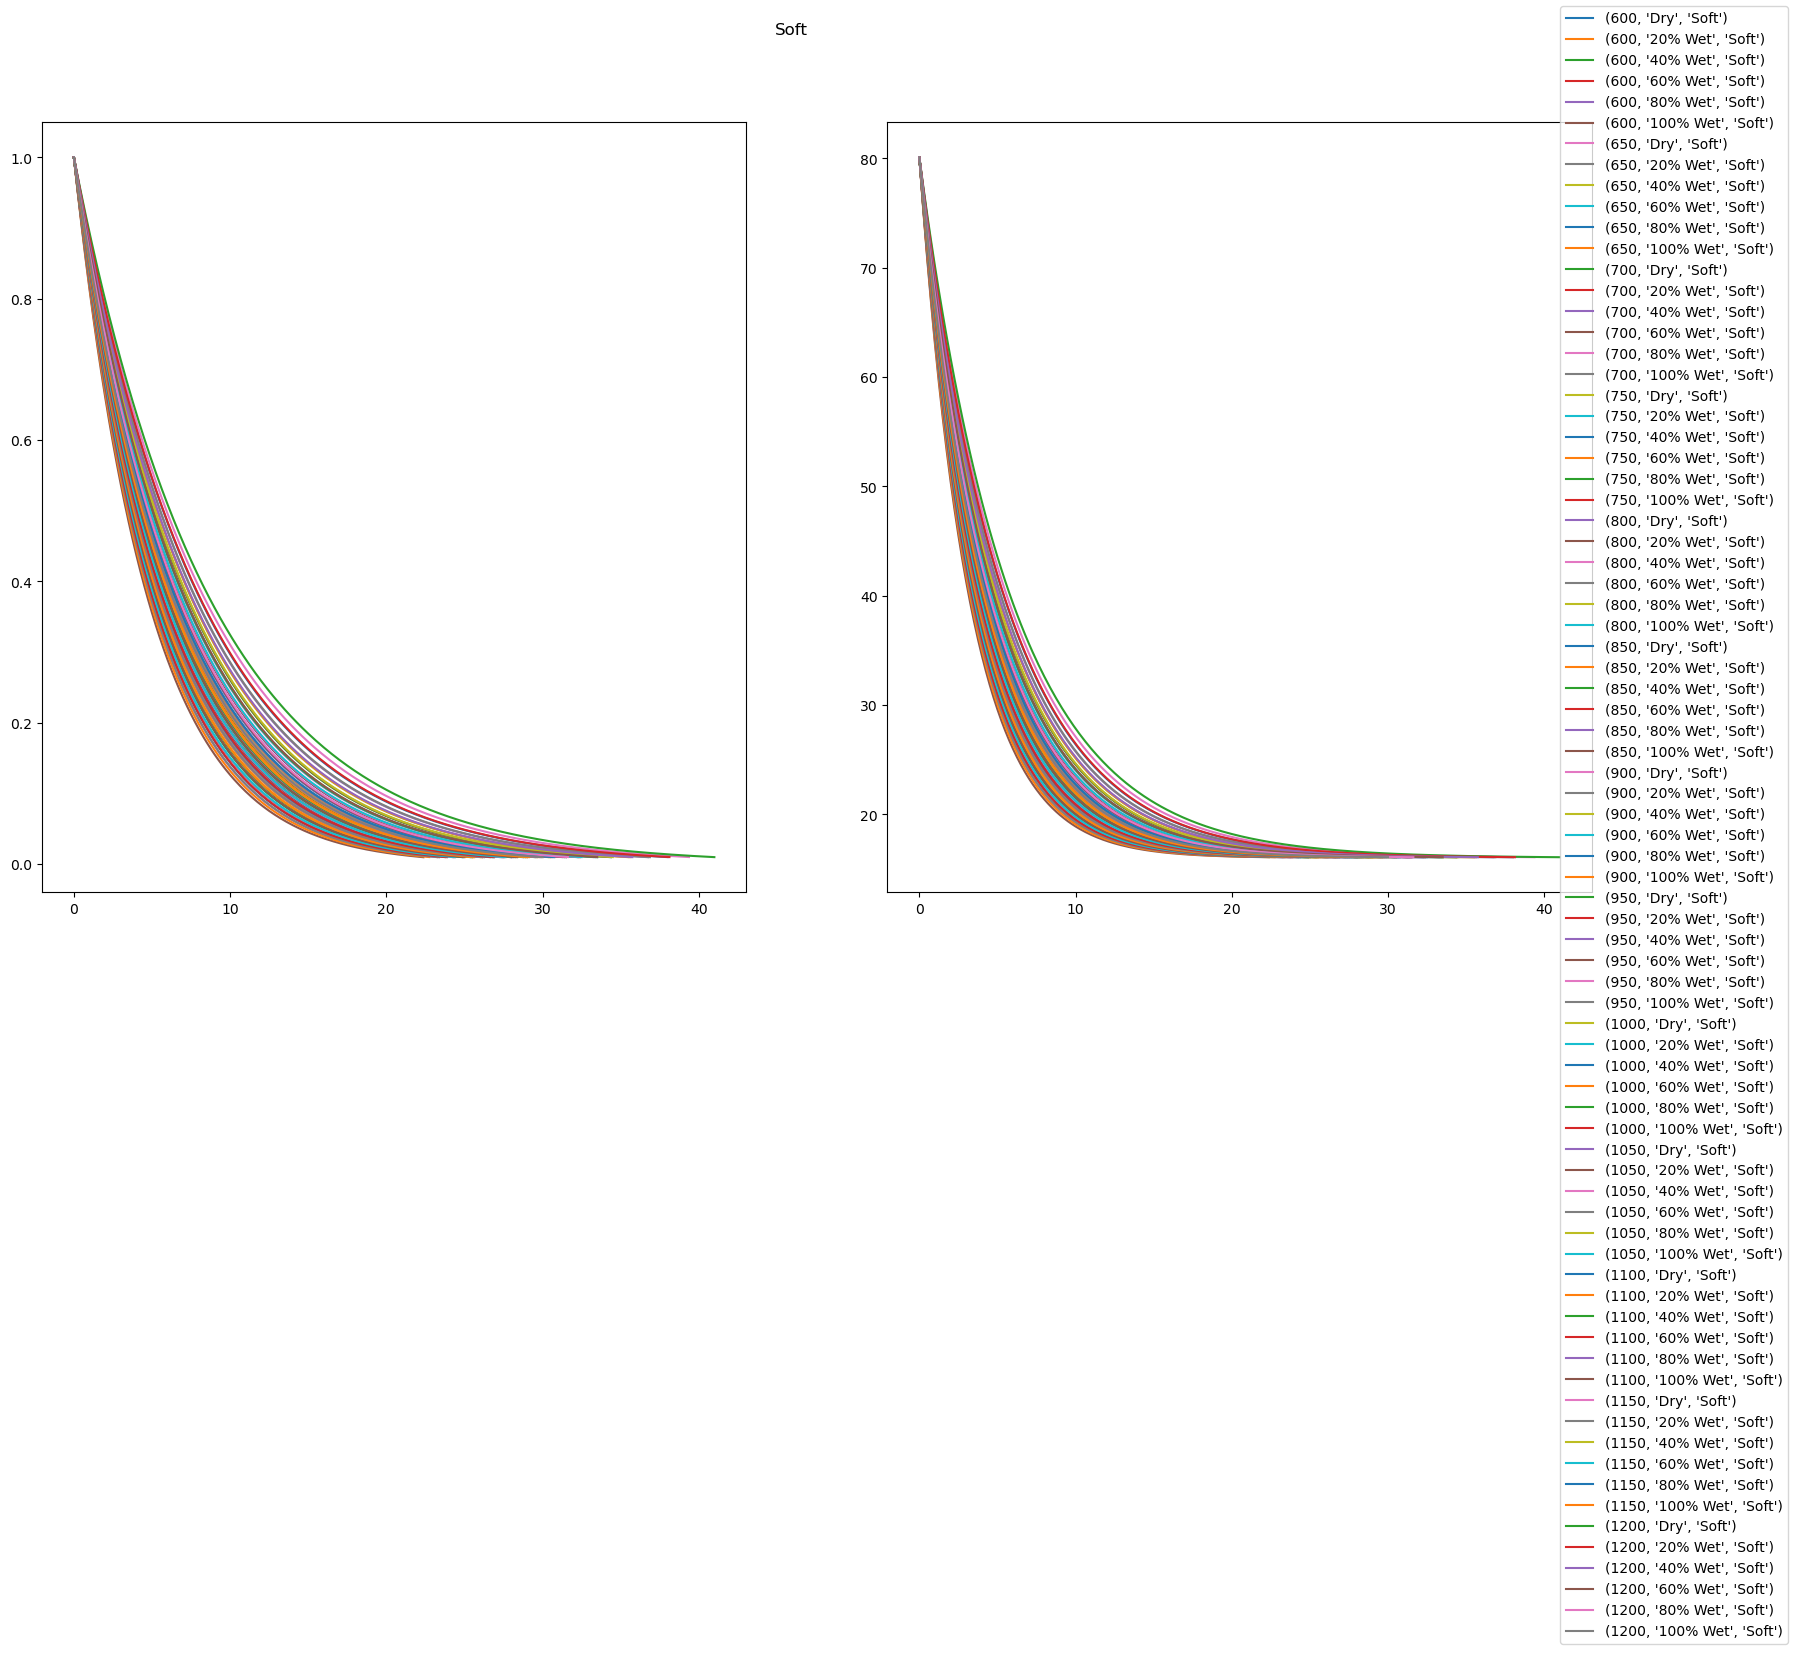

In [15]:
wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]

# soft
legend = []
lap_at_zero_condition = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Soft')
for r in range(600, 1250, 50):
    for weather in possible_weather:
        condition = 1
        condition_values_ultrasoft = [1]
        
        velocity = 80.1
        velocities = [80.1]
        
        lap_count = 0
        lap = [0]
        w = wetness[weather]
        while lap_count != 162 and condition > 0.005:
            condition *= (1 - 0.0051*w - (2500-r)/93000)
            condition_values_ultrasoft.append(round(condition,8))
            all_tyre_conditions.append(round(condition,8))
            
            velocity = 80.1*(0.2 + 0.8*condition**1.5)
            velocities.append(velocity)
            
            lap_count += 0.125
            lap.append(lap_count)
            if condition < 0.01:
                lap_at_zero_condition[(r,weather, "Soft")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                all_tyre_durability[(r,weather, "Soft")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                break
        # create some x data and some integers for the y axis
        x = np.array(lap)
        y = np.array(condition_values_ultrasoft)
        z = np.array(velocities)
        # plot the data
        ax1.plot(x, y)
        ax2.plot(x, z)
        legend.append((r,weather,"Soft"))
        
fig.legend(legend)

print("Durability from Highest Number of Laps to Lowest Number of Laps:")
list_of_laps = sorted(lap_at_zero_condition, key=lap_at_zero_condition.get, reverse=True)
# print(list_of_laps)

for i in list_of_laps:
    print(i, lap_at_zero_condition[i])

Durability from Highest Number of Laps to Lowest Number of Laps:
(1200, '40% Wet', 'Intermediate') 20.851773683205177
(1200, '60% Wet', 'Intermediate') 20.851773683205177
(1150, '40% Wet', 'Intermediate') 20.192200724139802
(1150, '60% Wet', 'Intermediate') 20.192200724139802
(1100, '40% Wet', 'Intermediate') 19.534661055489636
(1100, '60% Wet', 'Intermediate') 19.534661055489636
(1200, '20% Wet', 'Intermediate') 19.53465619889716
(1200, '80% Wet', 'Intermediate') 19.53465619889716
(1050, '40% Wet', 'Intermediate') 18.938875187959745
(1050, '60% Wet', 'Intermediate') 18.938875187959745
(1150, '20% Wet', 'Intermediate') 18.93887033864896
(1150, '80% Wet', 'Intermediate') 18.93887033864896
(1000, '40% Wet', 'Intermediate') 18.40445364755631
(1000, '60% Wet', 'Intermediate') 18.40445364755631
(1100, '20% Wet', 'Intermediate') 18.404448847640744
(1100, '80% Wet', 'Intermediate') 18.404448847640744
(1200, 'Dry', 'Intermediate') 18.404444021737575
(1200, '100% Wet', 'Intermediate') 18.404444

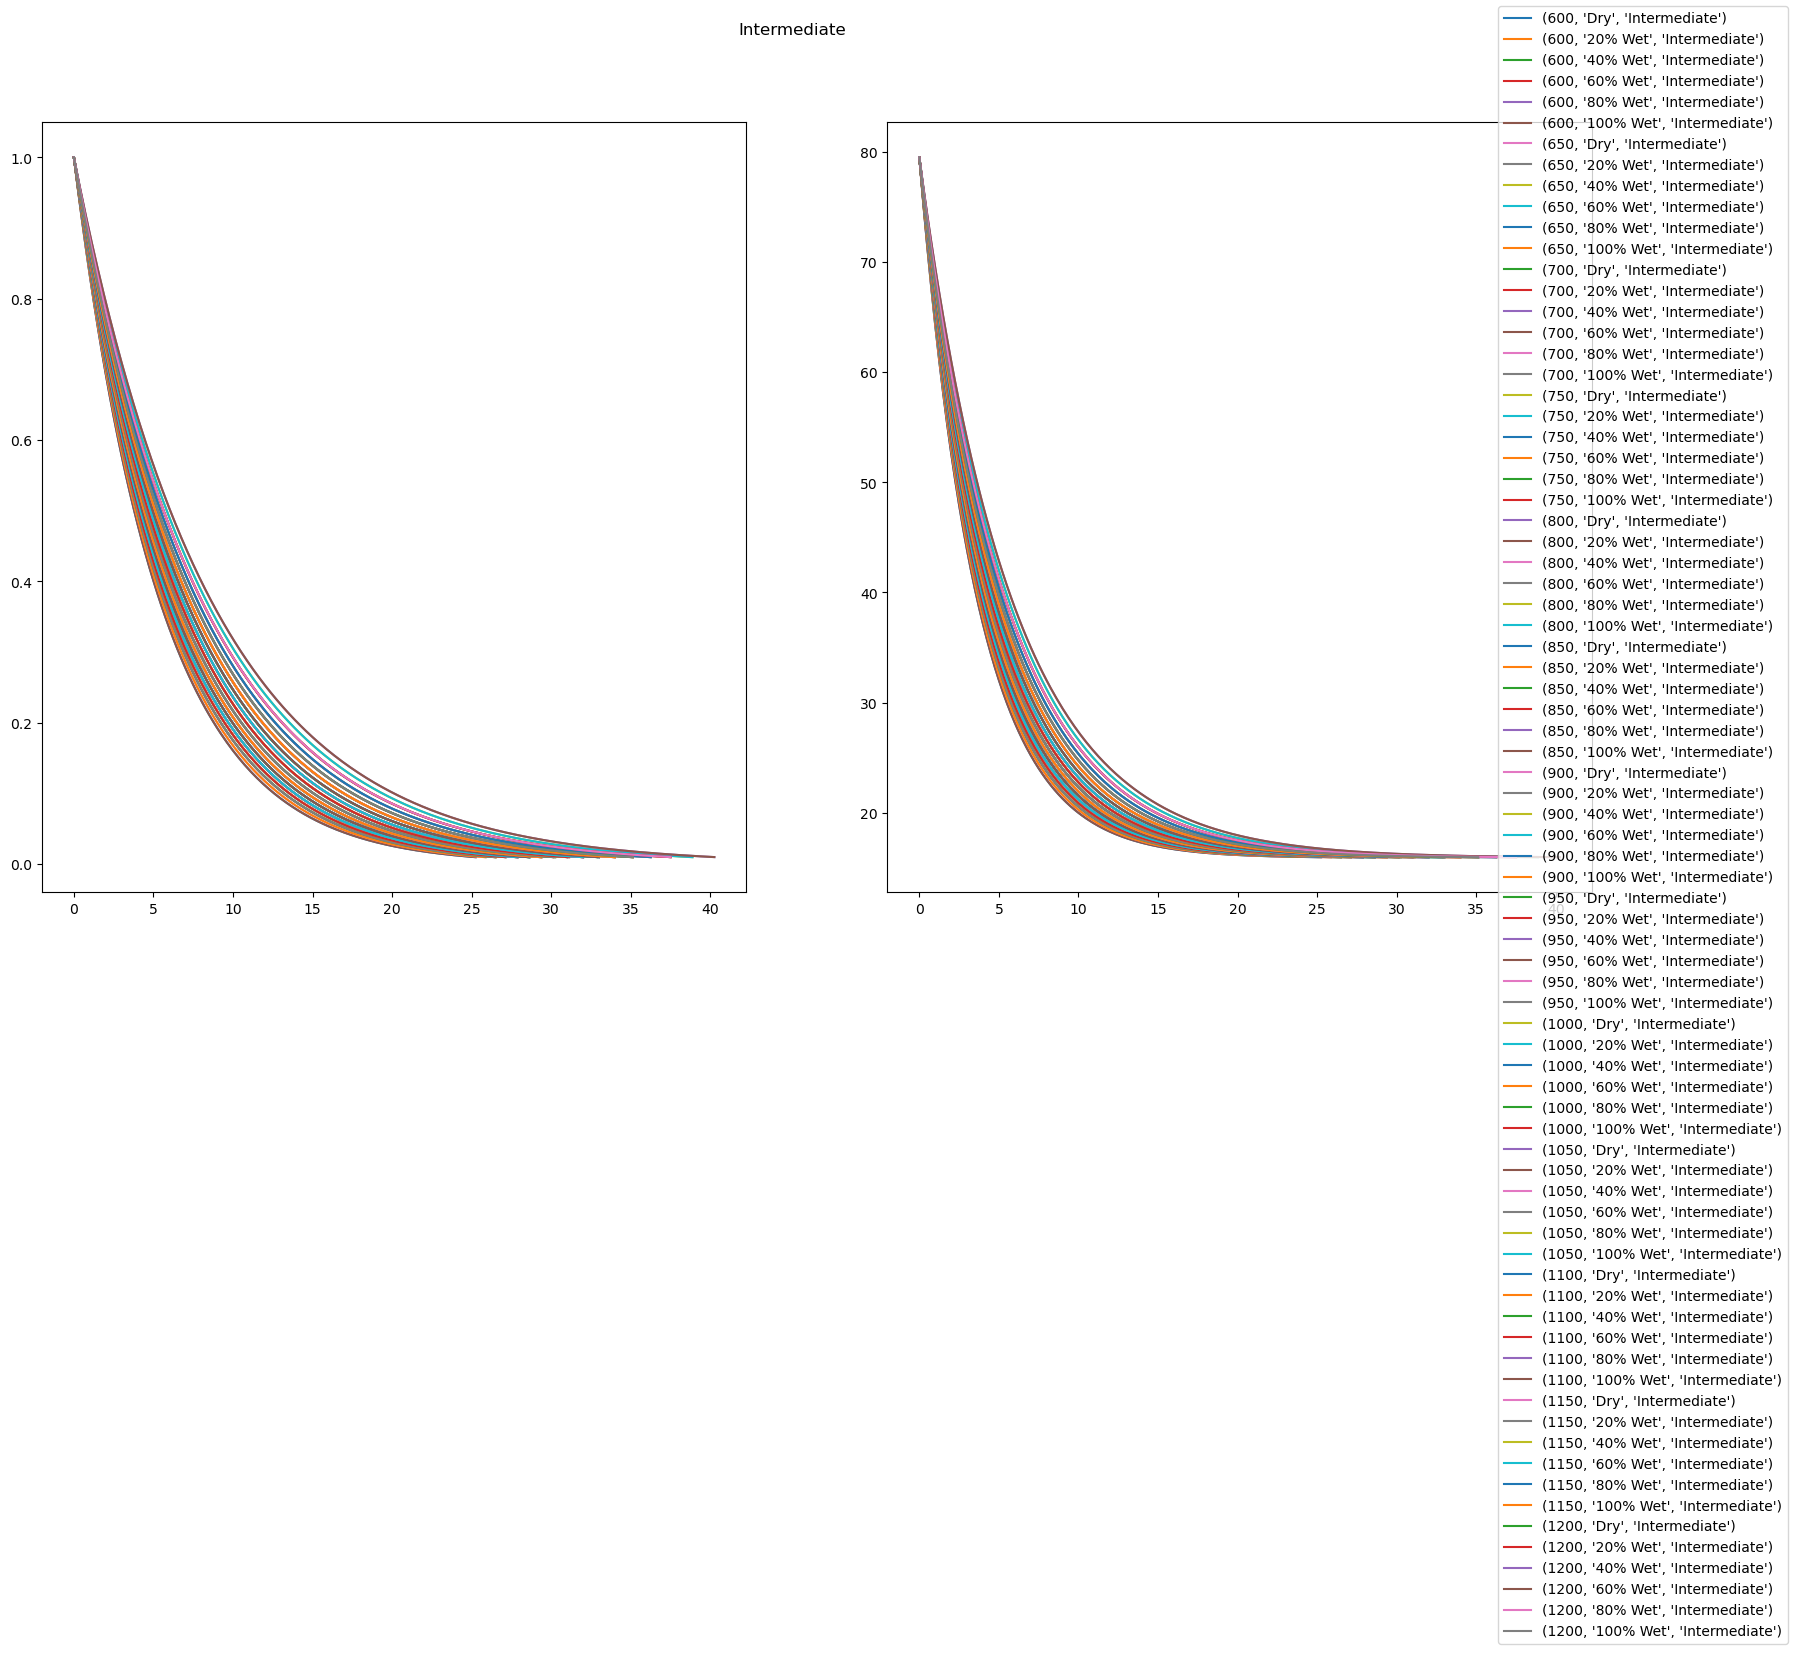

In [16]:
wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]

# intermediate
legend = []
lap_at_zero_condition = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Intermediate')
for r in range(600, 1250, 50):
    for weather in possible_weather:
        condition = 1
        condition_values_ultrasoft = [1]
        
        velocity = 79.5
        velocities = [79.5]
        
        lap_count = 0
        lap = [0]
        w = wetness[weather]
        while lap_count != 162 and condition > 0.005:
            condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
            condition_values_ultrasoft.append(round(condition,8))
            all_tyre_conditions.append(round(condition,8))
            
            velocity = 79.5*(0.2 + 0.8*condition**1.5)
            velocities.append(velocity)
            
            lap_count += 0.125
            lap.append(lap_count)
            if condition < 0.01:
                lap_at_zero_condition[(r,weather, "Intermediate")] =0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                all_tyre_durability[(r,weather, "Intermediate")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                break
        # create some x data and some integers for the y axis
        x = np.array(lap)
        y = np.array(condition_values_ultrasoft)
        z = np.array(velocities)
        # plot the data
        ax1.plot(x, y)
        ax2.plot(x, z)
        legend.append((r,weather, "Intermediate"))
        
fig.legend(legend)

print("Durability from Highest Number of Laps to Lowest Number of Laps:")
list_of_laps = sorted(lap_at_zero_condition, key=lap_at_zero_condition.get, reverse=True)
# print(list_of_laps)

for i in list_of_laps:
    print(i, lap_at_zero_condition[i])  

Durability from Highest Number of Laps to Lowest Number of Laps:
(1200, '100% Wet', 'FullWet') 22.05095237410584
(1150, '100% Wet', 'FullWet') 21.267627390716008
(1200, '80% Wet', 'FullWet') 20.54669400287321
(1100, '100% Wet', 'FullWet') 20.54668295212111
(1150, '80% Wet', 'FullWet') 19.887833140354747
(1050, '100% Wet', 'FullWet') 19.88782208389371
(1000, '100% Wet', 'FullWet') 19.290710073719108
(1200, '60% Wet', 'FullWet') 19.2311046424955
(1100, '80% Wet', 'FullWet') 19.231093534808398
(1050, '80% Wet', 'FullWet') 18.69554570645693
(950, '100% Wet', 'FullWet') 18.69553460449595
(1150, '60% Wet', 'FullWet') 18.636133942653892
(1000, '80% Wet', 'FullWet') 18.16173659101864
(900, '100% Wet', 'FullWet') 18.161725483801693
(1200, '40% Wet', 'FullWet') 18.1025395188698
(1100, '60% Wet', 'FullWet') 18.102528405505634
(850, '100% Wet', 'FullWet') 17.688851121336995
(1150, '40% Wet', 'FullWet') 17.62986348331197
(1050, '60% Wet', 'FullWet') 17.62985247792046
(950, '80% Wet', 'FullWet') 17.

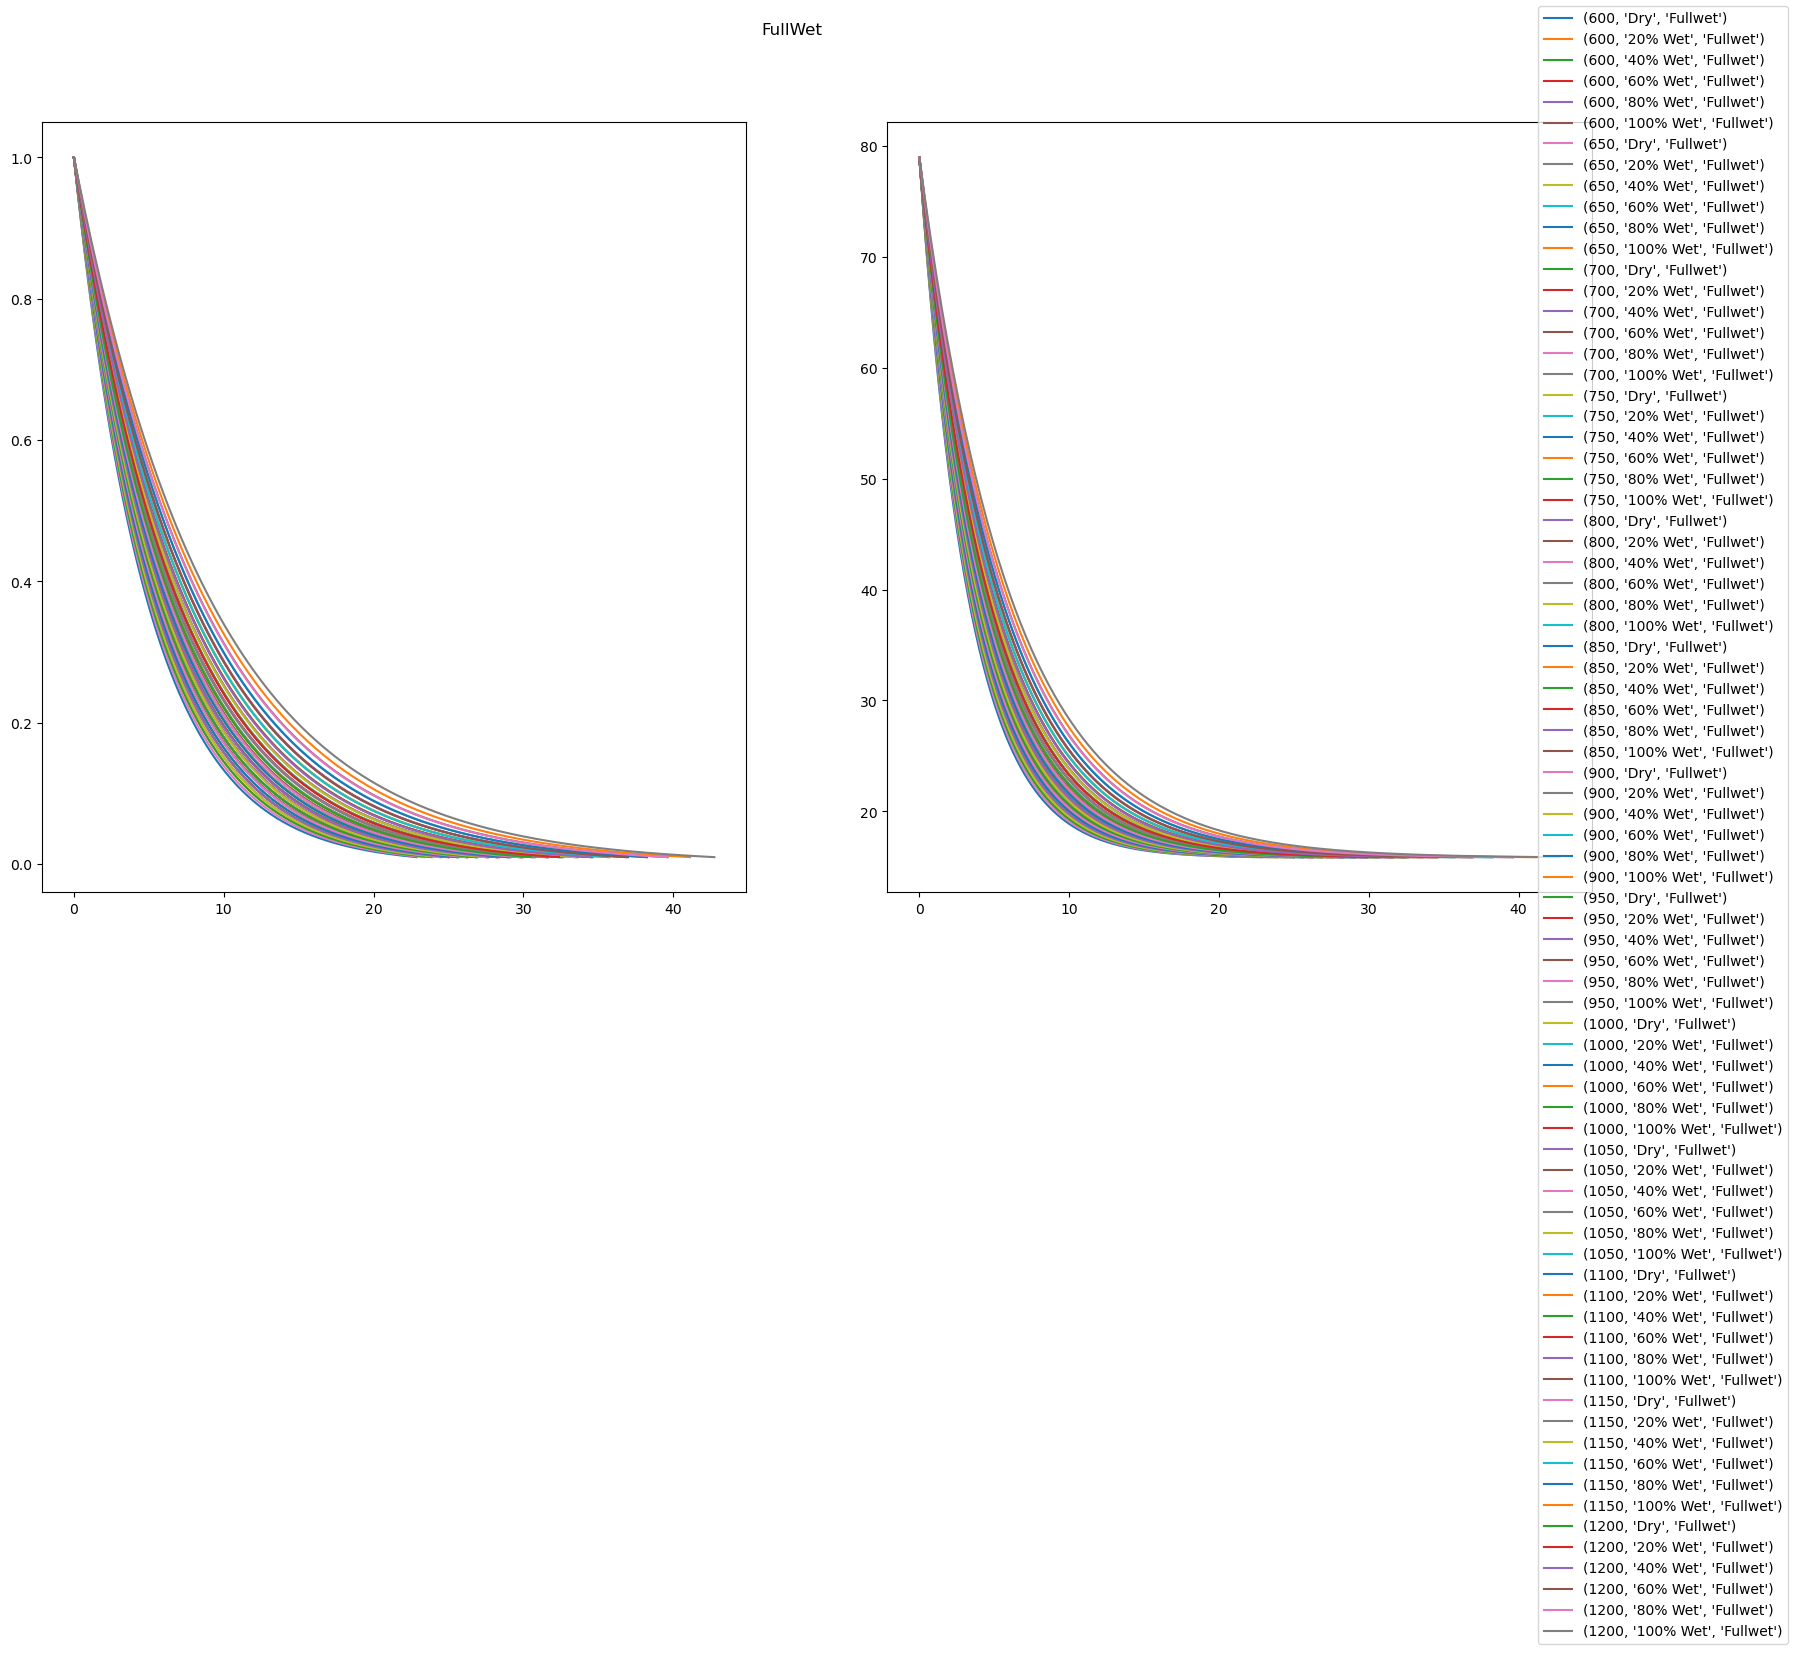

In [17]:
wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]

# fullwet
legend = []
lap_at_zero_condition = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('FullWet')
for r in range(600, 1250, 50):
    for weather in possible_weather:
        condition = 1
        condition_values_ultrasoft = [1]
        
        velocity = 79.0
        velocities = [79.0]
        
        lap_count = 0
        lap = [0]
        w = wetness[weather]
        while lap_count != 162 and condition > 0.005:
            condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
            condition_values_ultrasoft.append(round(condition,8))
            all_tyre_conditions.append(round(condition,8))
            
            velocity = 79.0*(0.2 + 0.8*condition**1.5)
            velocities.append(velocity)
            
            lap_count += 0.125
            lap.append(lap_count)
            if condition < 0.01:
                lap_at_zero_condition[(r,weather, "FullWet")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                all_tyre_durability[(r,weather, "FullWet")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                break
        # create some x data and some integers for the y axis
        x = np.array(lap)
        y = np.array(condition_values_ultrasoft)
        z = np.array(velocities)
        # plot the data
        ax1.plot(x, y)
        ax2.plot(x, z)
        legend.append((r,weather, "Fullwet"))
        
fig.legend(legend)

print("Durability from Highest Number of Laps to Lowest Number of Laps:")
list_of_laps = sorted(lap_at_zero_condition, key=lap_at_zero_condition.get, reverse=True)
# print(list_of_laps)

for i in list_of_laps:
    print(i, lap_at_zero_condition[i]) 

In [18]:
list_of_laps = sorted(all_tyre_durability, key=all_tyre_durability.get, reverse=True)
# print(list_of_laps)

final_dict_tyre = {}
for i in list_of_laps:
    print(i, all_tyre_durability[i])
    final_dict_tyre[i] = all_tyre_durability[i]

(1200, '100% Wet', 'FullWet') 22.05095237410584
(1150, '100% Wet', 'FullWet') 21.267627390716008
(1200, 'Dry', 'Soft') 21.218196033510914
(1200, '40% Wet', 'Intermediate') 20.851773683205177
(1200, '60% Wet', 'Intermediate') 20.851773683205177
(1200, 'Dry', 'Ultrasoft') 20.563831229170095
(1200, '80% Wet', 'FullWet') 20.54669400287321
(1100, '100% Wet', 'FullWet') 20.54668295212111
(1150, 'Dry', 'Soft') 20.437901697550082
(1150, '40% Wet', 'Intermediate') 20.192200724139802
(1150, '60% Wet', 'Intermediate') 20.192200724139802
(1150, '80% Wet', 'FullWet') 19.887833140354747
(1050, '100% Wet', 'FullWet') 19.88782208389371
(1150, 'Dry', 'Ultrasoft') 19.845847518527904
(1200, '20% Wet', 'Soft') 19.83955810553273
(1100, 'Dry', 'Soft') 19.77982225253882
(1100, '40% Wet', 'Intermediate') 19.534661055489636
(1100, '60% Wet', 'Intermediate') 19.534661055489636
(1200, '20% Wet', 'Intermediate') 19.53465619889716
(1200, '80% Wet', 'Intermediate') 19.53465619889716
(1200, '20% Wet', 'Ultrasoft') 1

## MODIFIED VERSION 2

In [19]:
class MonteCarloTreeSearchNodeMod():
  def __init__(self, Env, state, parent=None, parent_action=None, reward=0, q_value=0, prev_action=None, timesteps=0):
    #node 
    self.parent = parent
    self.parent_action = parent_action
    self.reward = reward
    self.q_value = q_value
    self.children = []
    self.timesteps = timesteps
    
    #actions
    self.legal_actions = [0,1,2,3,4]
    
    #state
    self.state = state
    
    #environment factors
    self.env = Env
    self.env.car.tyre = state[0]
    self.env.car.condition = state[1]
    self.env.cur_weather = state[2]
    self.env.radius = state[-2]
    self.env.is_done =state[-1] == 162
    self.env.laps_cleared = state[-1]
    
    self.original_pitstop = Env.pitstop
    
    #keep track of previous actions and current pitstop
    self.prev_action = prev_action
    self.current_pitstop = self.env.pitstop
    
    # params
    self.discount_rate = 0.90
    self.lr = 0.1
    
    #to account for radius, we have to weigh future q value vs instant rewards
    # i.e. 0.2*i.q_value + 0.8*i.reward
    # self.weight_future_q = 0.75
    # self.weight_future_q = 0.5
    self.weight_future_q = ((1-(state[-2]-600)/600)) #for shorter races, we want fewer pitstops, so we look more at future rewards
    if self.weight_future_q <= 0.25:
      self.weight_future_q = 0.15
    elif self.weight_future_q > 0.25 and self.weight_future_q <= 0.75:
      self.weight_future_q = 0.35
    
  def best_action(self):
    # at 3/4 mark, run simulations
    if self.state[-1] - int(self.state[-1]) == 0.75:
      simulation_no = 5
      for i in range(simulation_no):
        # tree policy gets all unexplored states first
        # After exploring all states, it explores with a decaying epsilon the same states again with different paths
        # updates the 4 action Q values
        v = self.tree_policy()
        
        #once we have a child node
        cum_discounted_rewards = v.rollout()
        
        # after getting cum discounted rewards, we backpropagate to store results
        v.backpropagate(cum_discounted_rewards)
        
        #reset for next step
        self.env.car.tyre = self.state[0]
        self.env.car.condition = self.state[1]
        self.env.cur_weather = self.state[2]
        self.env.radius = self.state[-2]
        self.env.is_done = False
        self.env.laps_cleared = self.state[-1]
      
      self.env.pitstop = self.original_pitstop
      result = self.overall_best_child()
      
      # for i in self.children:
      #   print("CHILD:", i.q_value, i.state, i.reward, i.timesteps, (self.weight_future_q)*i.q_value + (1-self.weight_future_q)*i.reward)

      return result
    else:
      #if original pitstop is false, means no change in action
      if self.current_pitstop == False or self.prev_action == None:
        return 4 #action 4 = do nothing
      
      #if original pitstop is True
      if self.current_pitstop:
        return self.prev_action
      
  def tree_policy(self):
    current_node = self
    
    #terminal node = lap 162
    while not current_node.is_terminal_node():
      
      # explore the unexplored actions
      if not current_node.is_fully_expanded():
        return current_node.expand()
      else:
        # with epsilon decay, try to explore new states
        return current_node.best_child()

  def is_terminal_node(self):
    if self.state[-1] == 162:
      return True
    return False
  
  def is_fully_expanded(self):
    return len(self.legal_actions) == 0  

  def expand(self):
    action = self.legal_actions.pop()
    
    # do a look ahead for the next x num of laps and stick to one action
    lookahead_laps = 1/8
    
    #compute q value for lookahead
    done = False
    total_rewards= 0
    for i in range(int(lookahead_laps*8)): #10 * 8 since each lap has 8 parts
      if done:
        break
      else:
        reward, next_state, done, velocity = self.env.transition(action)
        total_rewards += reward
    
    # we want to simulate our next state to be a varied tyre choice
    next_state[-1] = self.state[-1] + 0.125
    
    # add child nodes to current state
    child_node = MonteCarloTreeSearchNodeMod(Env=self.env, state=next_state, parent=self, parent_action=action,
                                             reward=total_rewards, q_value=0)
    self.children.append(child_node)
    return child_node  
  
  # after expanding an unexplored action, we rollout to terminal state
  def rollout(self):
    current_rollout_state = self.state  
    
    # get a list of rewards
    reward_list = []
    while not current_rollout_state[-1] == 162:
      action = self.rollout_policy(current_rollout_state)
      reward, current_rollout_state, done, velocity = self.env.transition(action)
      reward_list.append(reward)
    
    # discount from terminal node
    reward_list = reward_list[::-1]
    # print("TOTAL rewards", sum(reward_list), len(reward_list), self.parent_action, current_rollout_state)
    discounted_rewards_all_other_states = 0
    for r in reward_list:
      # generate all discounted rewards
      discounted_rewards_all_other_states = self.discount_rate * discounted_rewards_all_other_states + r

    # print(self.state, self.reward, discounted_rewards_all_other_states)
    # add the current rewards from change
    discounted_rewards_all_other_states += self.reward

    # we need to reset the pitstop to False at this stage before we actually play the moves
    self.env.pitstop = False
    self.q_value = (self.q_value*self.timesteps + discounted_rewards_all_other_states)/(self.timesteps+1)
    return discounted_rewards_all_other_states
  
  # rollout policy depends on durability and rate of loss in velocity and picks the next set of tyres based on that
  def rollout_policy(self, curr_state):
    '''
    If durability condition 
    '''
    speed_tyre = {"Ultrasoft": 80.7, "Soft": 80.1, "Intermediate": 79.5, "Fullwet": 79.0}
    conservative_velocity = speed_tyre[curr_state[0]]*(0.2 + 0.8*curr_state[1]**1.5)
    
    #favourable weather for specific tyre
    fav_weather_tyre = {
      "Ultrasoft": ["Dry", "20% Wet"],
      "Soft": ["20% Wet"],
      "Intermediate": ["40% Wet", "60% Wet", "80% Wet"],
      "Fullwet": ["80% Wet", "100% Wet"]
    }
    
    # curr_time_taken_per_lap = (2*np.pi*curr_state[-2] / conservative_velocity)
    curr_time_taken_per_lap = (curr_state[-2] / conservative_velocity)
    
    # time taken per lap is more than 14 or car condition is less than 0.3
    if curr_time_taken_per_lap > (1.5* 23): # or curr_state[1]< 0.05:
      epsilon_for_change = random.random()
      nearest_fifty_radius = 50 * round(curr_state[-2]/50)
      
      # #create function to adjust probability for change to account for radius
      # # larger radius should have larger probability of change as next change is much longer later
      # # account for how long is one round, 
      # # if one round gets closer to 1.5 times of pitstop time, do change
      # epsilon_threshold = radius_to_probability_change[nearest_fifty_radius]
      # max_epsilon_threshold = 0.9999
      curr_threshold = 0.5
      
      #if favourable weather for specific tyre set, reduce possibility of change
      if curr_state[2] in fav_weather_tyre[curr_state[0]]:
        # if radius is larger, change tyre with higher probability even if tyre i favourbale
        curr_threshold -= (0.45 * (1-(curr_state[-2]-600)/600))
      else:
        #if weather is unfavourable, increase probability to change tyre
        # if radius is smaller, let the tyre run a little longer
        curr_threshold += (0.45 * ((curr_state[-2]/600)-1))
      
      # if epsilon_for_change <= 0.999:
      if epsilon_for_change <= curr_threshold:
        
        filtered_durability = {
          (nearest_fifty_radius, curr_state[2], "Ultrasoft"): final_dict_tyre[(nearest_fifty_radius, curr_state[2], "Ultrasoft")],
          (nearest_fifty_radius, curr_state[2], "Soft"): final_dict_tyre[(nearest_fifty_radius, curr_state[2], "Soft")],
          (nearest_fifty_radius, curr_state[2], "Intermediate"): final_dict_tyre[(nearest_fifty_radius, curr_state[2], "Intermediate")],
          (nearest_fifty_radius, curr_state[2], "FullWet"): final_dict_tyre[(nearest_fifty_radius, curr_state[2], "FullWet")]
        }
        highest_durability = sorted(filtered_durability, key=filtered_durability.get, reverse=True)
        if highest_durability[0][-1] == "Ultrasoft":
          return 0
        elif highest_durability[0][-1] == "Soft":
          return 1
        elif highest_durability[0][-1] == "Intermediate":
          return 2
        elif highest_durability[0][-1] == "FullWet":
          return 3
      else:
        return 4
    else:
      # do not change
      return 4
    
  def backpropagate(self, cum_discounted_rewards):
    parent = self.parent
    self.timesteps += 1
    
    while self.parent is not None:
      # all are leaf nodes since we only expand one level down
      parent.q_value = parent.q_value + self.lr * (parent.reward + self.discount_rate * cum_discounted_rewards - parent.q_value)
      parent.timesteps+=1
      self = parent
      parent = self.parent
      
  def best_child(self):
    # instead of using UCB, we use epsilon with decaying factor to generate more samples
    choices_weights = [c.q_value for c in self.children]
    get_random = random.randint(0,len(choices_weights)-1)
    #epsilon greedy with decay
    if random.random() <= max(0.5, (self.state[-1])/162):
      return self.children[np.argmax(choices_weights)]
    else:
      return self.children[get_random]
    
  def overall_best_child(self):
    # if 3/4 mark is reached, able to change action based on argmax
    choices_weights = [ (self.weight_future_q)*c.q_value + (1-self.weight_future_q)*c.reward for c in self.children]
    # print(choices_weights)
    return int(4-np.argmax(choices_weights))
    
    

## CRUCIAL FUNCTION TO RUN THE ALGO

In [20]:
def q_learning_open_loop_planning(input_state, prev_action):
  root = MonteCarloTreeSearchNodeMod(Env= env, state = input_state, prev_action=prev_action)
  selected_node = root.best_action()
  return selected_node

## GENERATE EVALUATION SEQUENCES

In [21]:
# radiuses = [600,700,800,900,1000,1100,1200]
# possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
# num_start_states = 20
# saved_dict = {} # radius: {start_state: weather_seq}

# for rad in radiuses:
#   weather_to_holder = {}
#   for weather in possible_weather: 
#     new_car = Car()
#     env = Track(new_car)
#     agent = Agent()
#     # Store historical weather
#     holder = []
#     env.reset()
#     env.cur_weather = weather
#     env.radius = rad
#     state = env._get_state()
#     start_state = deepcopy(state)
#     done = False
#     G = 0
#     while not done:
#       holder.append(env.cur_weather)
#       action = agent.act(state)
#       reward, next_state, done, velocity = env.transition(action)
#       # added velocity for sanity check
#       state = deepcopy(next_state)
#       G += reward
    
#     weather_to_holder[str((start_state[0], start_state[1], start_state[2], start_state[3], start_state[4]))] = holder
#   saved_dict[rad] = weather_to_holder

In [22]:
# import json  
# # Serializing json   
# with open("evaluation.json", "w") as outfile: 
#     json.dump(saved_dict, outfile)

## LOAD FROM EVALUATION

In [23]:
# import json
# # LOAD JSON
# f = open('evaluation.json', "r")
# # Reading from file
# data = json.loads(f.read())

# #save dict of results
# results_dict = {}

# # SINGLE ACTION
# for radius_key, v1 in data.items():
#     # save start_state_exp to time
#     exp_state_time = {}
    
#     for start_state_key, weather_seq in v1.items():
#         #convert string tuple to tuple
#         start_state_key = start_state_key.replace("(", "")
#         start_state_key = start_state_key.replace(")", "")
#         start_state_key = start_state_key.split(",")
#         start_state_key[0] = start_state_key[0].replace("'", "")
#         start_state_key[2] = start_state_key[2].replace("'", "").lstrip()

#         print(start_state_key)
#         #set start weather and radius
#         start_weather, radius = str(start_state_key[2]), int(start_state_key[3])
        
#         #average time
#         return_collection_single_act = []
        
#         # single action algorithm
#         for agent in [group1, group2]:
#             state = env.reset() 
#             env.cur_weather = start_weather   # assert common start weather
#             env.radius = radius               # assert common track radius
#             done = False
#             G = 0
#             i = 0
#             while not done:
#                 env.cur_weather = str(weather_seq[i])   # assert weather transition
#                 action = agent.act(state)
#                 reward, next_state, done, velocity = env.transition(action)
#                 # added velocity for sanity check
#                 state = deepcopy(next_state)
#                 G += reward
#                 i += 1
#             print("Single Action G: %.2f" % G)
#             return_collection_single_act.append(G)
        
#         avg_one_act_returns = sum(return_collection_single_act)/len(return_collection_single_act)
        
#         #stringify tuple to save to json
#         exp_state_time[str((str(start_state_key[0]), float(start_state_key[1]), 
#                         str(start_state_key[2]), int(start_state_key[3]), 
#                         float(start_state_key[4])))] =  {"SingleAction": avg_one_act_returns}
        
        
#         #average time
#         return_collection_mcts = []
        
#         # Monte Carlo Tree Search
#         for agent in [group1, group2, group3, group4, group5]:
#         # for agent in [group1, group2, group3, group4, group5, group6, group7, group8, group9, group10]:
#             state = env.reset() 
#             env.cur_weather = start_weather   # assert common start weather
#             env.radius = radius               # assert common track radius
#             done = False
#             G = 0
#             i = 0
            
#             input_state = env._get_state()
#             action = 4
#             while not done:
#                 env.cur_weather = str(weather_seq[i])   # assert weather transition
#                 action = q_learning_open_loop_planning(input_state=input_state, prev_action=action)
#                 reward, next_state, done, velocity = env.transition(action)
                
#                 # print("FINALLLL:", next_state, velocity, "action is: ", action,  "  Total returns: ", G, reward)
#                 input_state = deepcopy(next_state)
#                 G += reward
#                 i += 1
#             print("MCTS G: %.2f" % G)
#             return_collection_mcts.append(G)
        
#         avg_mcts_returns = sum(return_collection_mcts)/len(return_collection_mcts)
#         exp_state_time[str((start_state_key[0], float(start_state_key[1]), 
#                         start_state_key[2], int(start_state_key[3]), 
#                         float(start_state_key[4])))]["MonteCarloTreeSearch"] =  avg_mcts_returns
        
#         exp_state_time[str((start_state_key[0], float(start_state_key[1]), 
#                         start_state_key[2], int(start_state_key[3]), 
#                         float(start_state_key[4])))]["Difference"] = avg_one_act_returns - avg_mcts_returns
         
#         exp_state_time[str((start_state_key[0], float(start_state_key[1]), 
#                 start_state_key[2], int(start_state_key[3]), 
#                 float(start_state_key[4])))]["PercentImprovement"] = 1 - avg_mcts_returns/avg_one_act_returns

#         print("Comparison:")
#         print(f"Avg Single Action Return: {avg_one_act_returns} ||||||| Avg MCTS Return: {avg_mcts_returns}")
#         print(f"Improvement by MCTS: {avg_one_act_returns - avg_mcts_returns} ||||||||| % Improvement: {1 - avg_mcts_returns/avg_one_act_returns}\n")
        
#     results_dict[radius_key] = exp_state_time

In [24]:
# with open("evaluation_results_mcts_q_learn.json", "w") as outfile: 
#     json.dump(results_dict, outfile, indent=4)

## VISUALIZE RESULTS

In [25]:
# import pandas as pd
# import json
# # LOAD JSON
# f = open('evaluation_results_mcts_q_learn.json', "r")
# # Reading from file
# eval_data = json.loads(f.read())
# final_eval_data= {}
# for rad, v in eval_data.items():
#   final_eval_data.update(v)

# df = pd.DataFrame.from_dict(final_eval_data,orient='index')

# #to csv
# df.to_csv('eval_data.csv')

## SYNCHRONIZE WITH GROUP's EVAL WEATHER SEQ AND START STATES

In [26]:
import json
# LOAD JSON
f = open('evaluation_helper_file.json', "r")
# Reading from file
data = json.loads(f.read())
print(f"LENGTH OF TEST DATA: {len(data)}")

count = 0

# save start_state_exp to time
exp_state_time = {}

# tyre to 
tyre_to_count_and_start_state_key = {}

# SINGLE ACTION
for start_state_key, weather_seq in data.items():
  if count >= -1:
    #convert string tuple to tuple
    start_state_key = start_state_key.replace("(", "")
    start_state_key = start_state_key.replace(")", "")
    start_state_key = start_state_key.split(",")
    start_state_key[0] = start_state_key[0].replace("'", "")
    start_state_key[2] = start_state_key[2].replace("'", "").lstrip()
    start_state_key[5] = start_state_key[5].replace("'", "").lstrip()
    start_state_key[0], start_state_key[1], start_state_key[2], start_state_key[3], start_state_key[4] =str(start_state_key[0]), float(start_state_key[1]), str(start_state_key[2]), int(start_state_key[3]), float(start_state_key[4])

    print(start_state_key)
    #set start weather and radius
    start_weather, radius = str(start_state_key[2]), int(start_state_key[3])
    
    #average time
    return_collection_single_act = []
    
    # single action algorithm
    for agent in [group1, group2]:
        state = env.reset() 
        env.cur_weather = start_weather   # assert common start weather
        env.radius = radius               # assert common track radius
        done = False
        G = 0
        i = 0
        while not done:
            env.cur_weather = str(weather_seq[i])   # assert weather transition
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            # added velocity for sanity check
            state = deepcopy(next_state)
            G += reward
            i += 1
        print("Single Action G: %.2f" % G)
        return_collection_single_act.append(G)
    
    avg_one_act_returns = sum(return_collection_single_act)/len(return_collection_single_act)
    
    #stringify tuple to save to json
    exp_state_time[str((str(start_state_key[0]), float(start_state_key[1]), 
                    str(start_state_key[2]), int(start_state_key[3]), 
                    float(start_state_key[4]), str(start_state_key[5])))] =  {"SingleAction": avg_one_act_returns}
    
    
    #average time
    return_collection_mcts = []
    
    #agent num
    agent_to_tyre = {}
    agent_num = 1
    
    # Monte Carlo Tree Search
    for agent in [group1, group2, group3, group4, group5]:
    # for agent in [group1, group2, group3, group4, group5, group6, group7, group8, group9, group10]:
        #keep track of tyres at every lap per agent
        tyres_per_agent = []
        
        state = env.reset() 
        env.cur_weather = start_weather   # assert common start weather
        env.radius = radius               # assert common track radius
        done = False
        G = 0
        i = 0
        
        input_state = env._get_state()
        action = 4
        while not done:
            tyres_per_agent.append(input_state[0])
          
            env.cur_weather = str(weather_seq[i])   # assert weather transition
            action = q_learning_open_loop_planning(input_state=input_state, prev_action=action)
            reward, next_state, done, velocity = env.transition(action)
            
            # print("FINALLLL:", next_state, velocity, "action is: ", action,  "  Total returns: ", G, reward)
            input_state = deepcopy(next_state)
            G += reward
            i += 1
        print("MCTS G: %.2f" % G)
        return_collection_mcts.append(G)

        # add tures to current agent
        agent_to_tyre[agent_num] = tyres_per_agent
        agent_num += 1
    
    tyre_to_count_and_start_state_key[(start_state_key[0], start_state_key[1], start_state_key[2], start_state_key[3],start_state_key[4], f'weather_config_{count}')] = agent_to_tyre
    
    avg_mcts_returns = sum(return_collection_mcts)/len(return_collection_mcts)
    exp_state_time[str((start_state_key[0], float(start_state_key[1]), 
                    start_state_key[2], int(start_state_key[3]), 
                    float(start_state_key[4]), str(start_state_key[5])))]["MonteCarloTreeSearch"] =  avg_mcts_returns
    
    exp_state_time[str((start_state_key[0], float(start_state_key[1]), 
                    start_state_key[2], int(start_state_key[3]), 
                    float(start_state_key[4]), str(start_state_key[5])))]["Difference"] = avg_one_act_returns - avg_mcts_returns
      
    exp_state_time[str((start_state_key[0], float(start_state_key[1]), 
            start_state_key[2], int(start_state_key[3]), 
            float(start_state_key[4]), str(start_state_key[5])))]["PercentImprovement"] = 1 - avg_mcts_returns/avg_one_act_returns

    print("Comparison:")
    print(f"Avg Single Action Return: {avg_one_act_returns} ||||||| Avg MCTS Return: {avg_mcts_returns}")
    print(f"Improvement by MCTS: {avg_one_act_returns - avg_mcts_returns} ||||||||| % Improvement: {1 - avg_mcts_returns/avg_one_act_returns}\n")
  count += 1

LENGTH OF TEST DATA: 81
['Intermediate', 1.0, 'Dry', 600, 0.0, 'weather_config_0']
Single Action G: -12111.95
Single Action G: -12111.70
MCTS G: -11109.50
MCTS G: -11091.38
MCTS G: -11091.60
MCTS G: -11054.39
MCTS G: -11058.79
Comparison:
Avg Single Action Return: -12111.824643154298 ||||||| Avg MCTS Return: -11081.133916324015
Improvement by MCTS: -1030.690726830282 ||||||||| % Improvement: 0.08509789046630867

['Intermediate', 1.0, 'Dry', 650, 0.0, 'weather_config_1']
Single Action G: -12791.61
Single Action G: -12791.80
MCTS G: -11808.21
MCTS G: -11810.86
MCTS G: -11780.28
MCTS G: -11789.34
MCTS G: -11832.51
Comparison:
Avg Single Action Return: -12791.70288843802 ||||||| Avg MCTS Return: -11804.240565433278
Improvement by MCTS: -987.4623230047418 ||||||||| % Improvement: 0.07719553304331939

['Intermediate', 1.0, 'Dry', 700, 0.0, 'weather_config_2']
Single Action G: -13468.30
Single Action G: -13468.37
MCTS G: -12554.06
MCTS G: -12555.72
MCTS G: -12538.47
MCTS G: -12528.12
MCTS G: 

In [27]:
with open("evaluation_results_for_eval_helper_file_mcts_q_learn.json", "w") as outfile: 
    json.dump(exp_state_time, outfile, indent=4)

In [28]:
# visualize results for Group's weather sequences
import pandas as pd
import json
# LOAD JSON
f = open('evaluation_results_for_eval_helper_file_mcts_q_learn.json', "r")
# Reading from file
eval_data = json.loads(f.read())

df = pd.DataFrame.from_dict(eval_data,orient='index')

#to csv
df.to_csv('eval_data_for_helper_file.csv')

## PLOT TYRE TO LAP

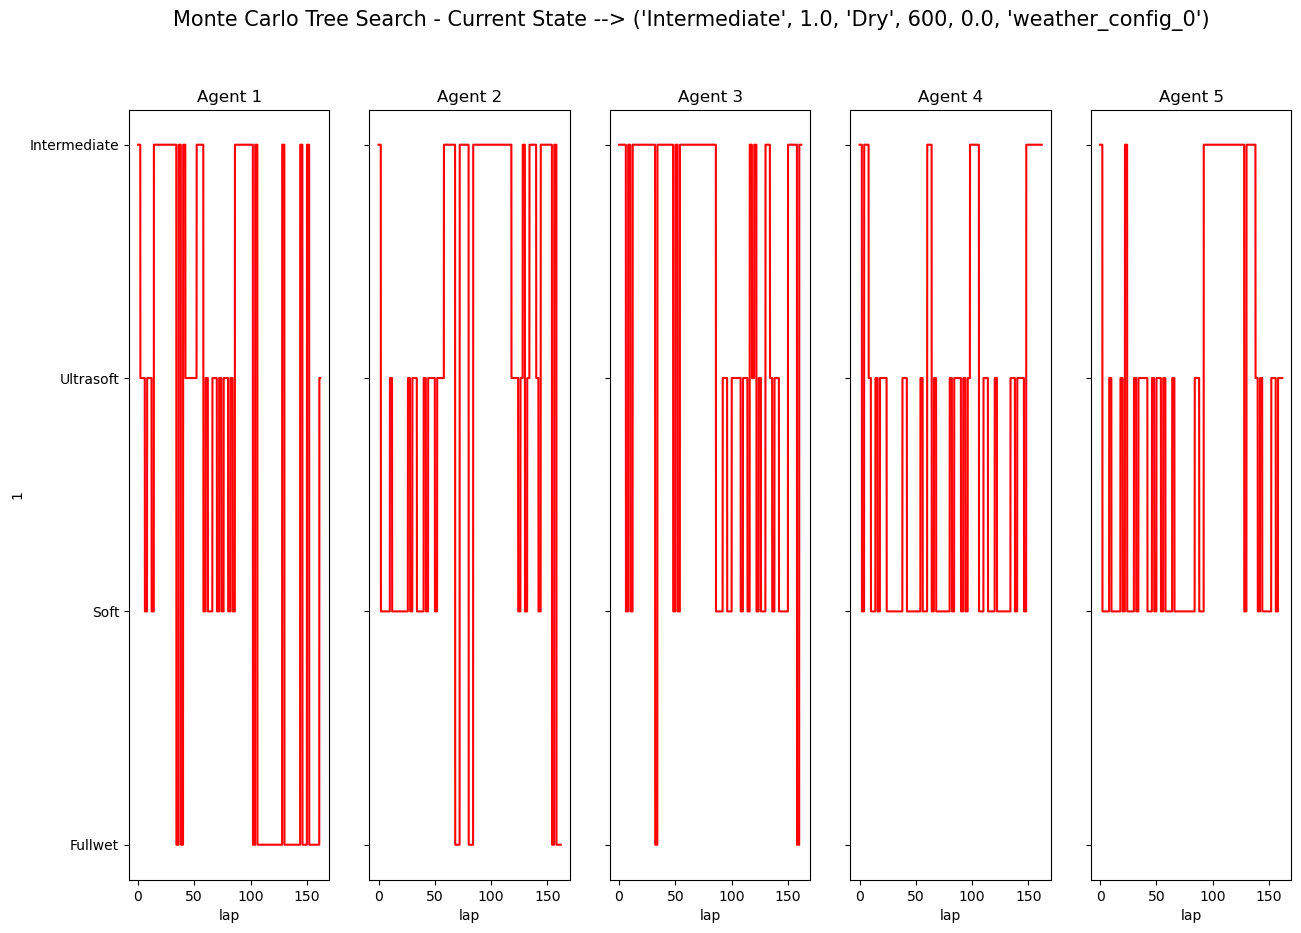

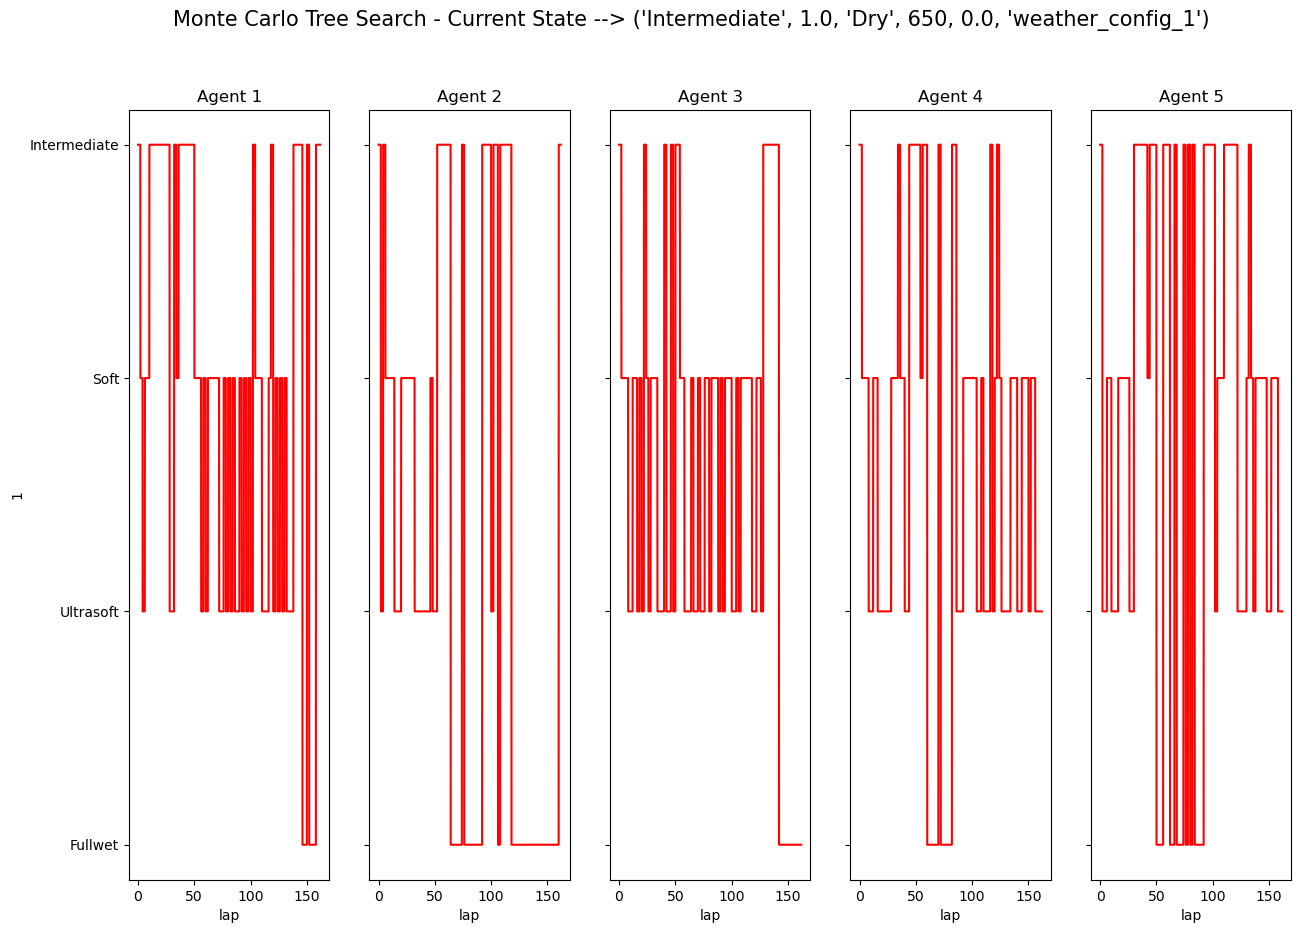

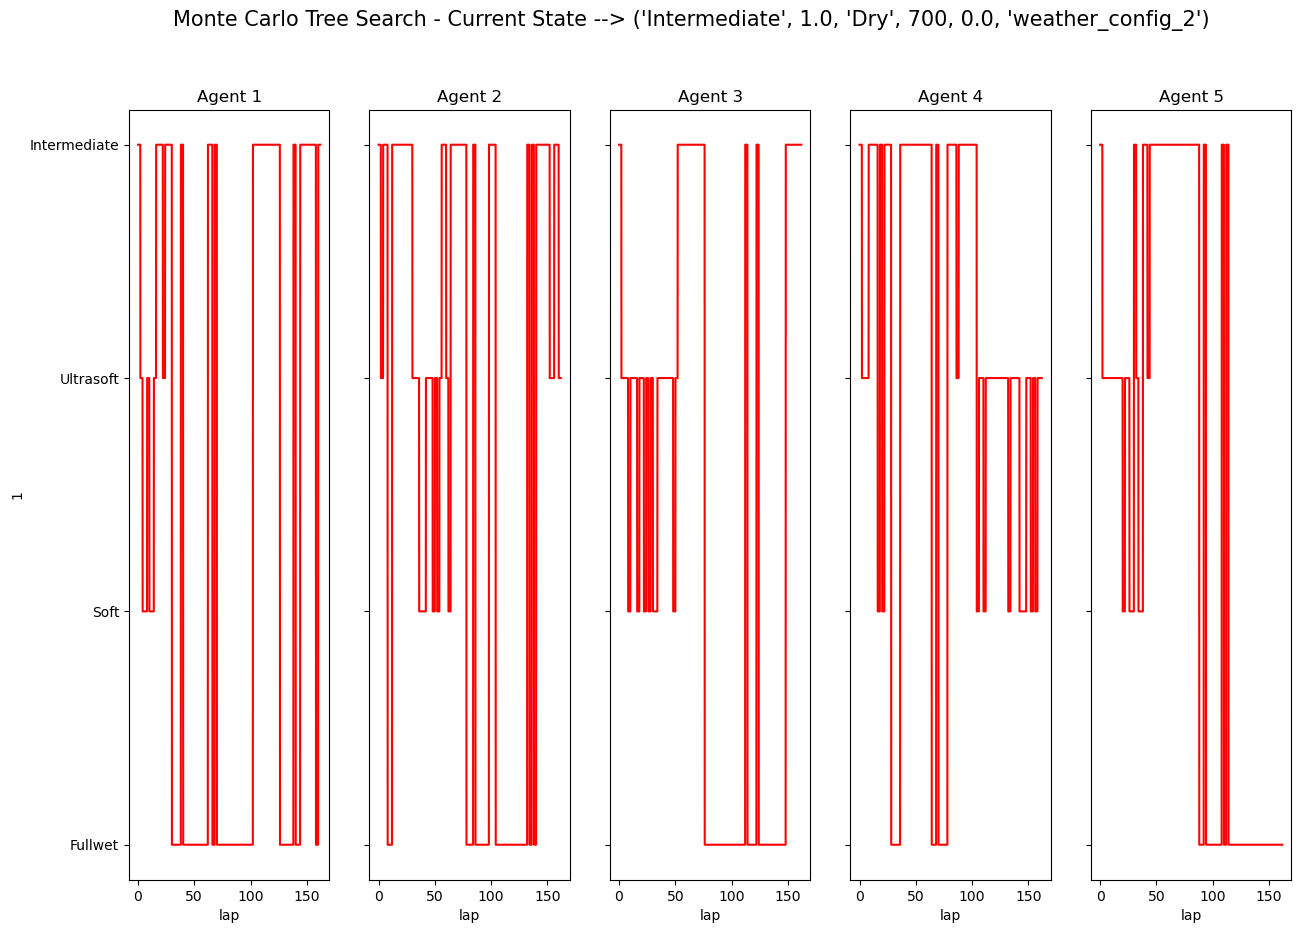

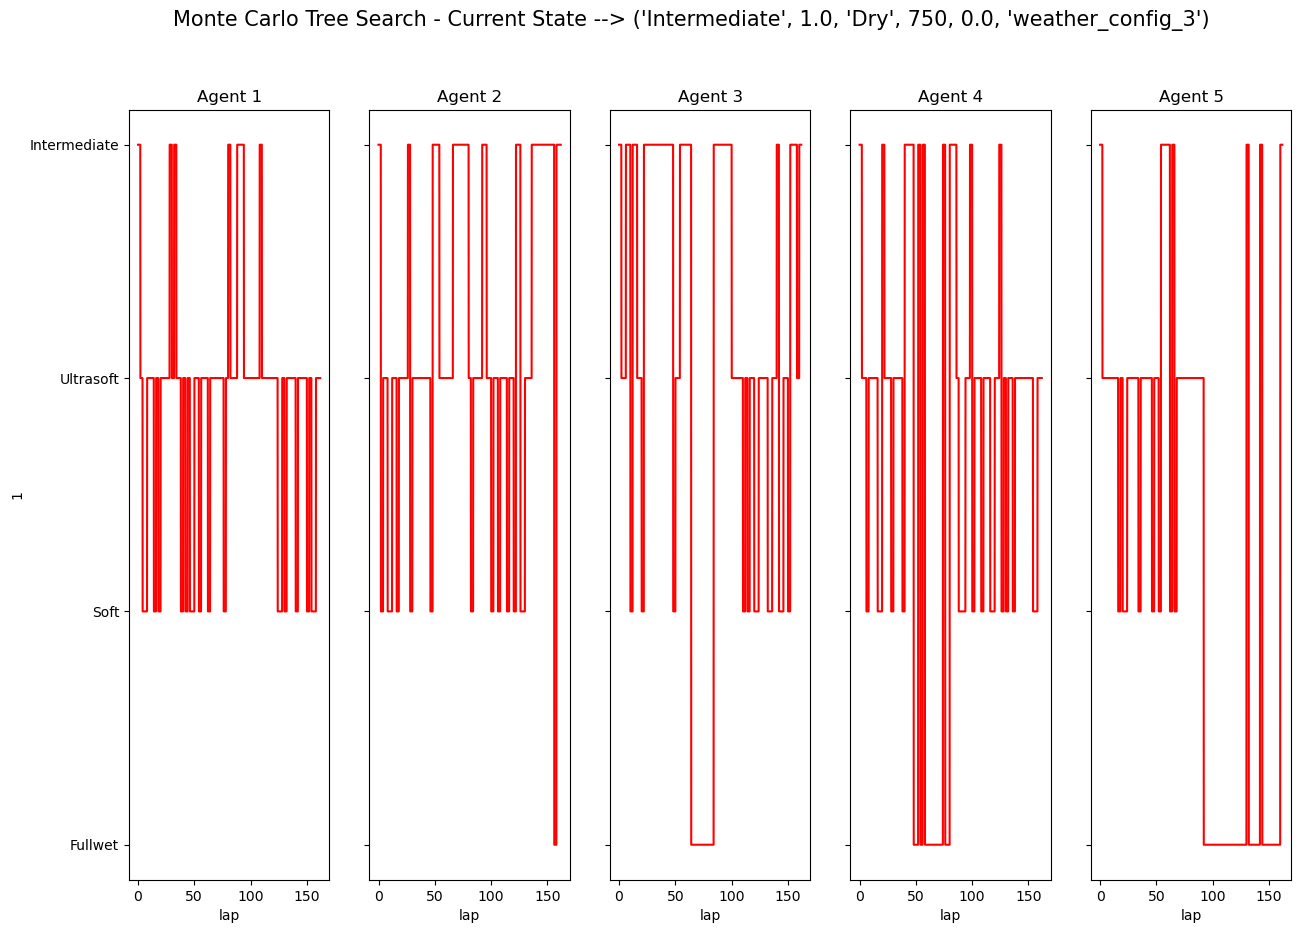

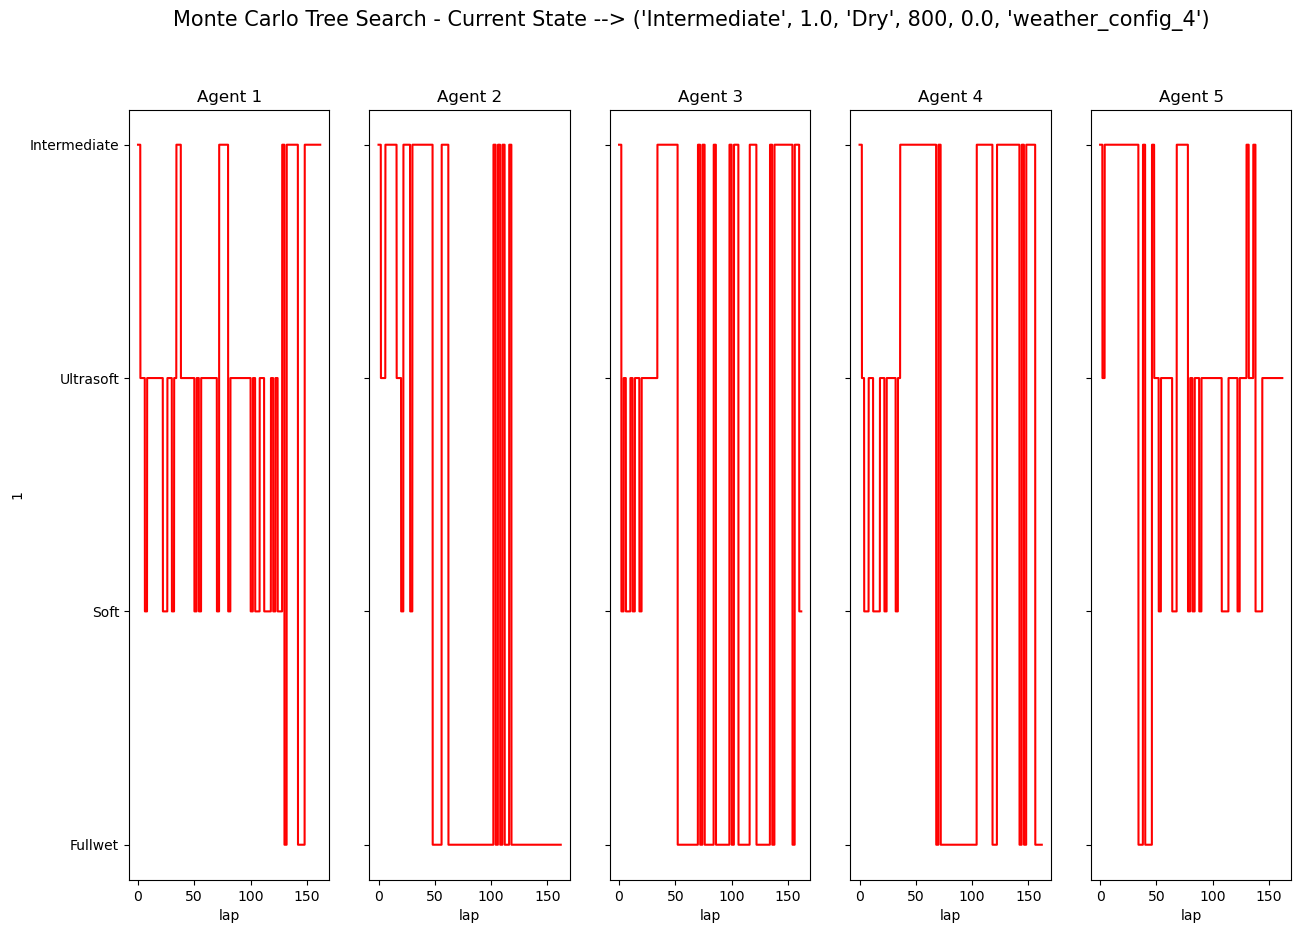

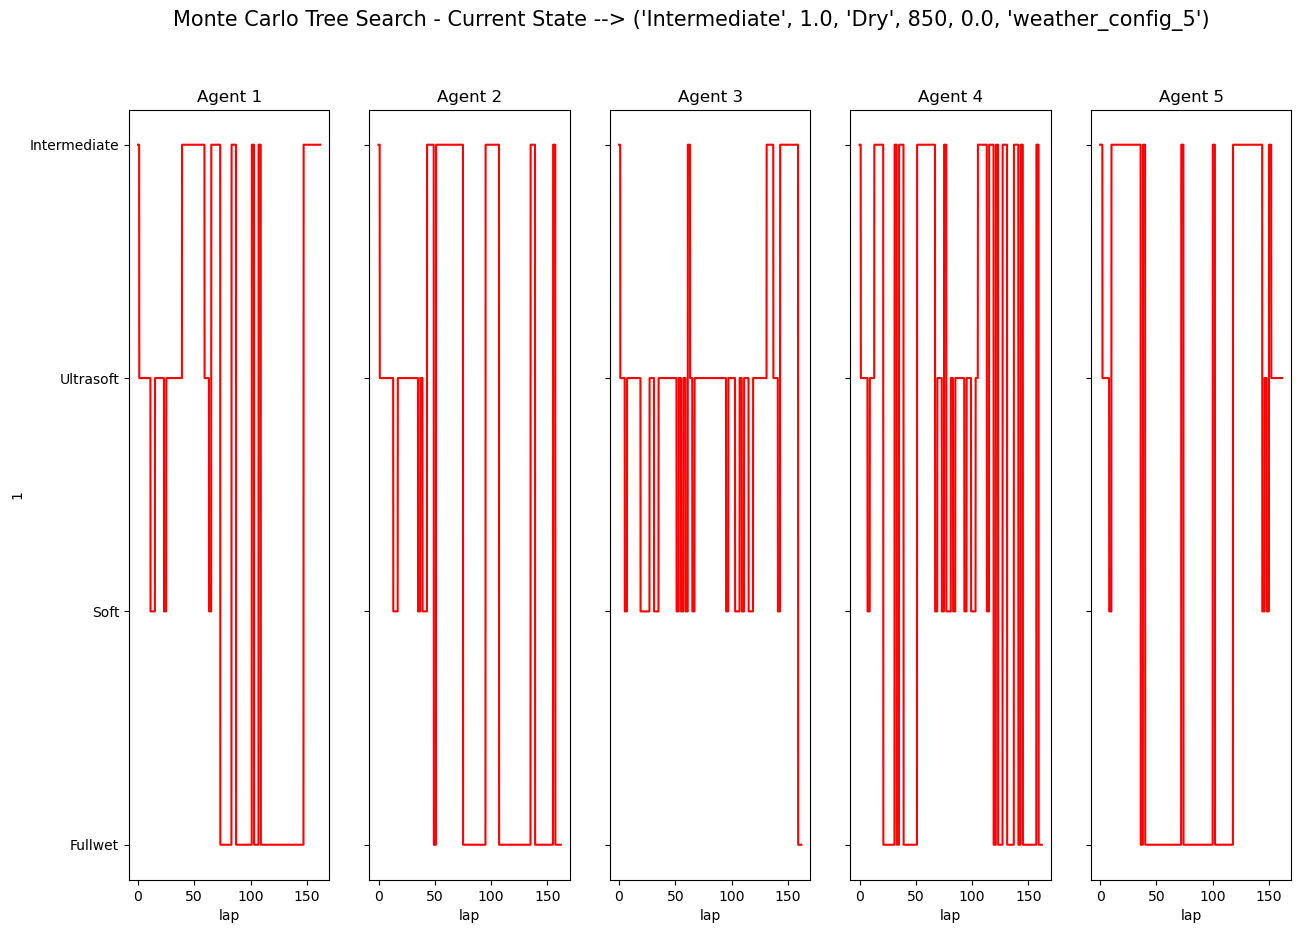

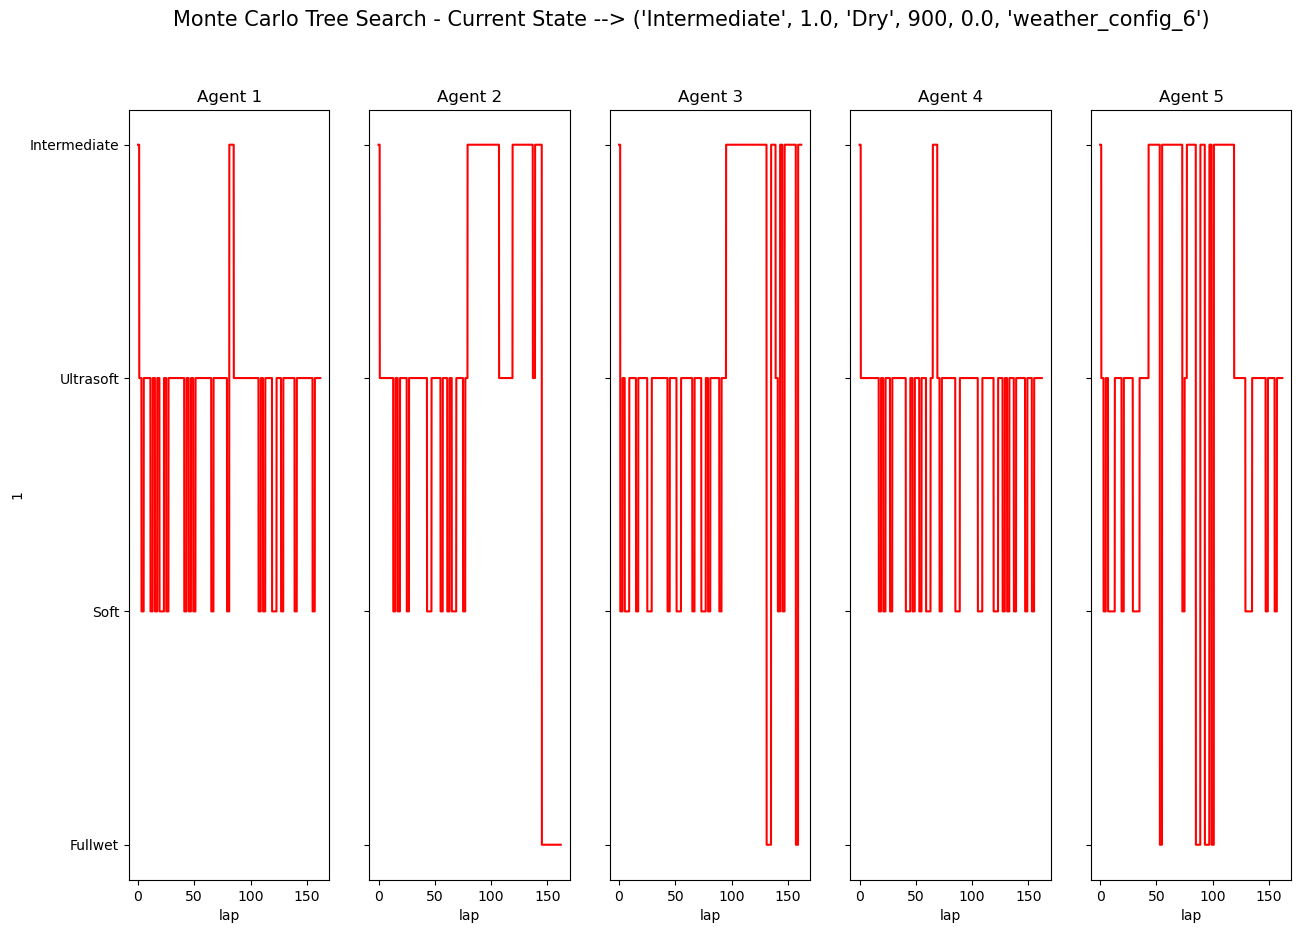

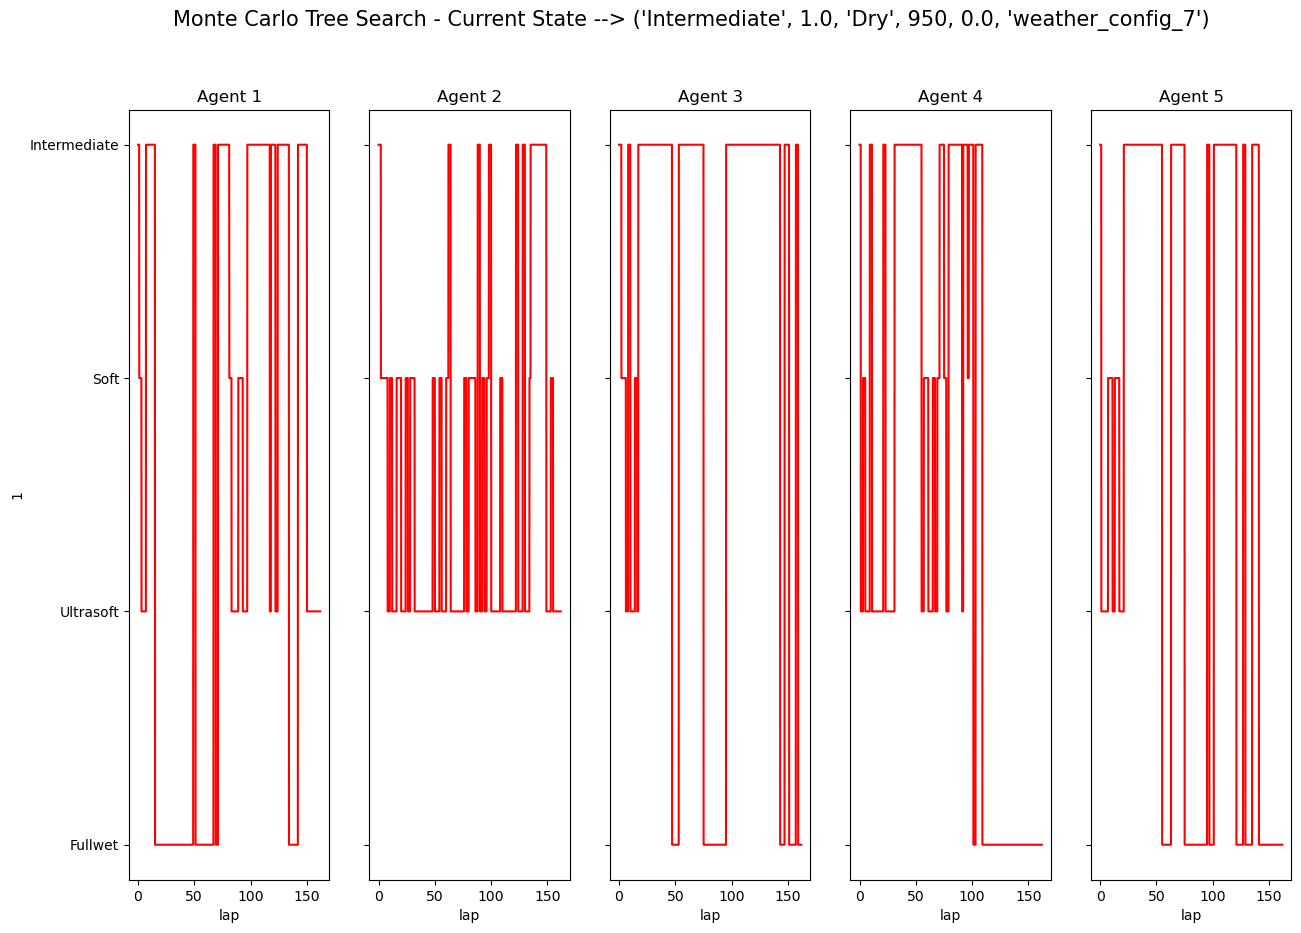

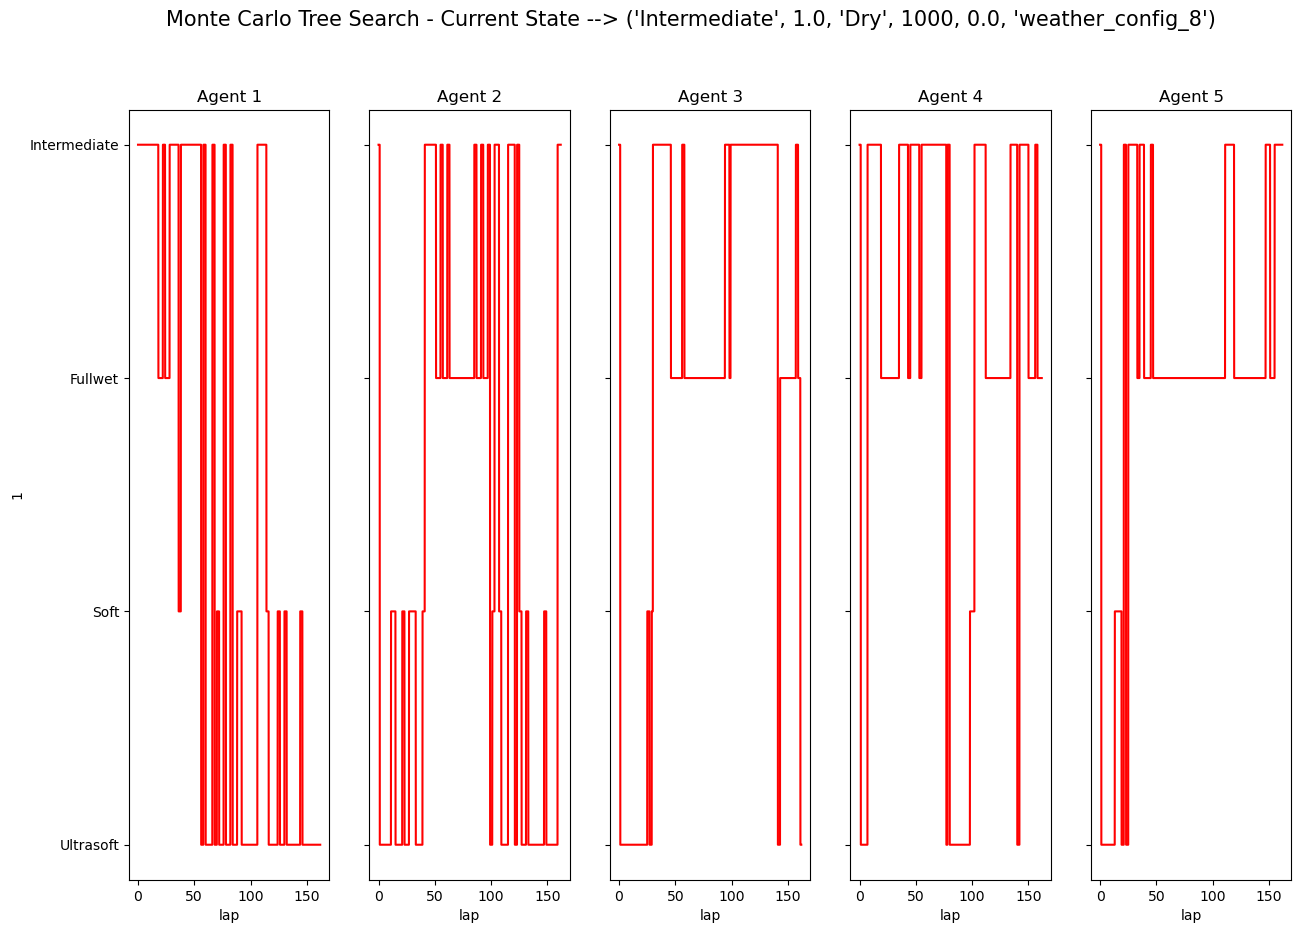

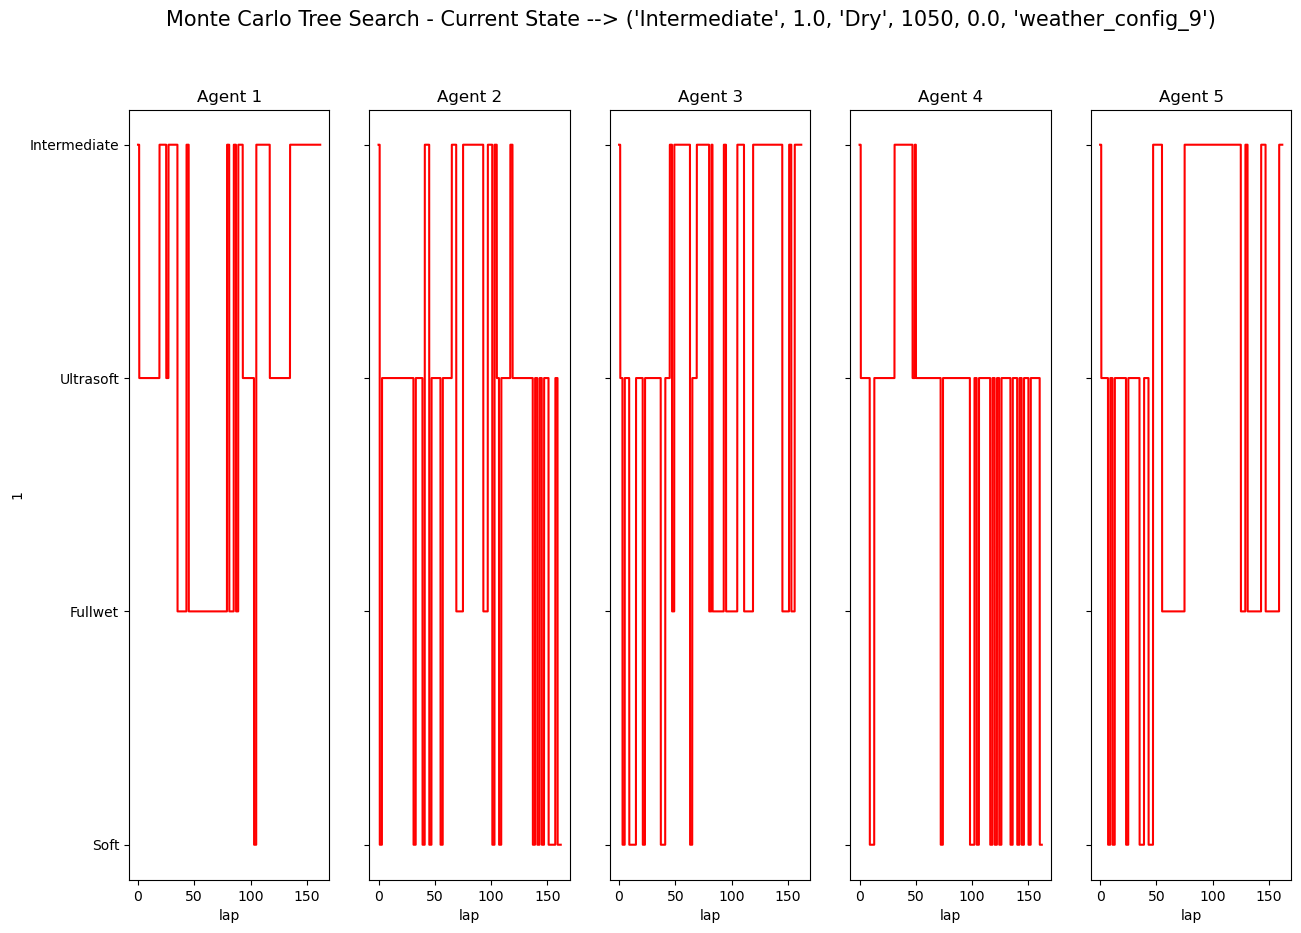

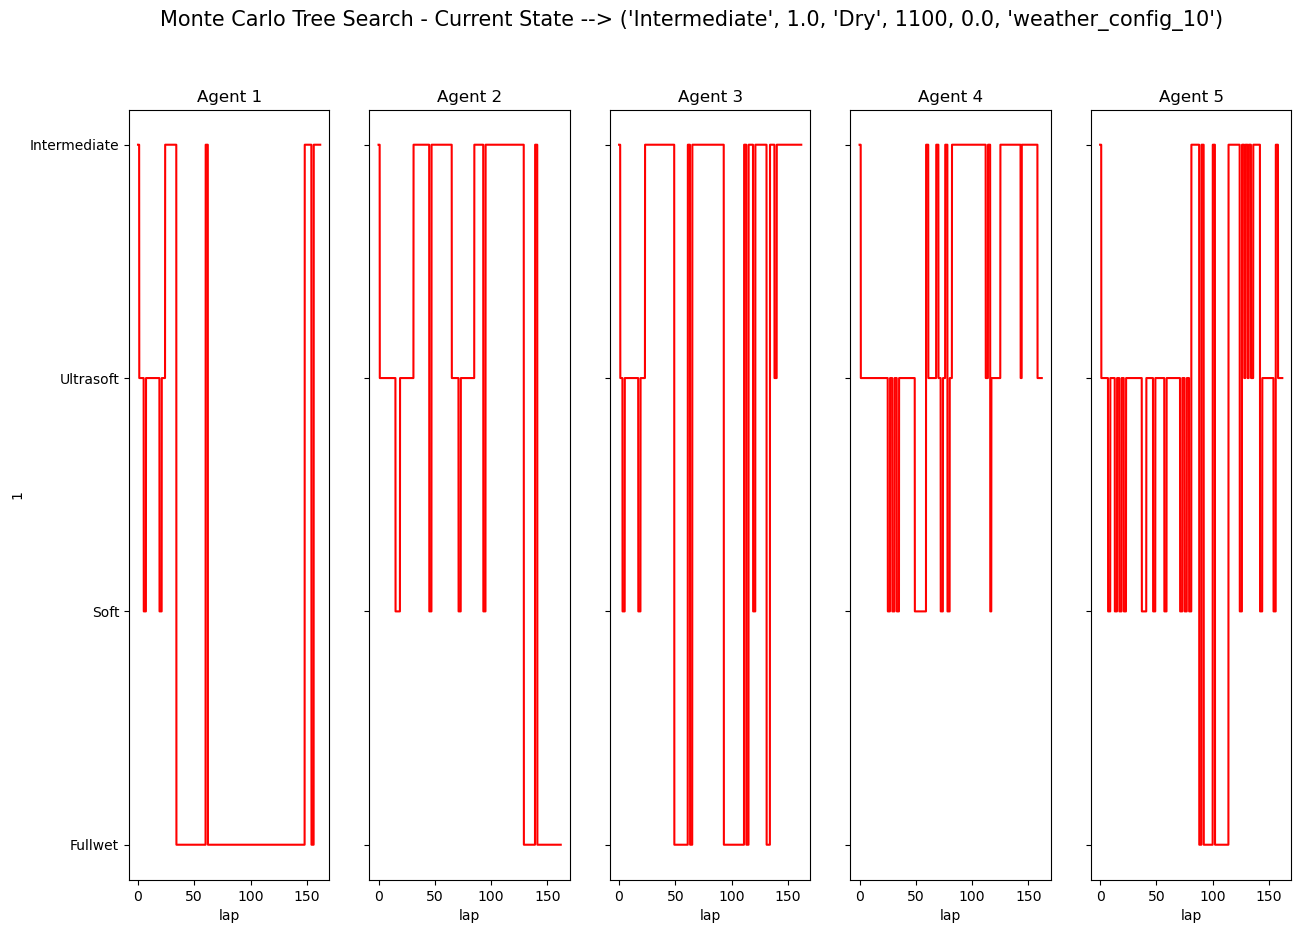

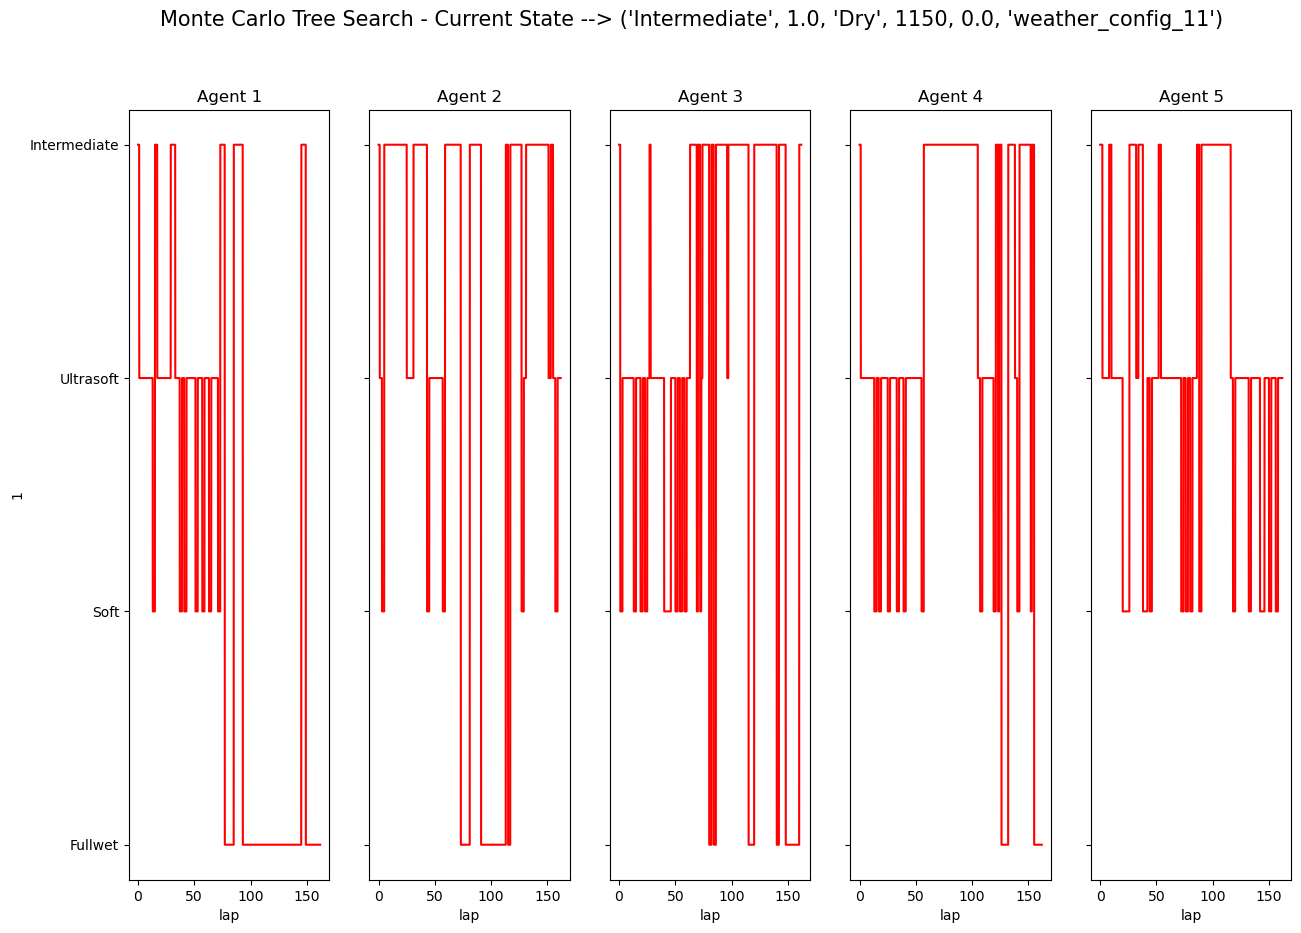

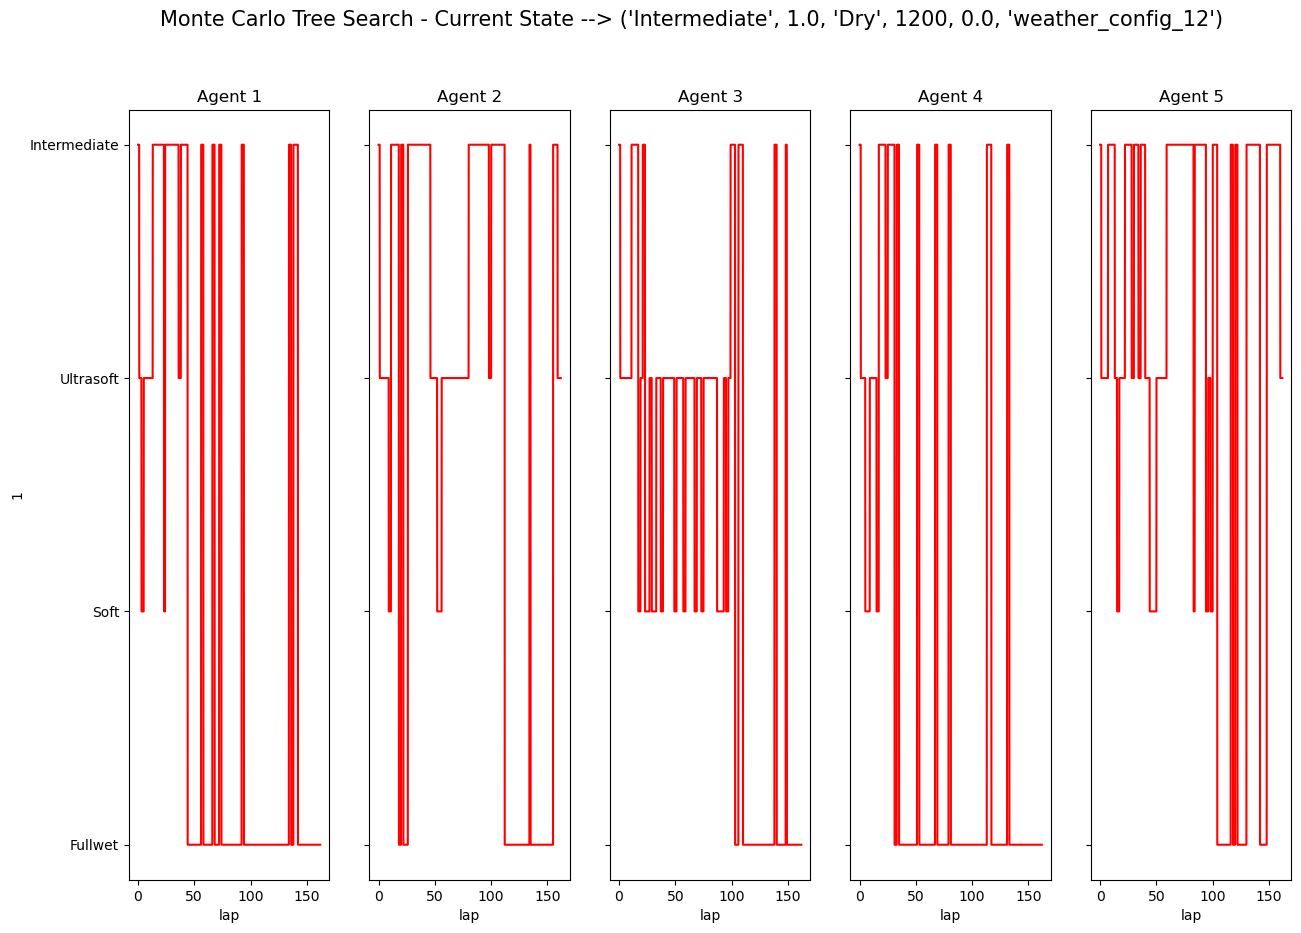

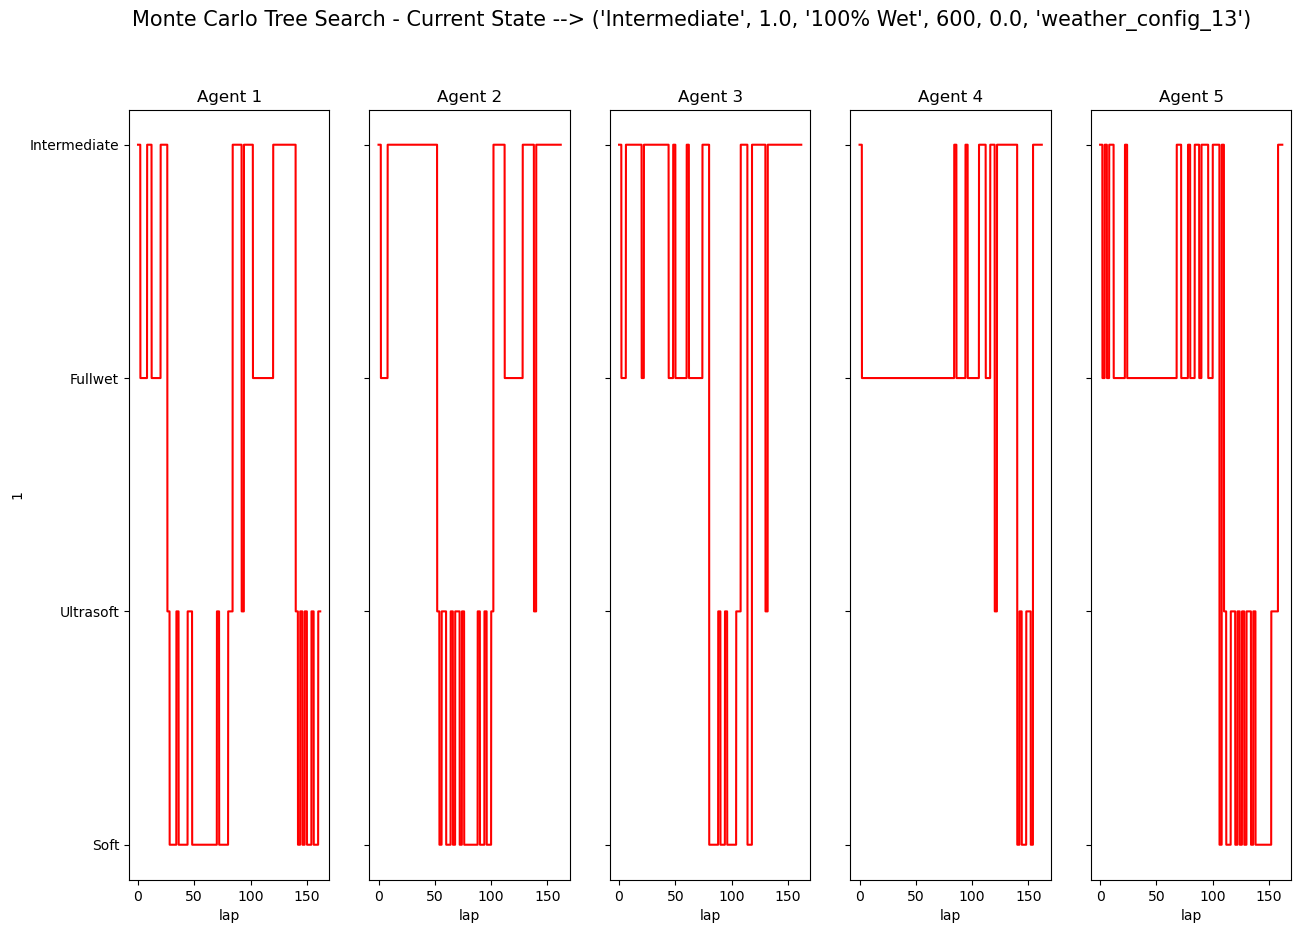

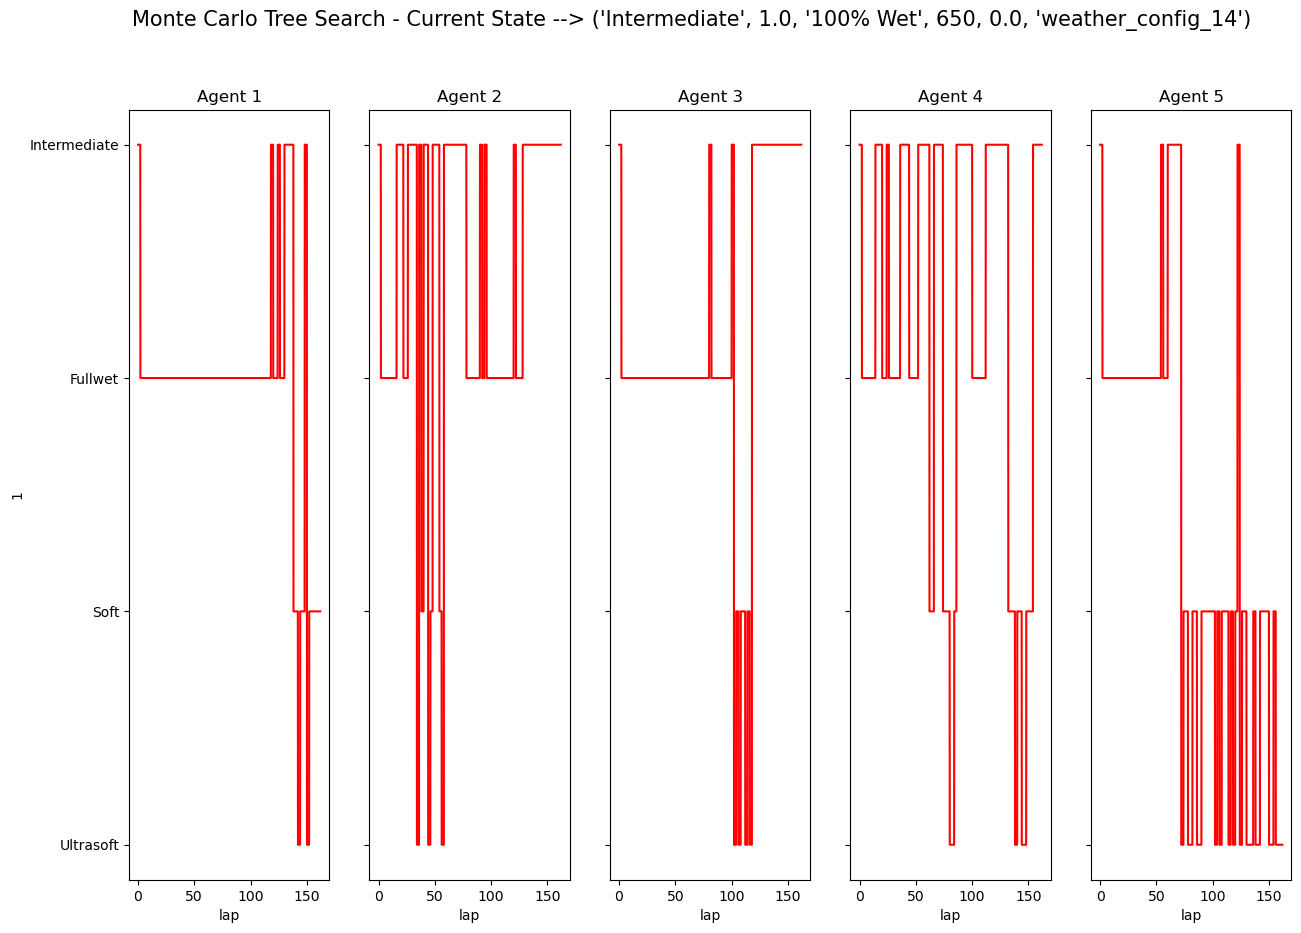

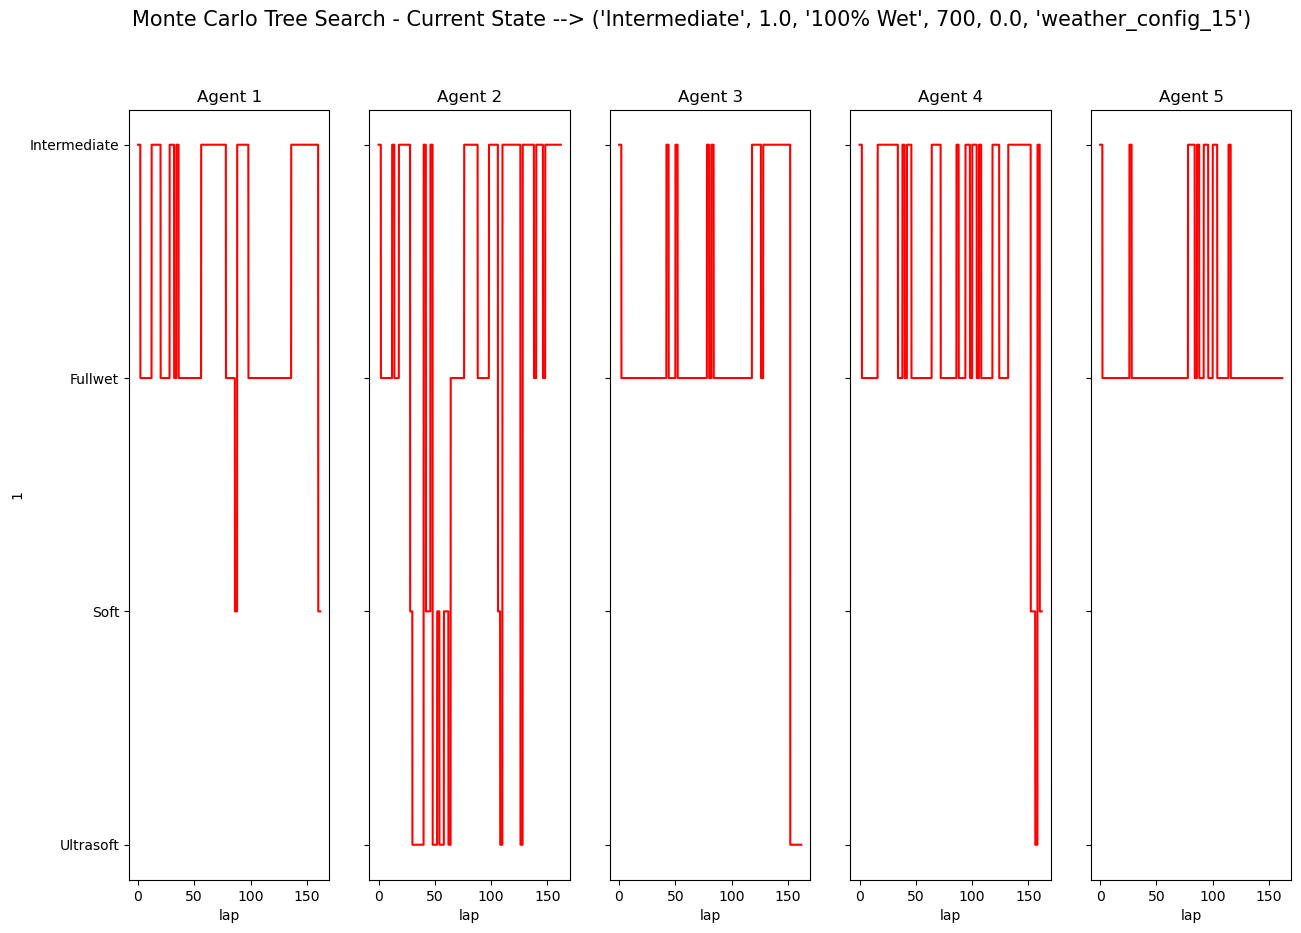

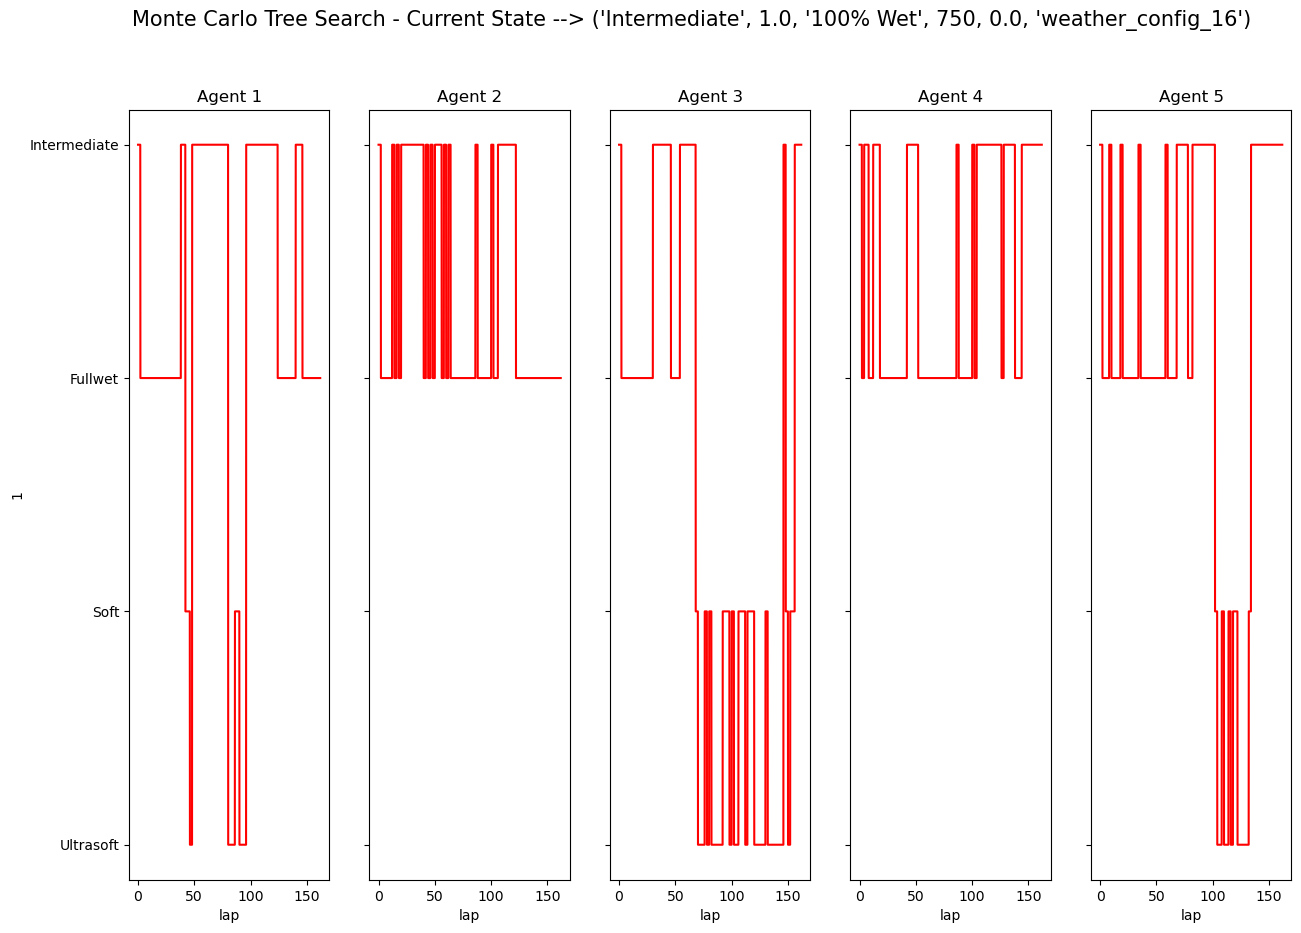

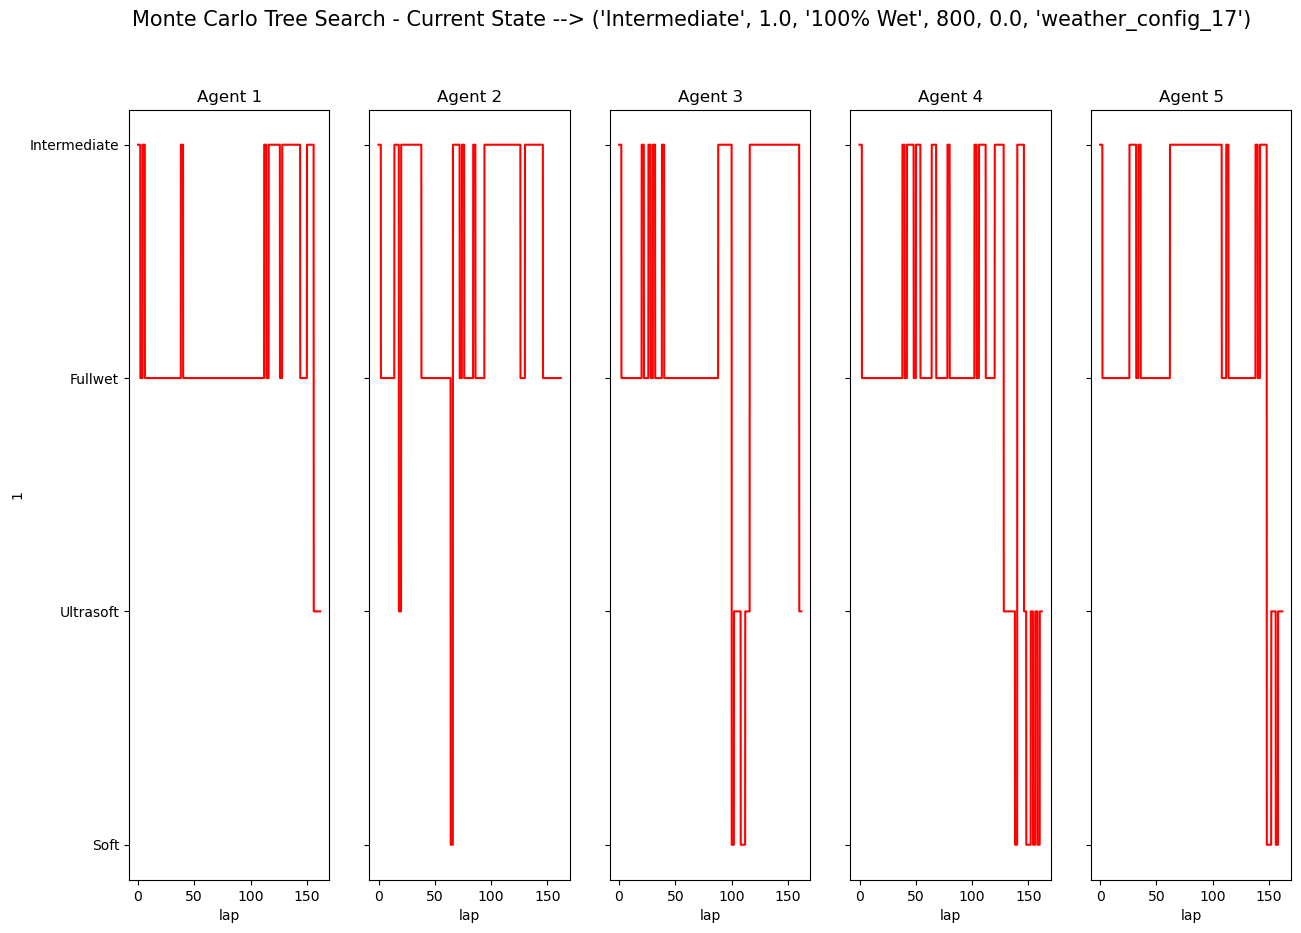

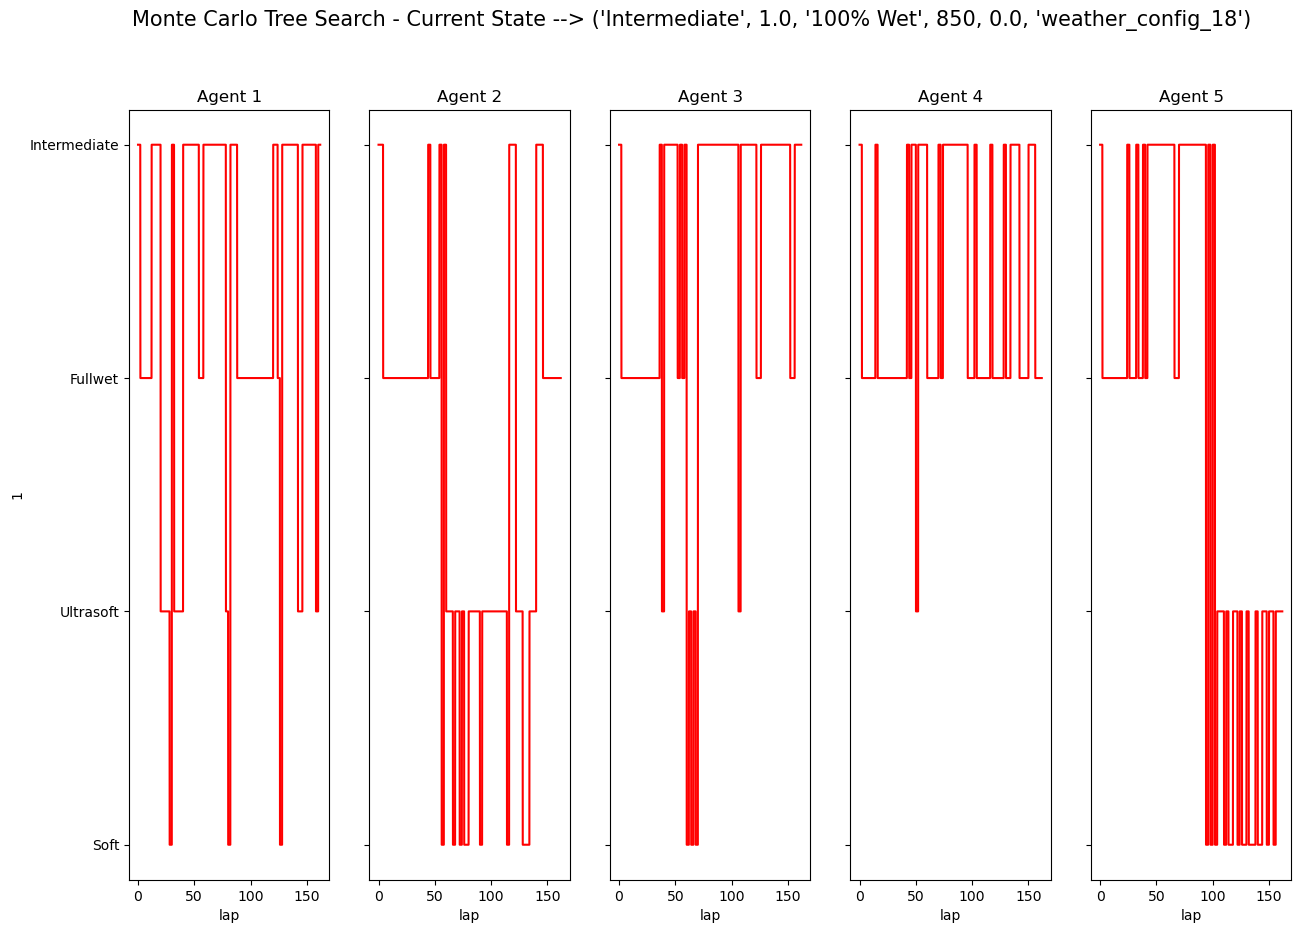

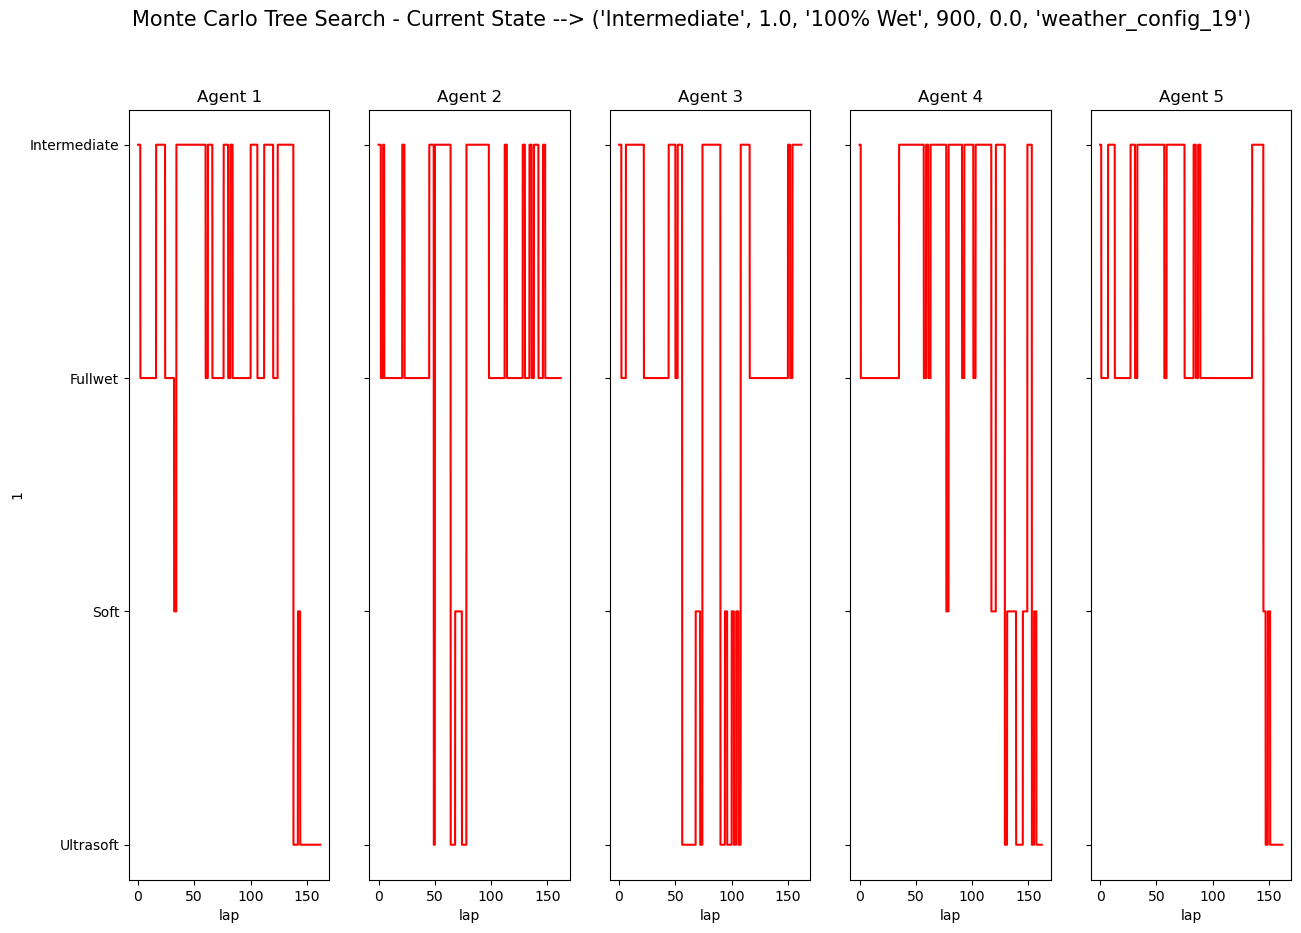

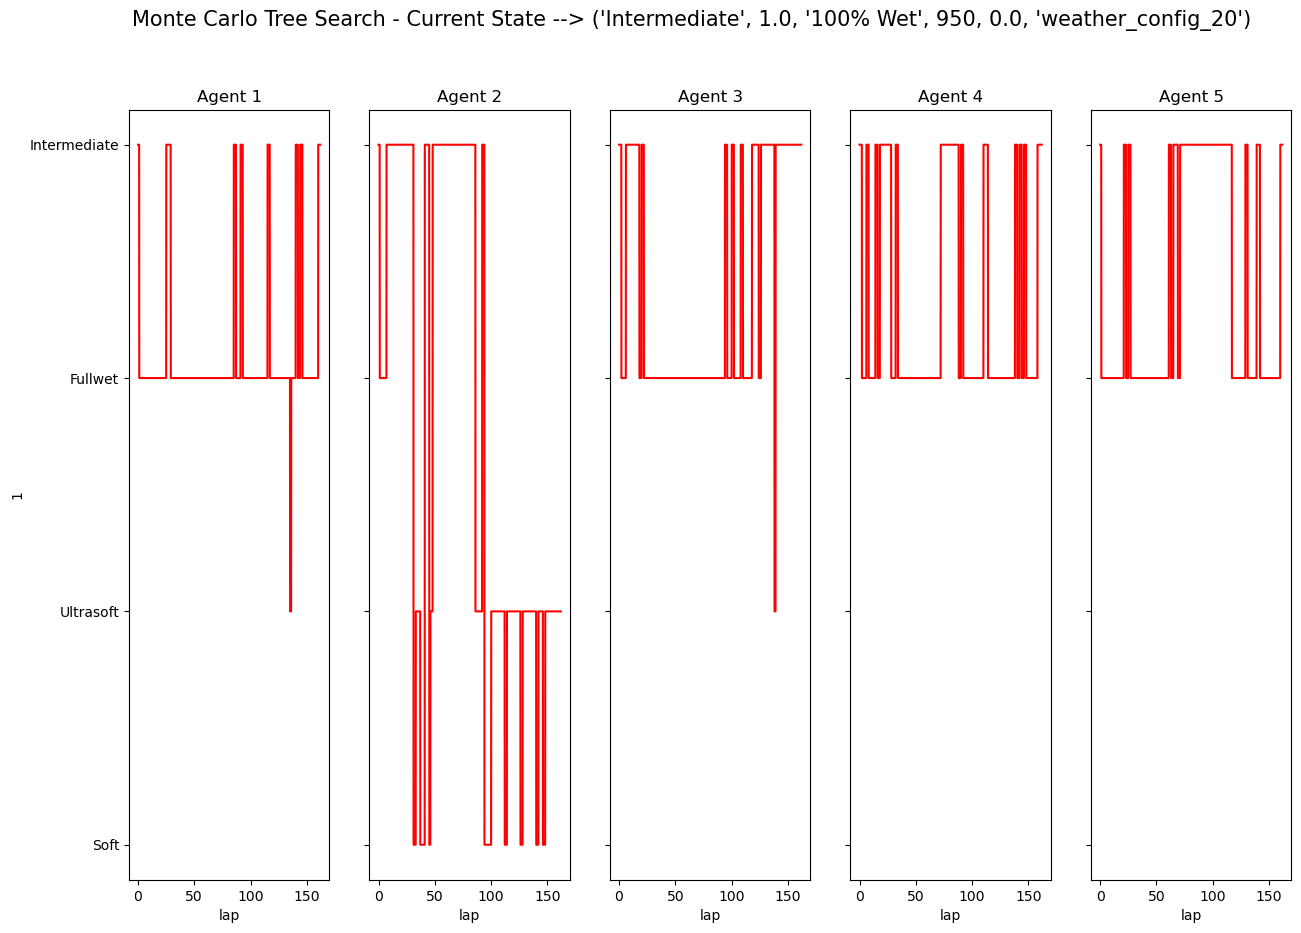

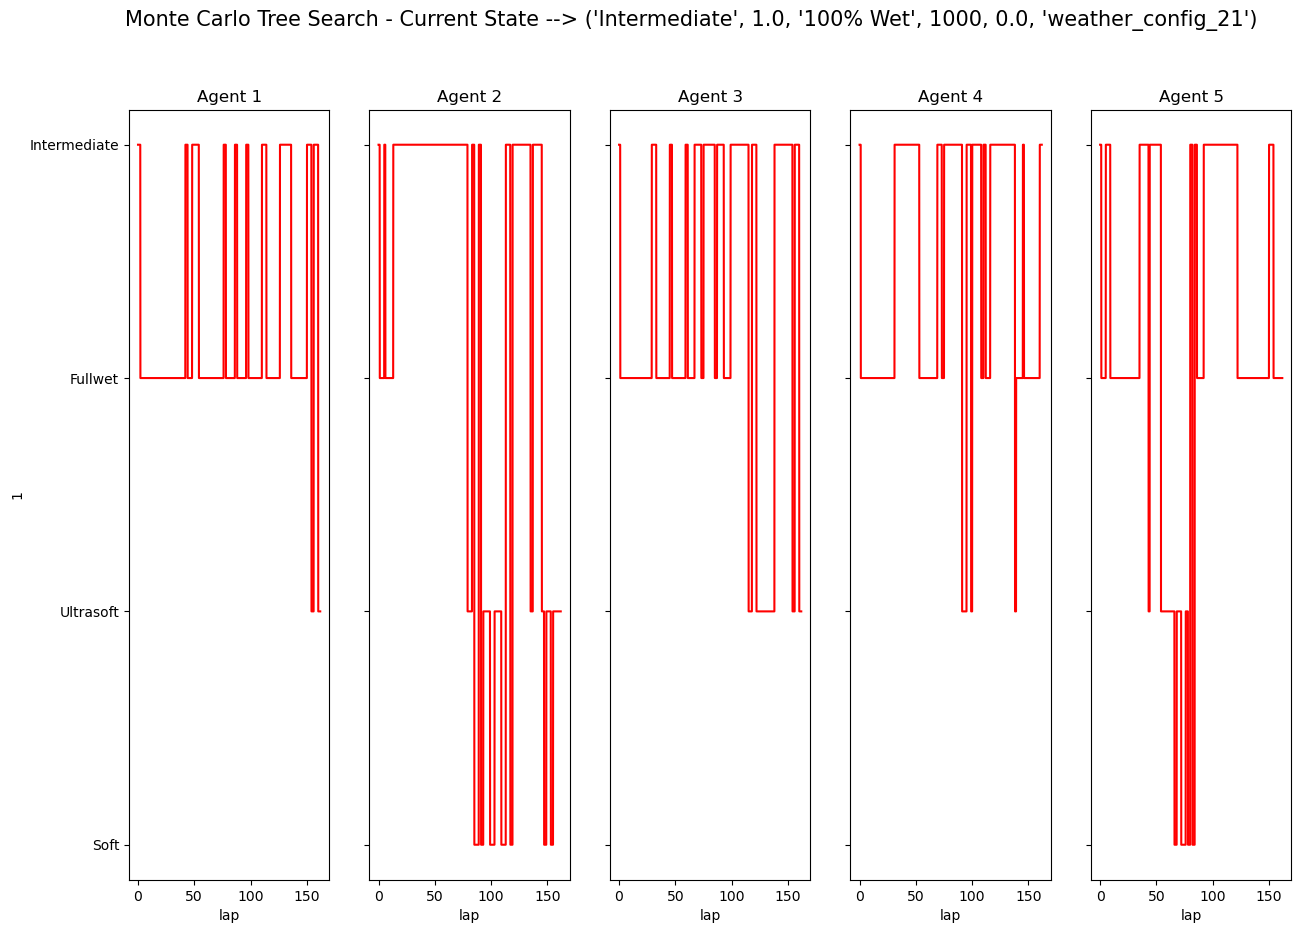

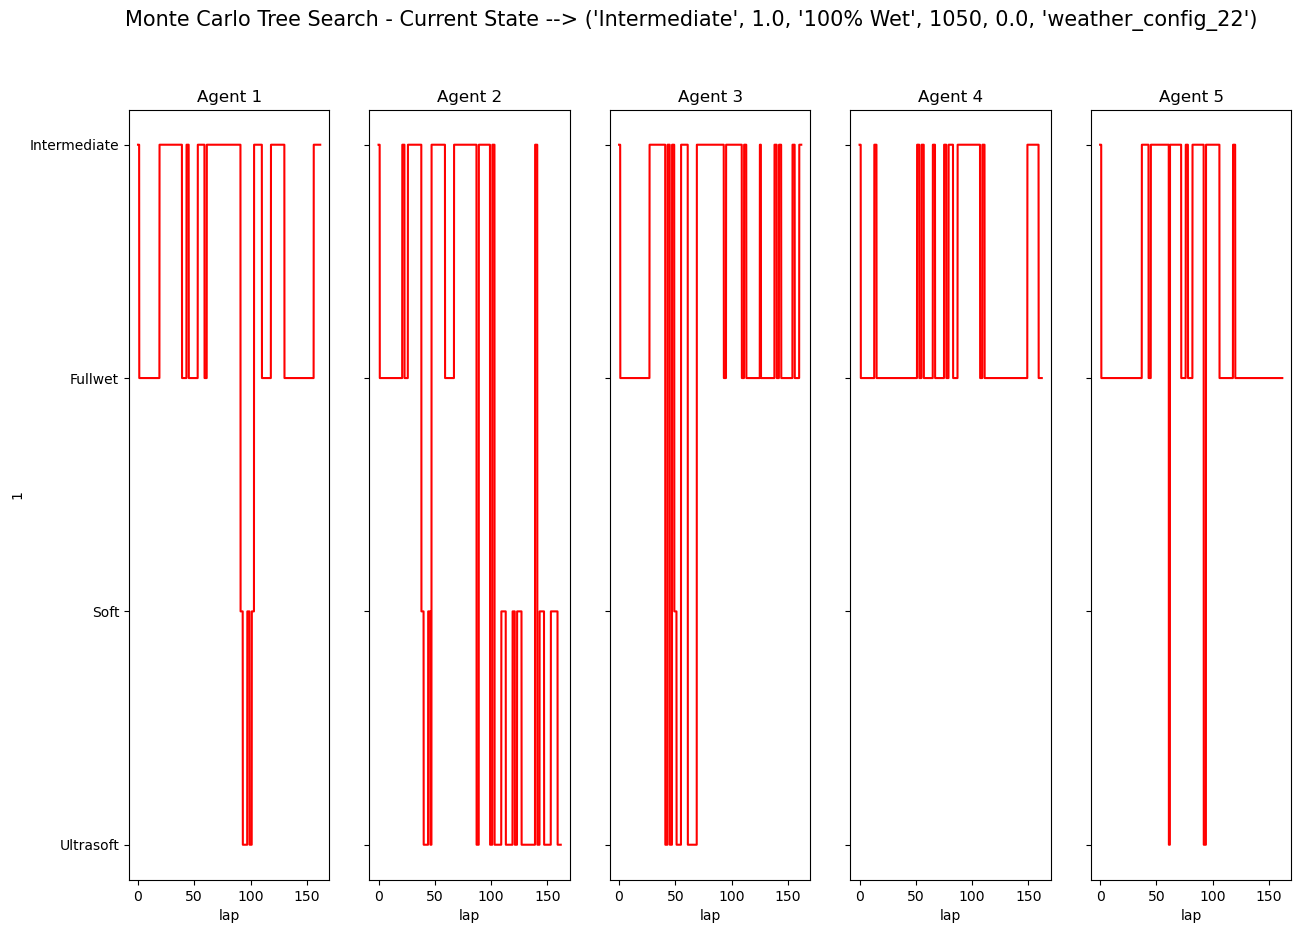

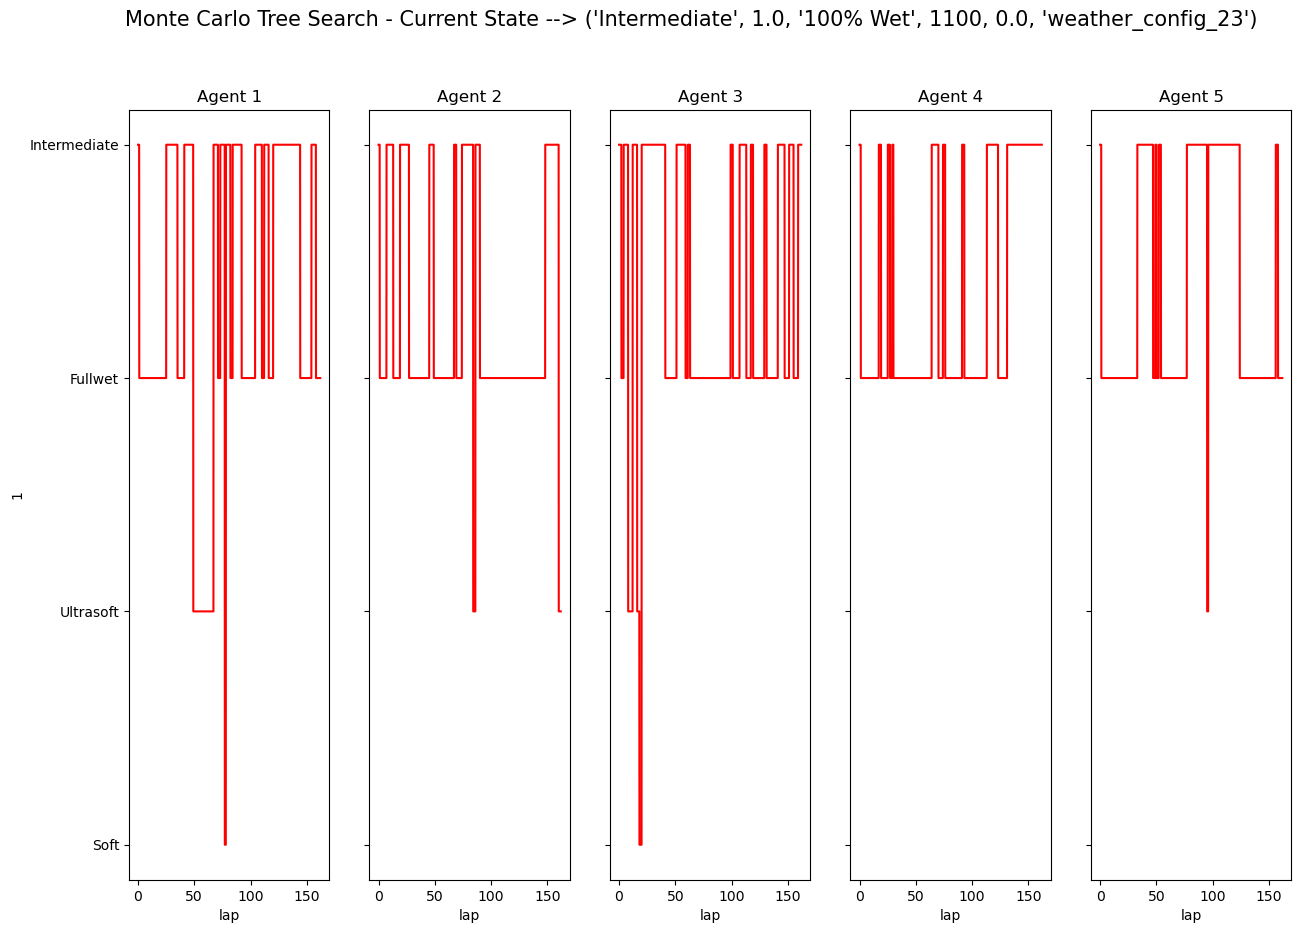

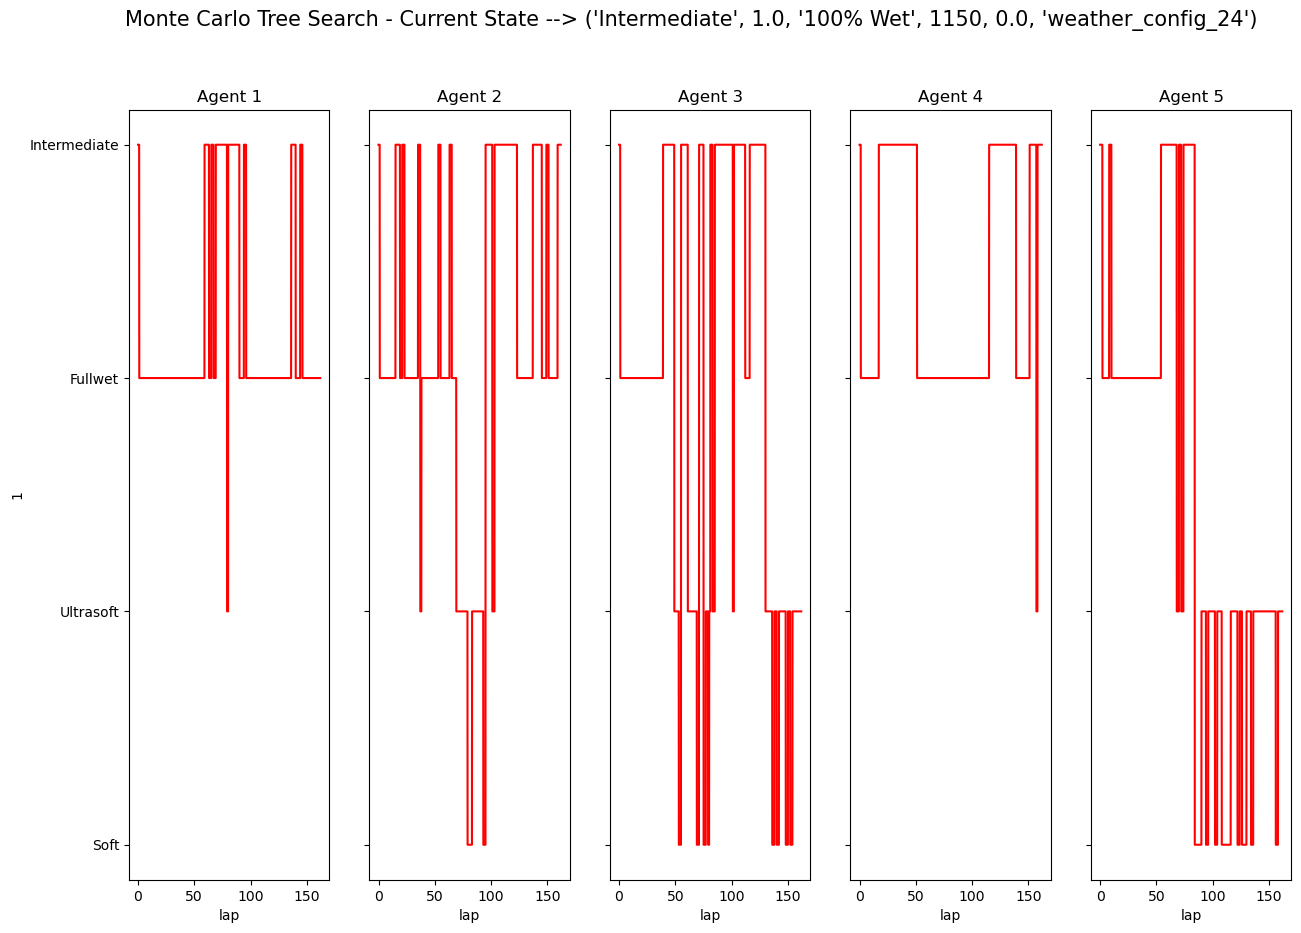

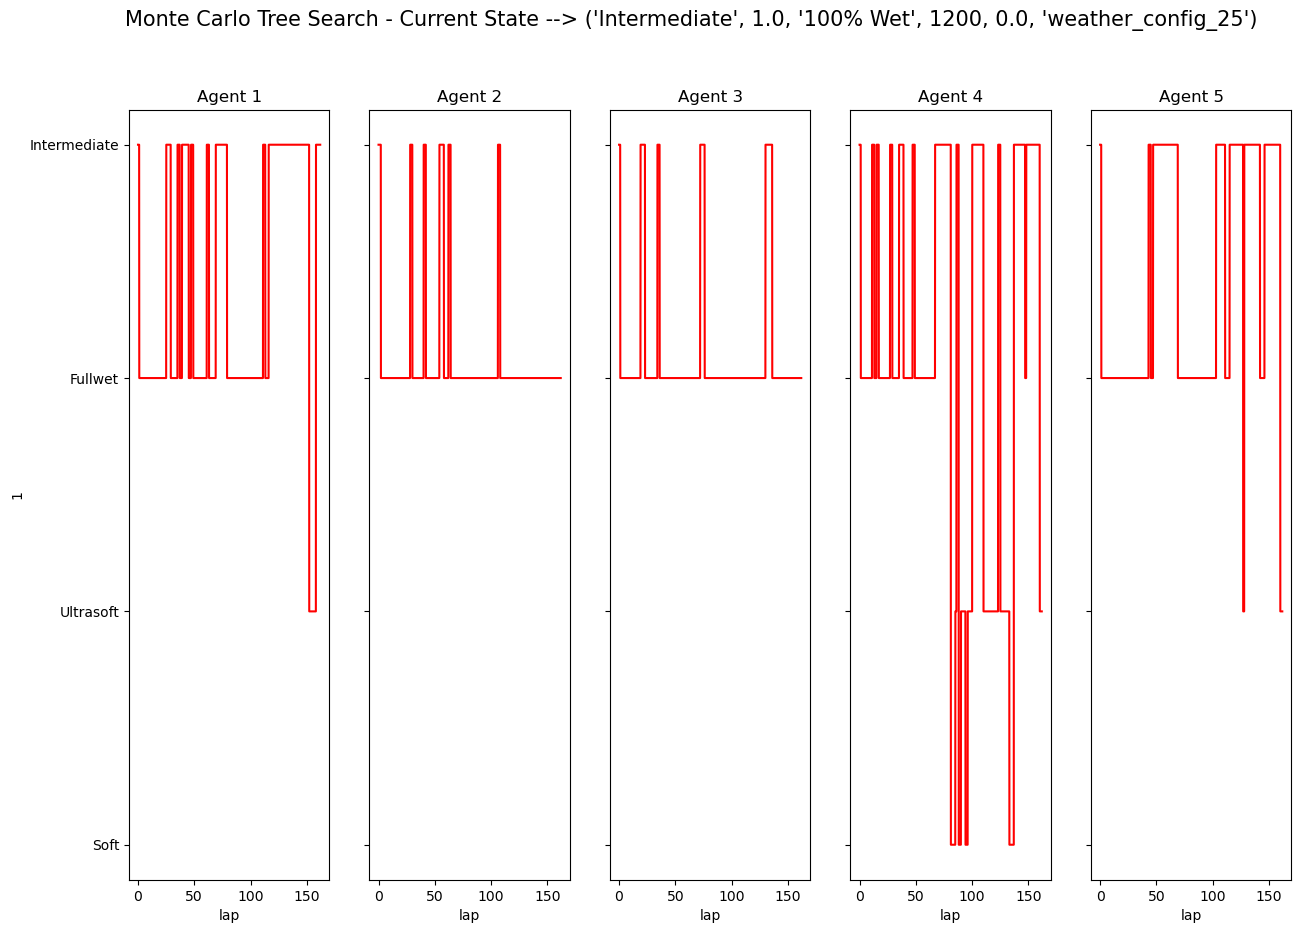

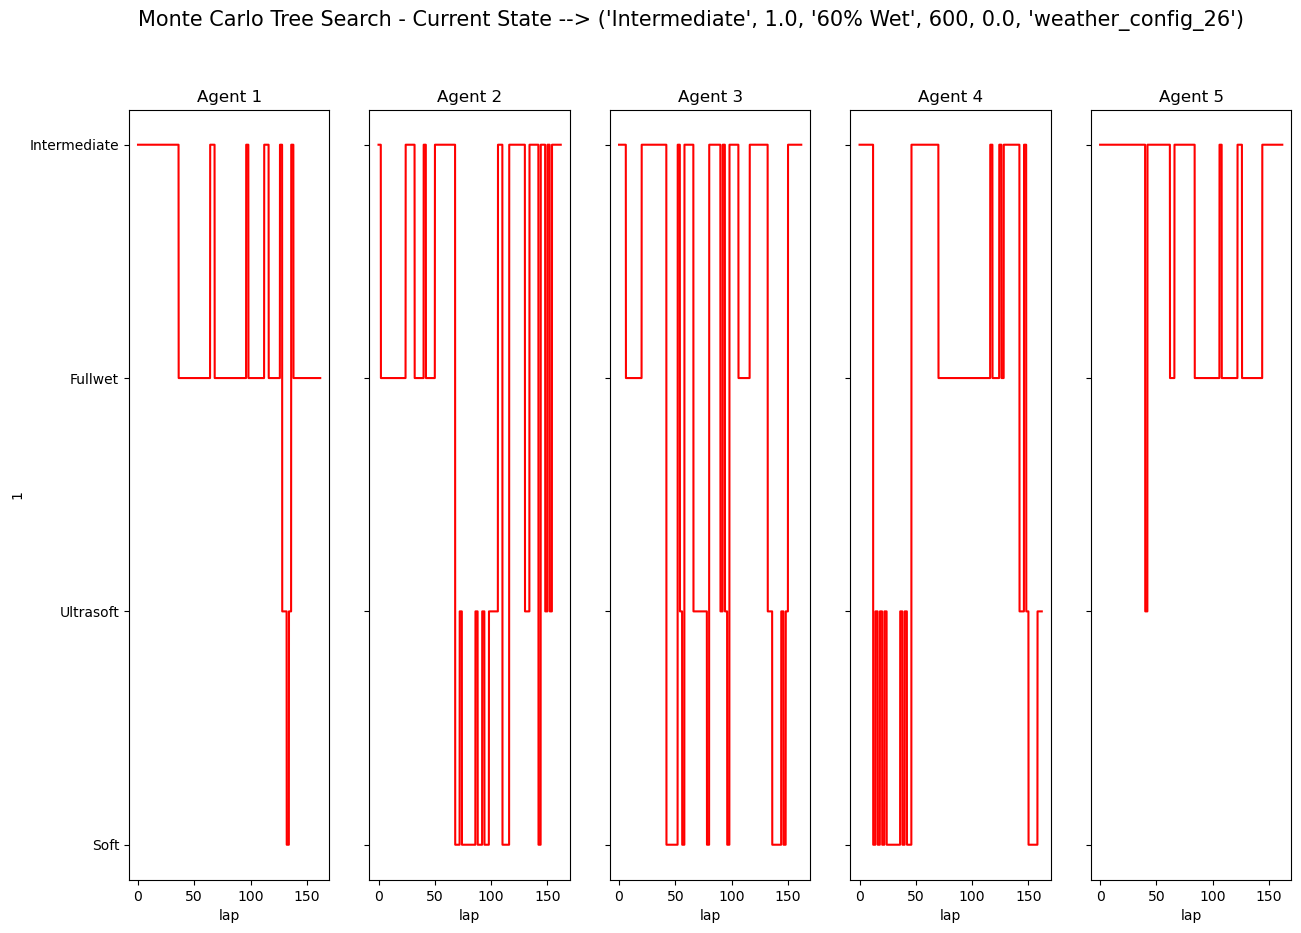

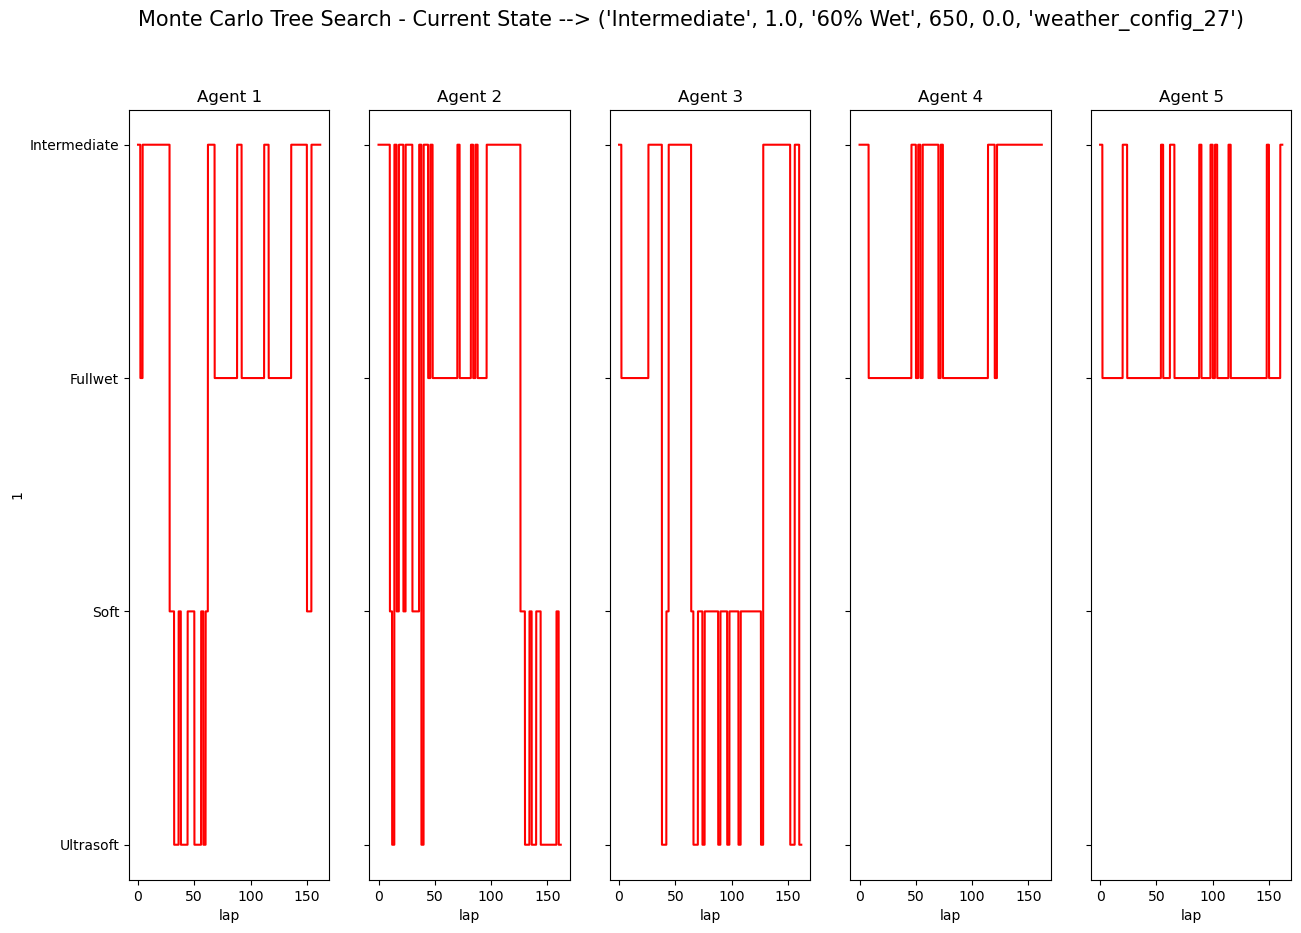

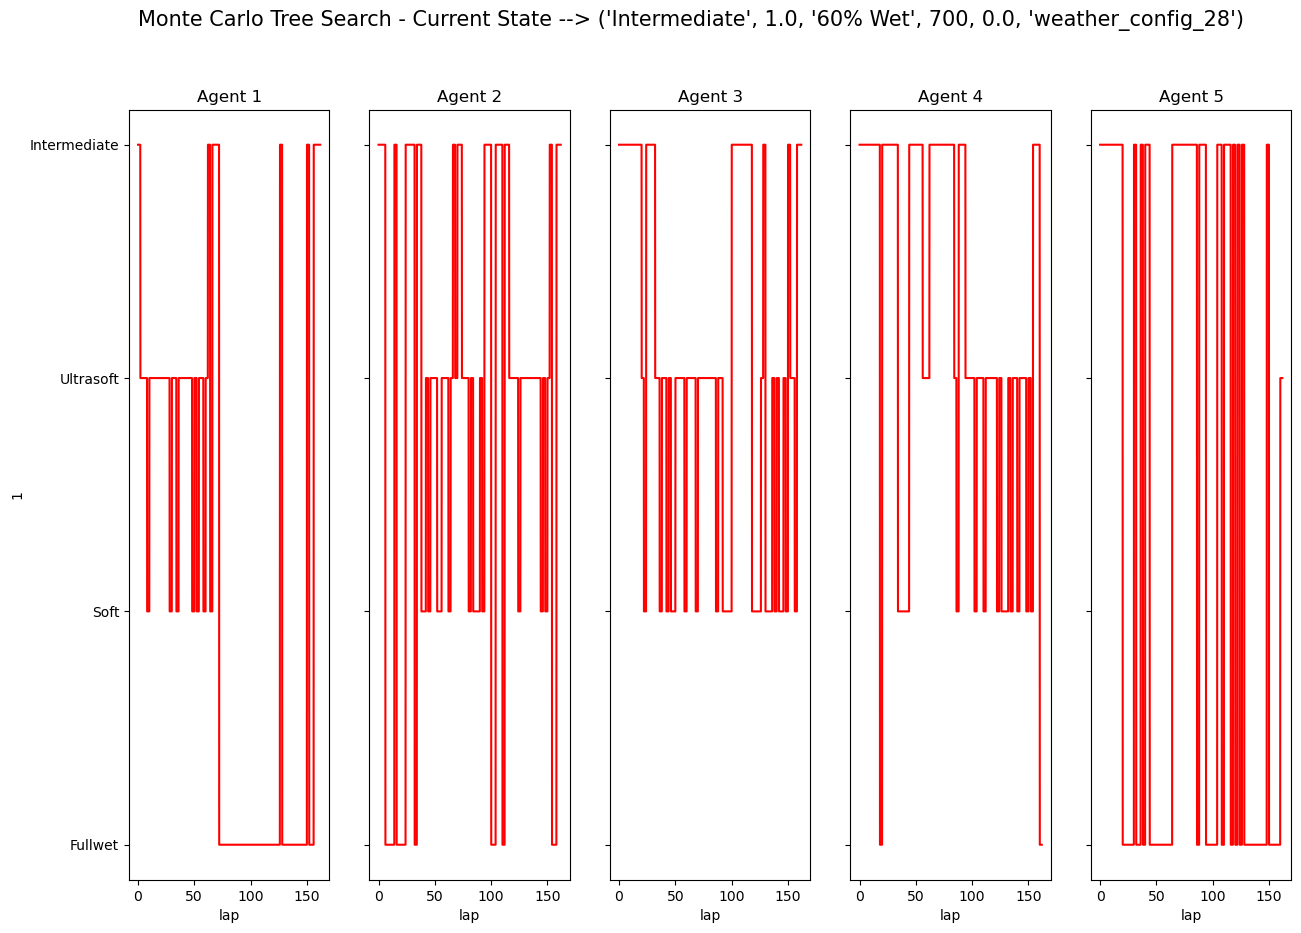

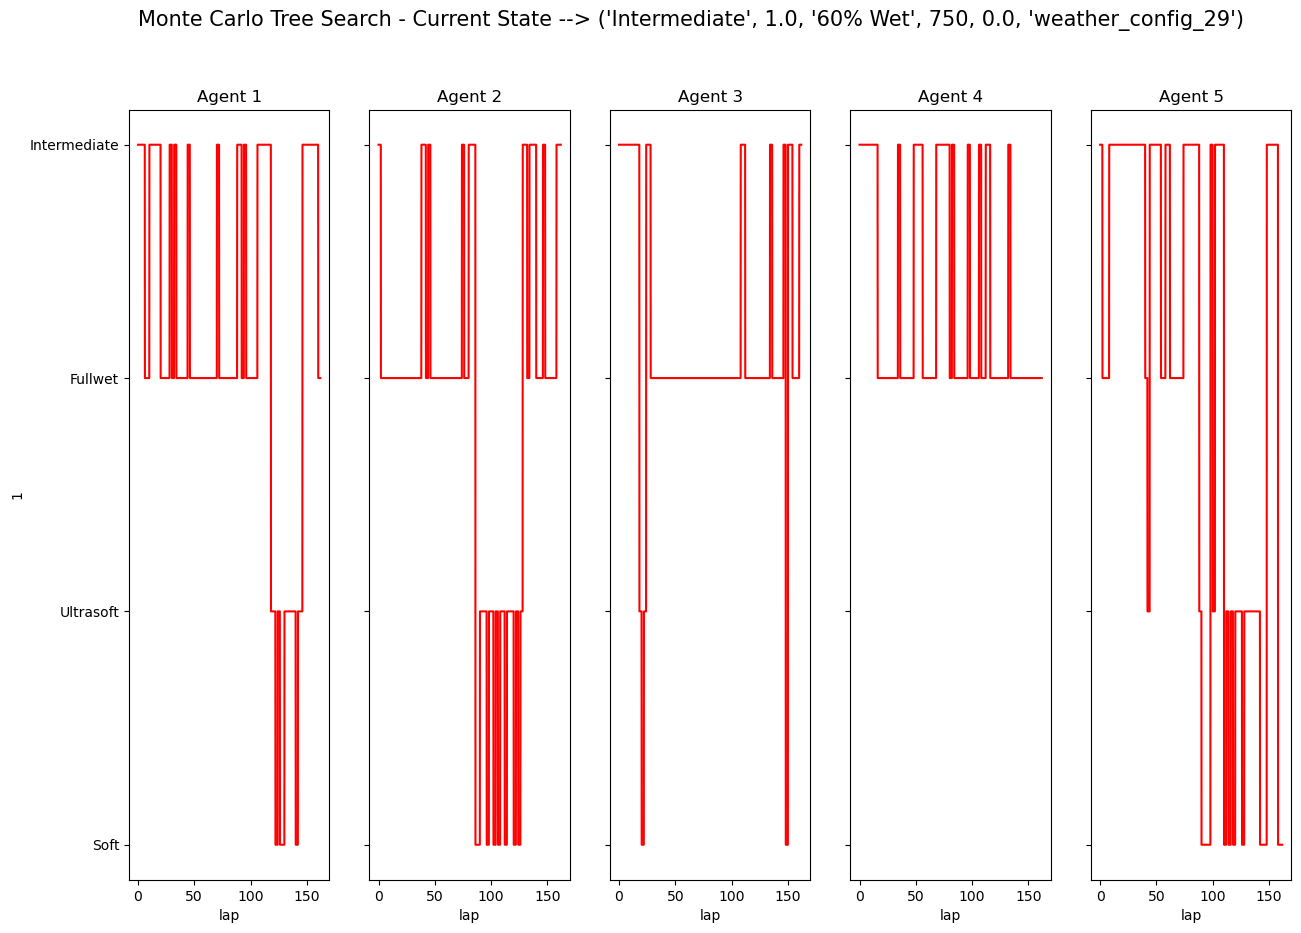

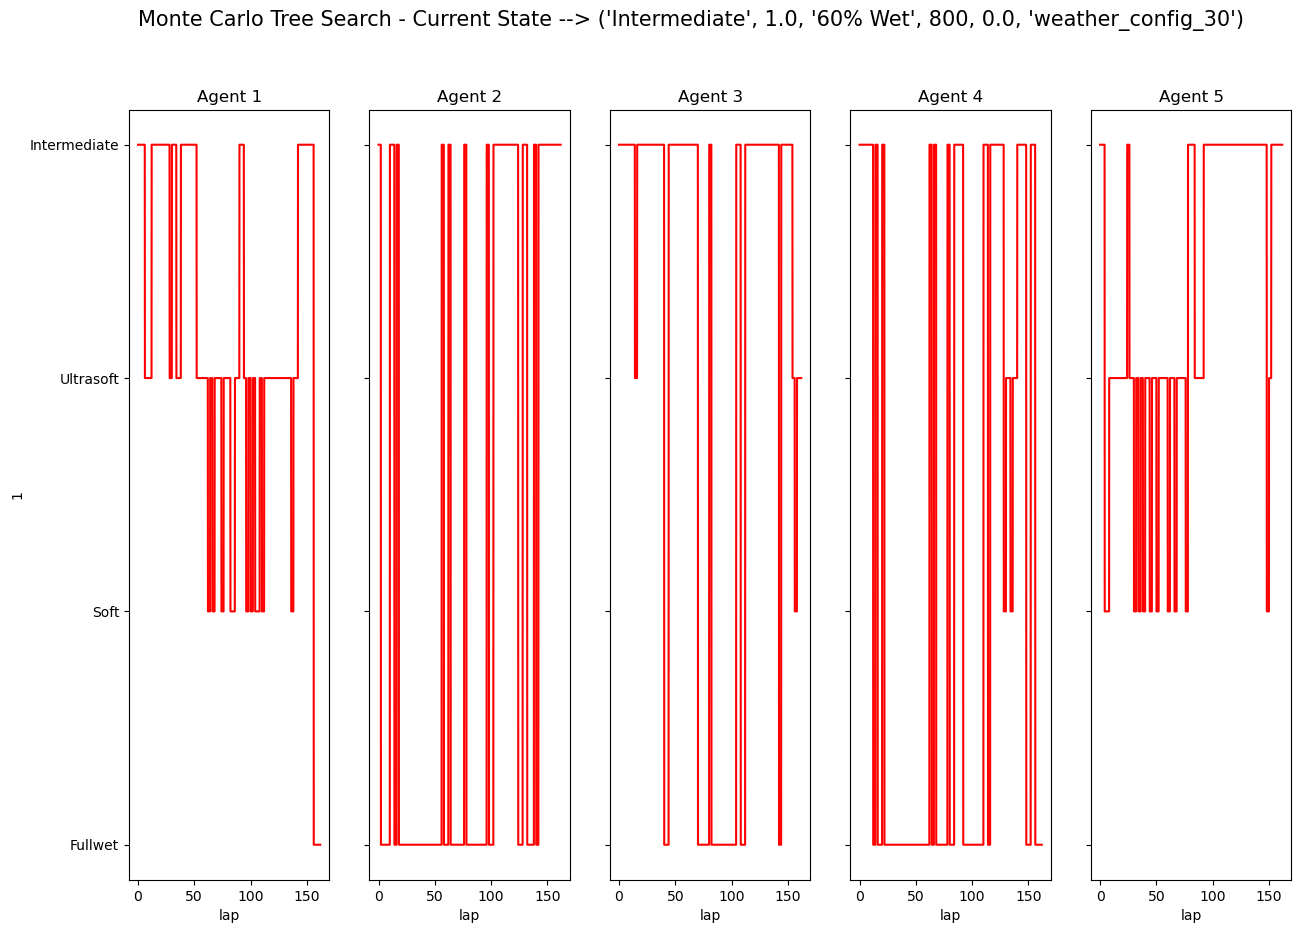

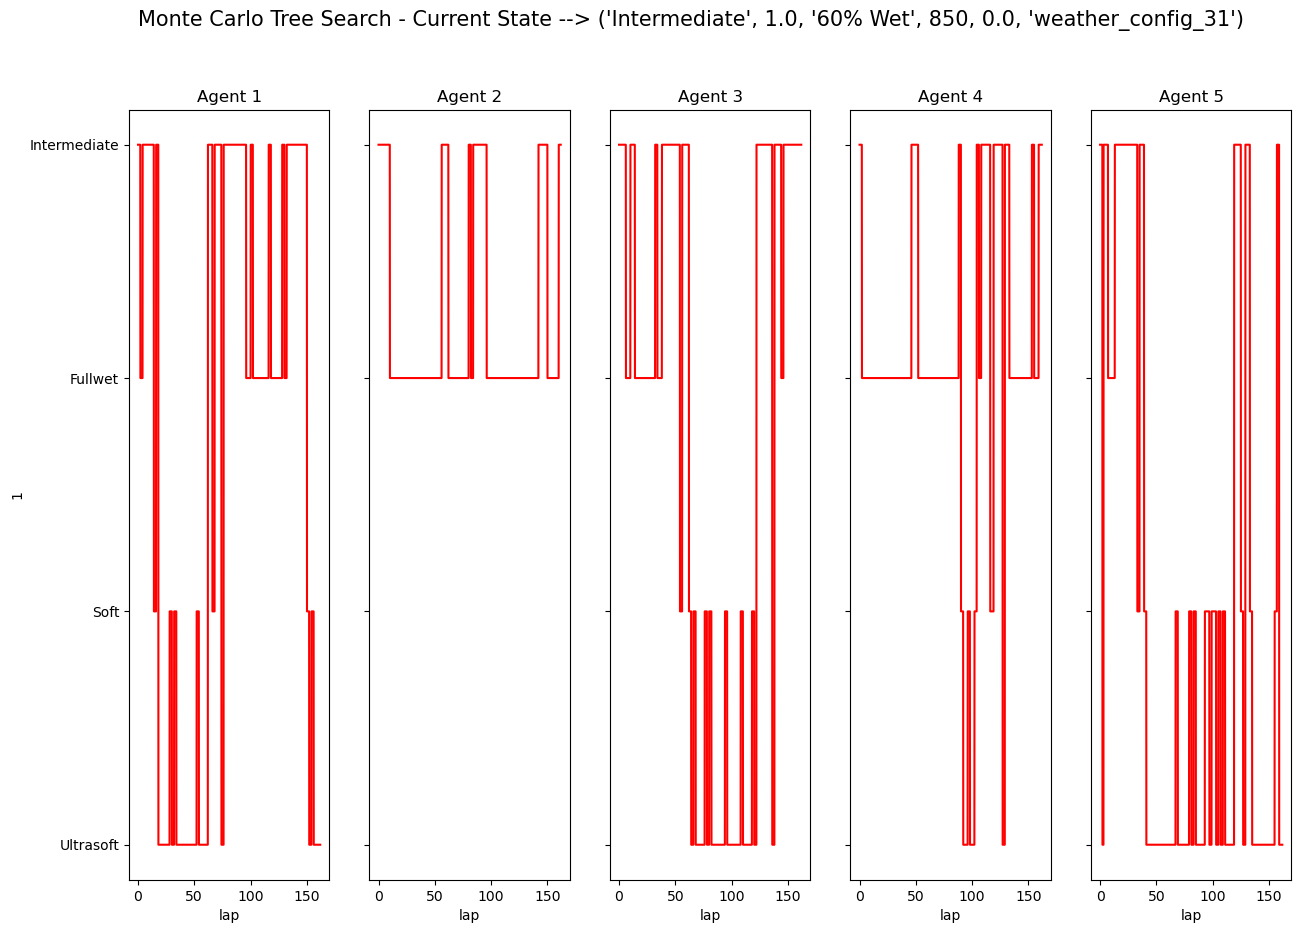

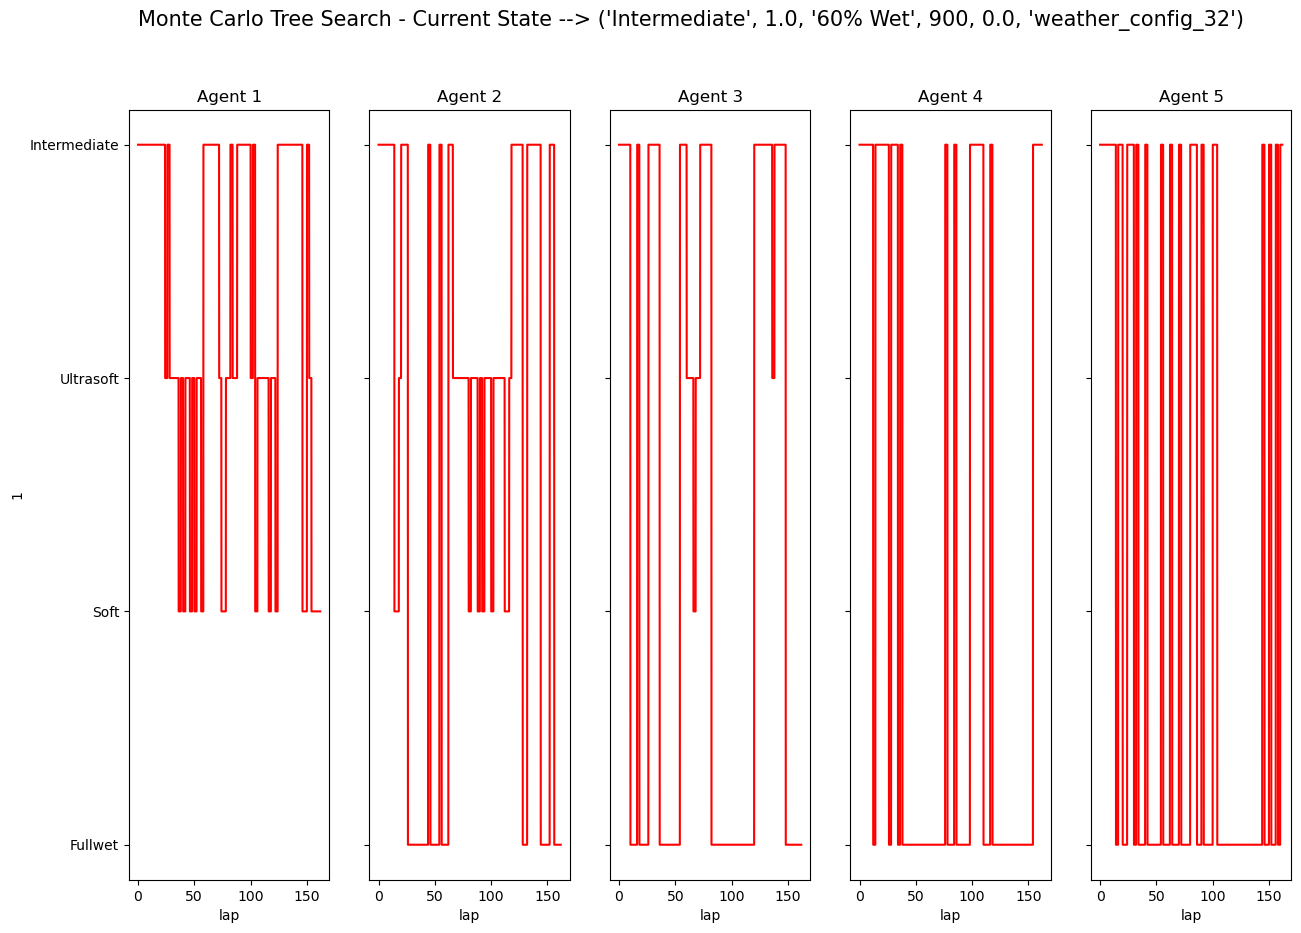

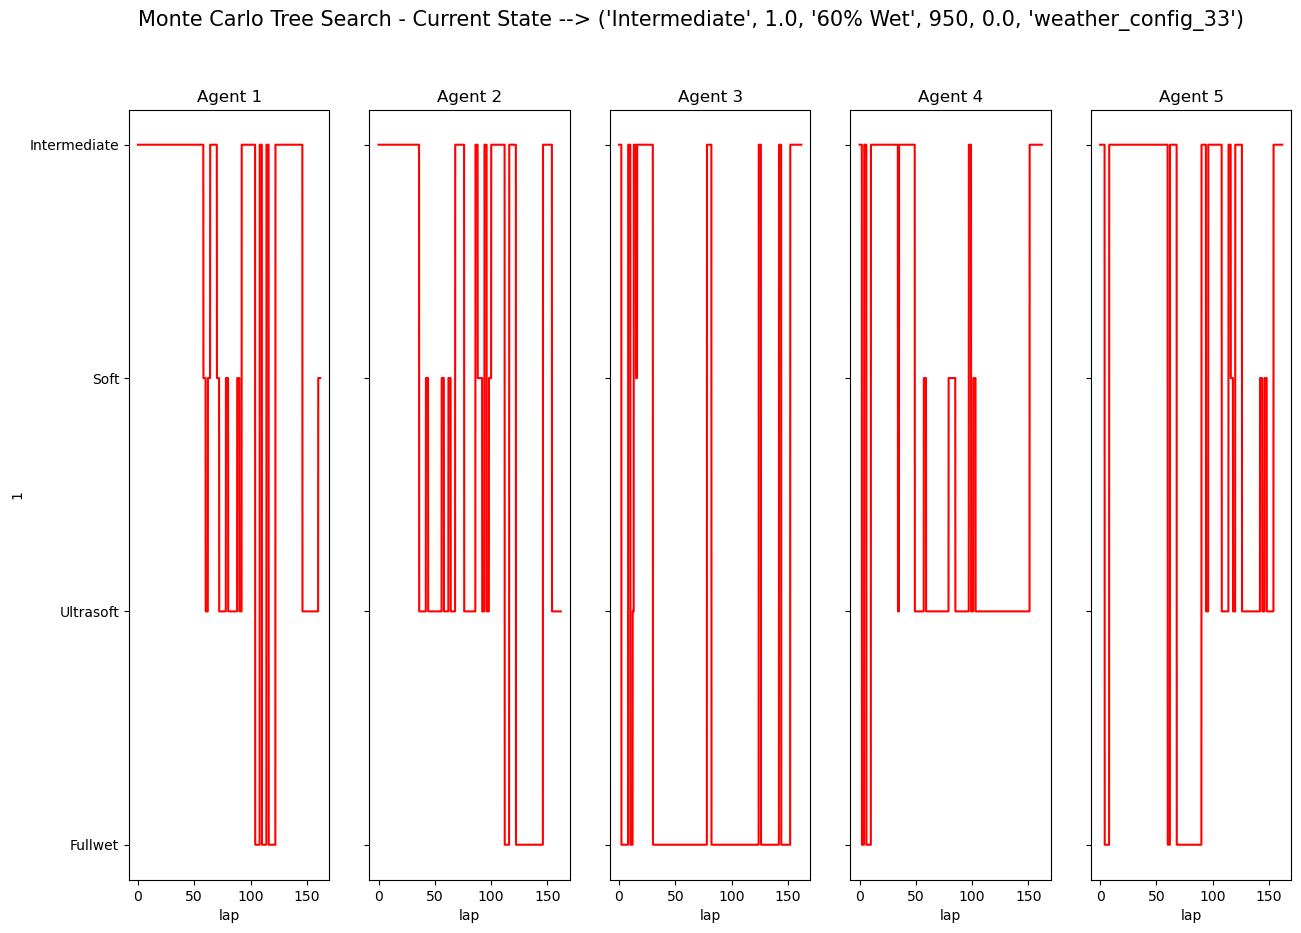

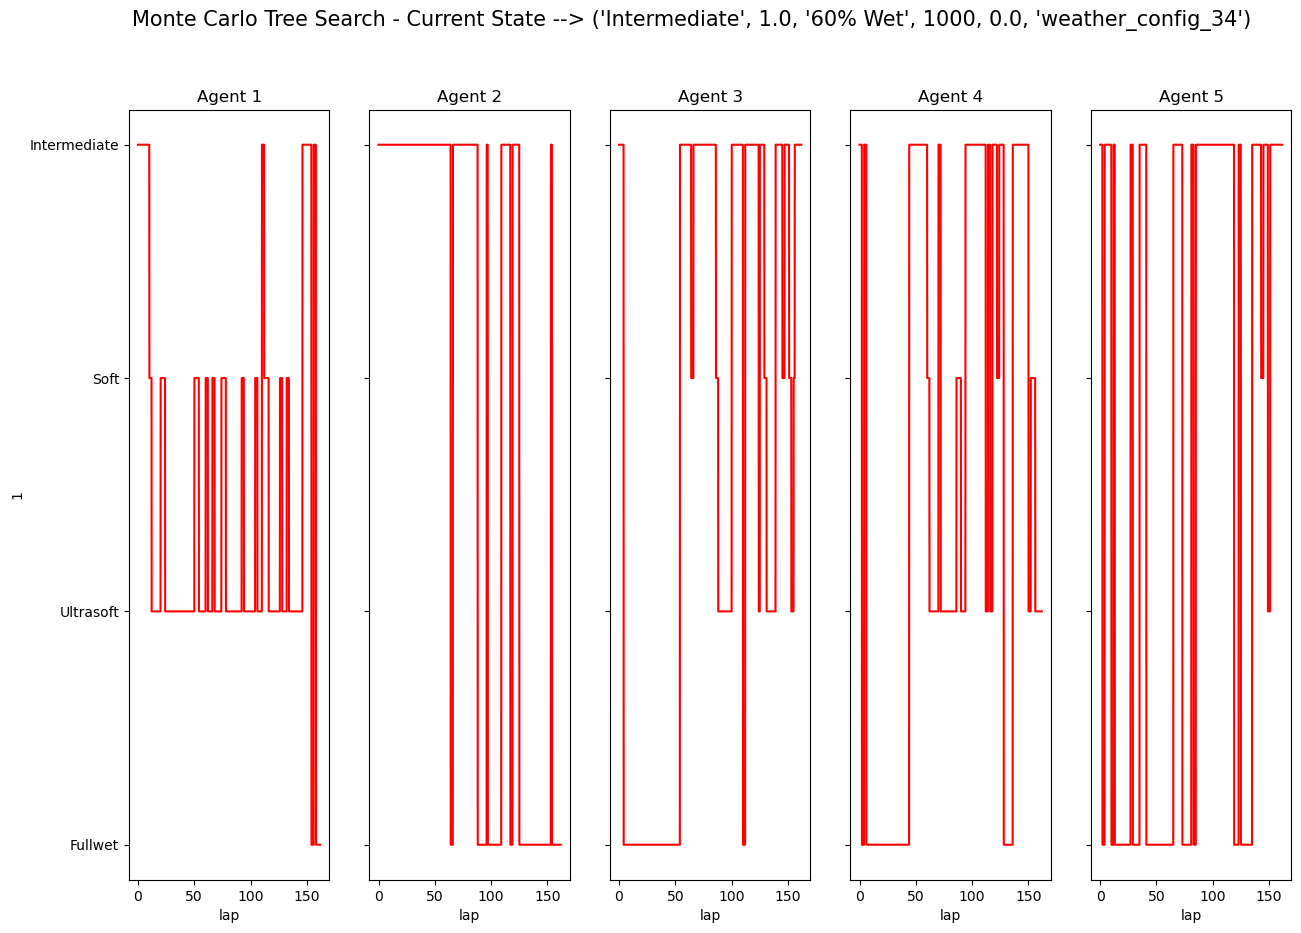

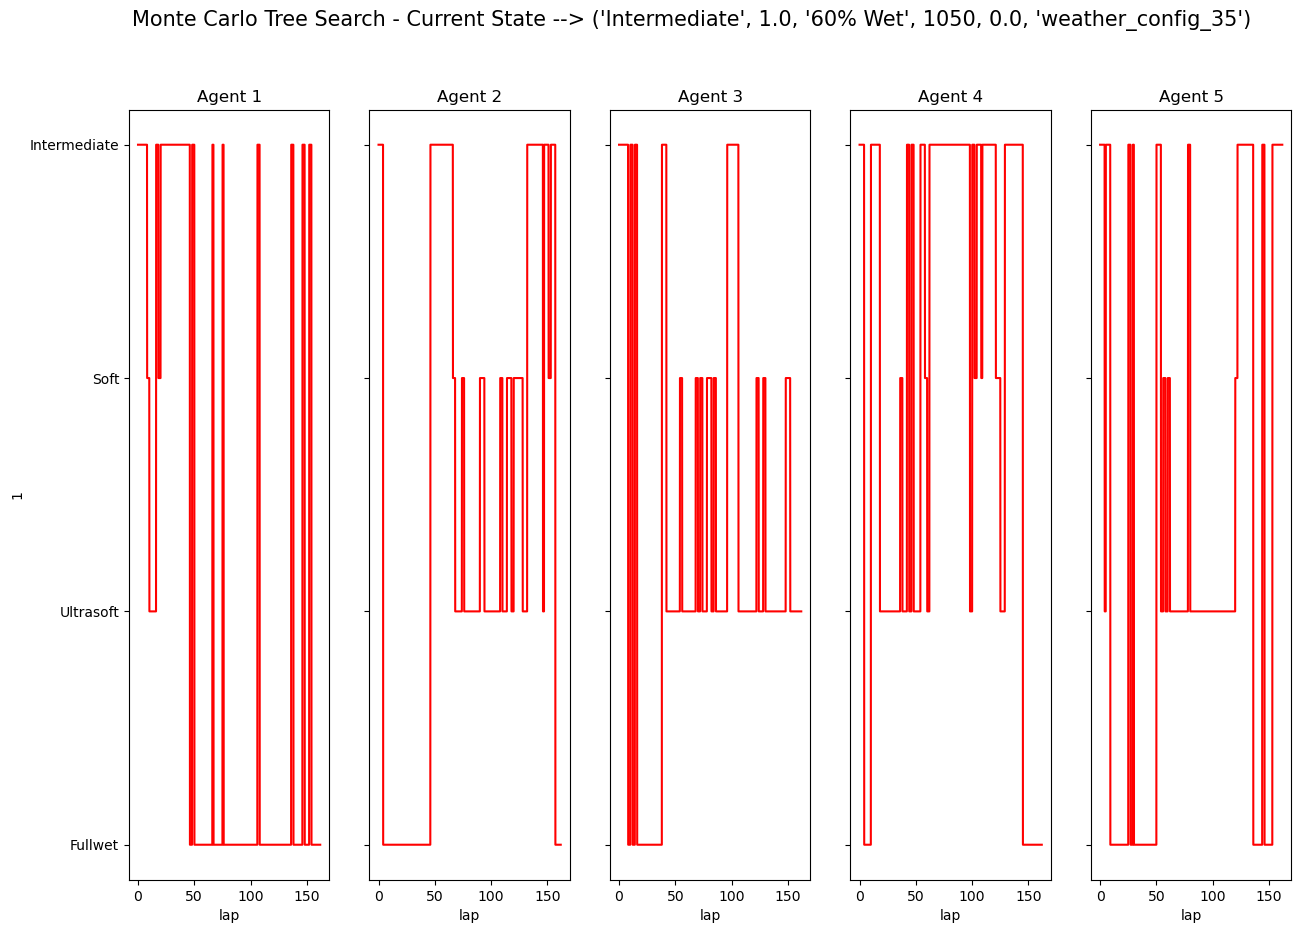

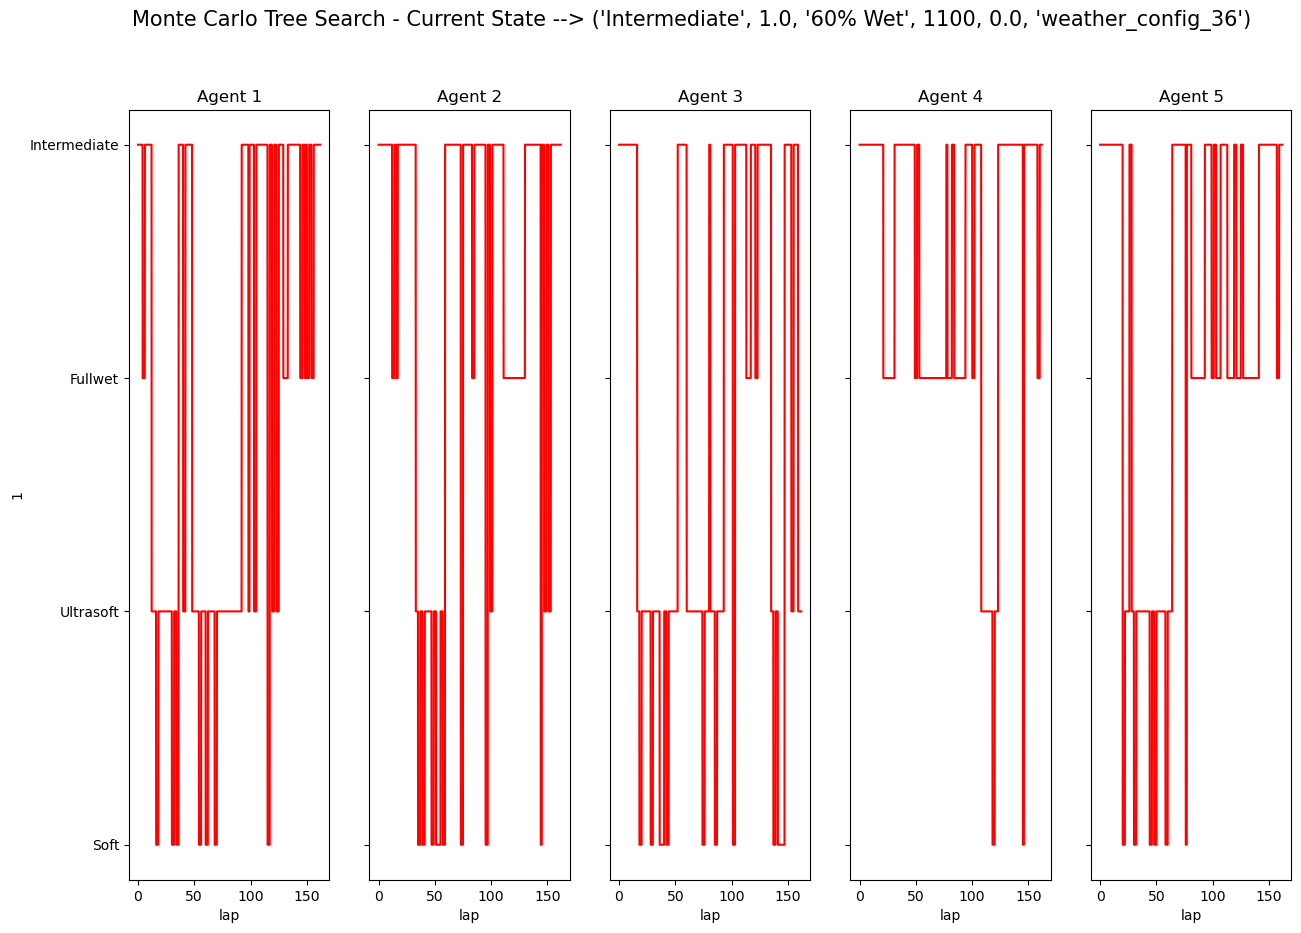

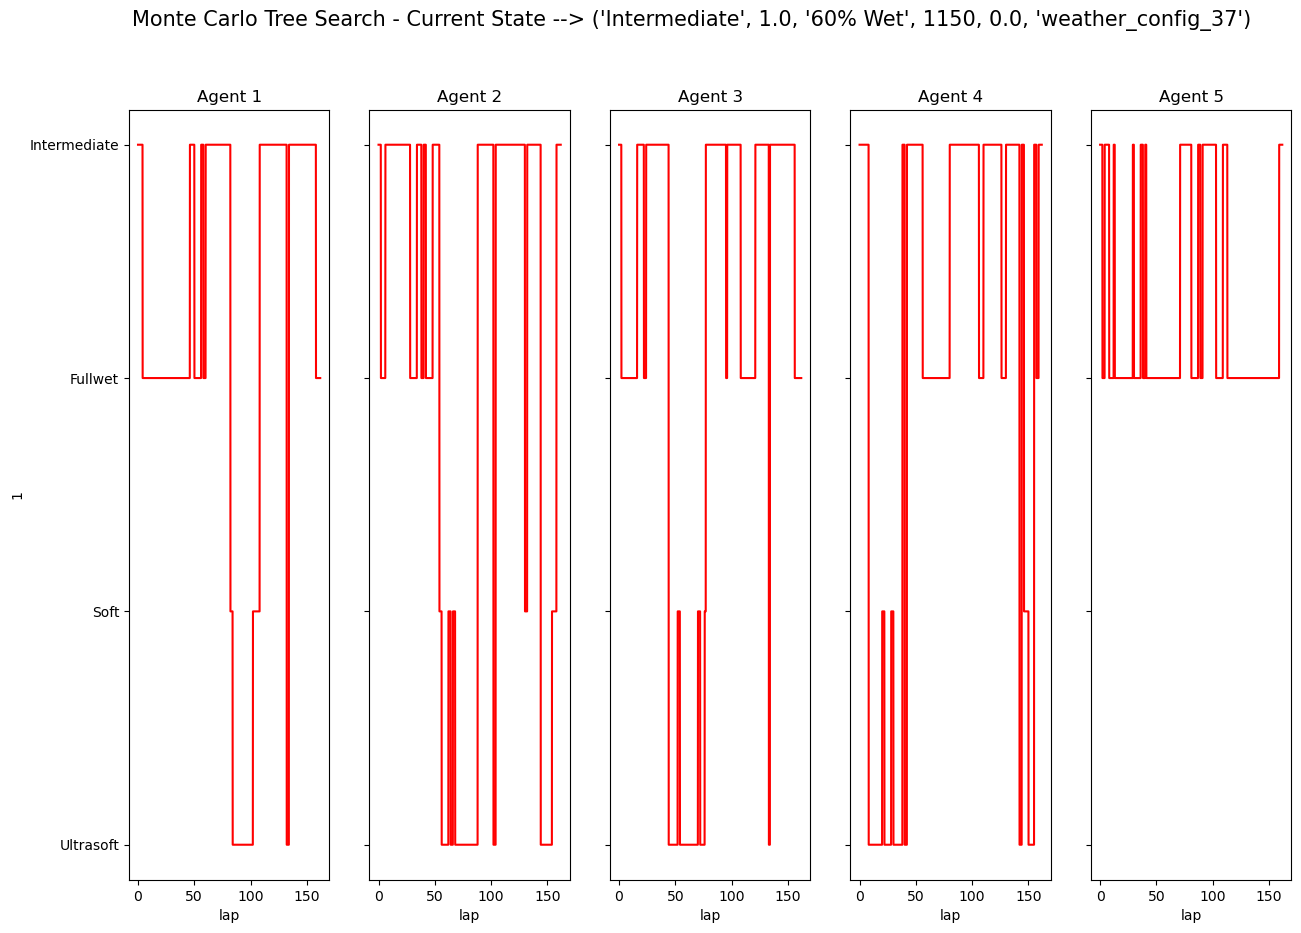

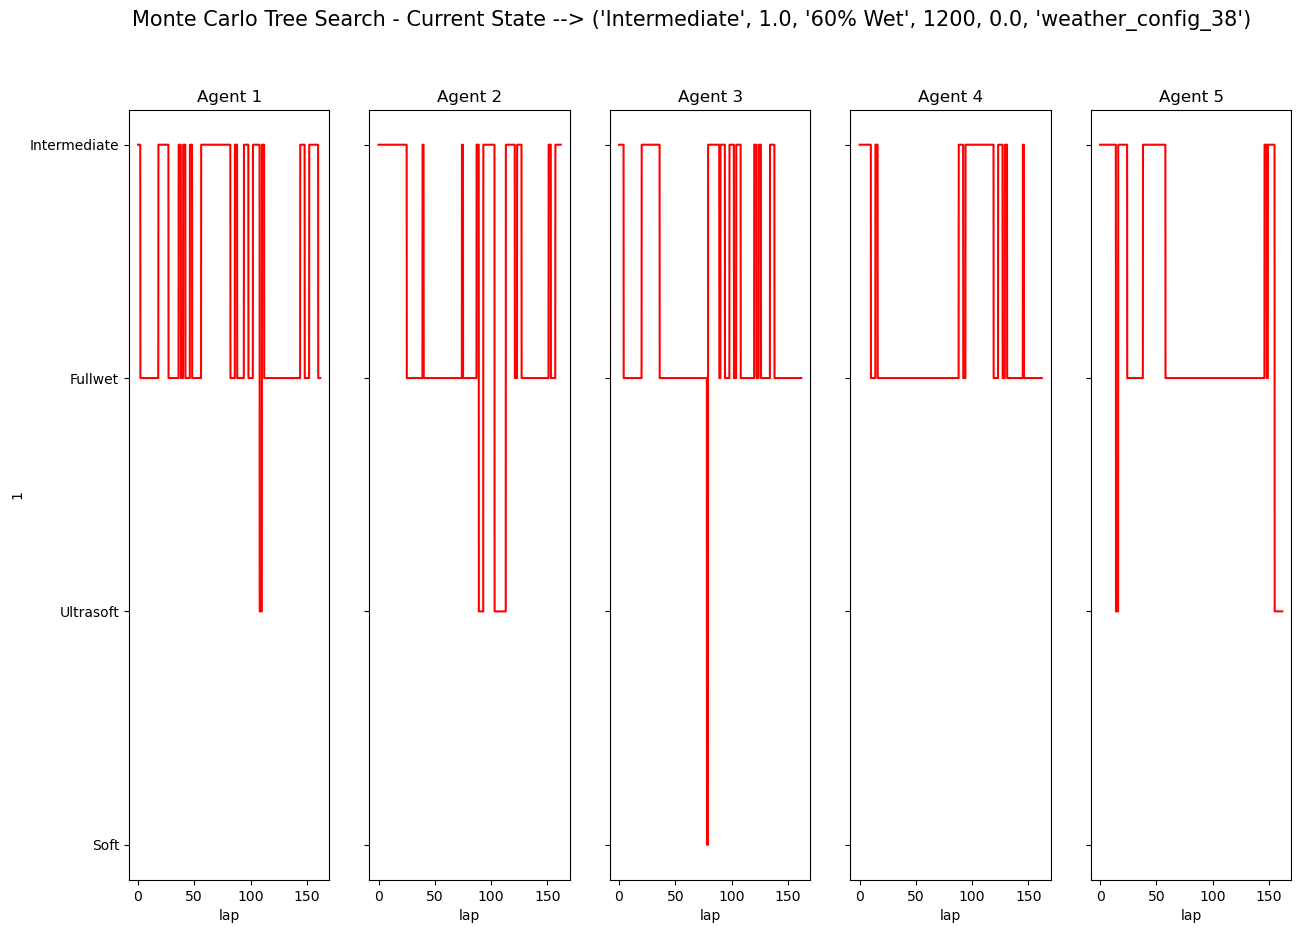

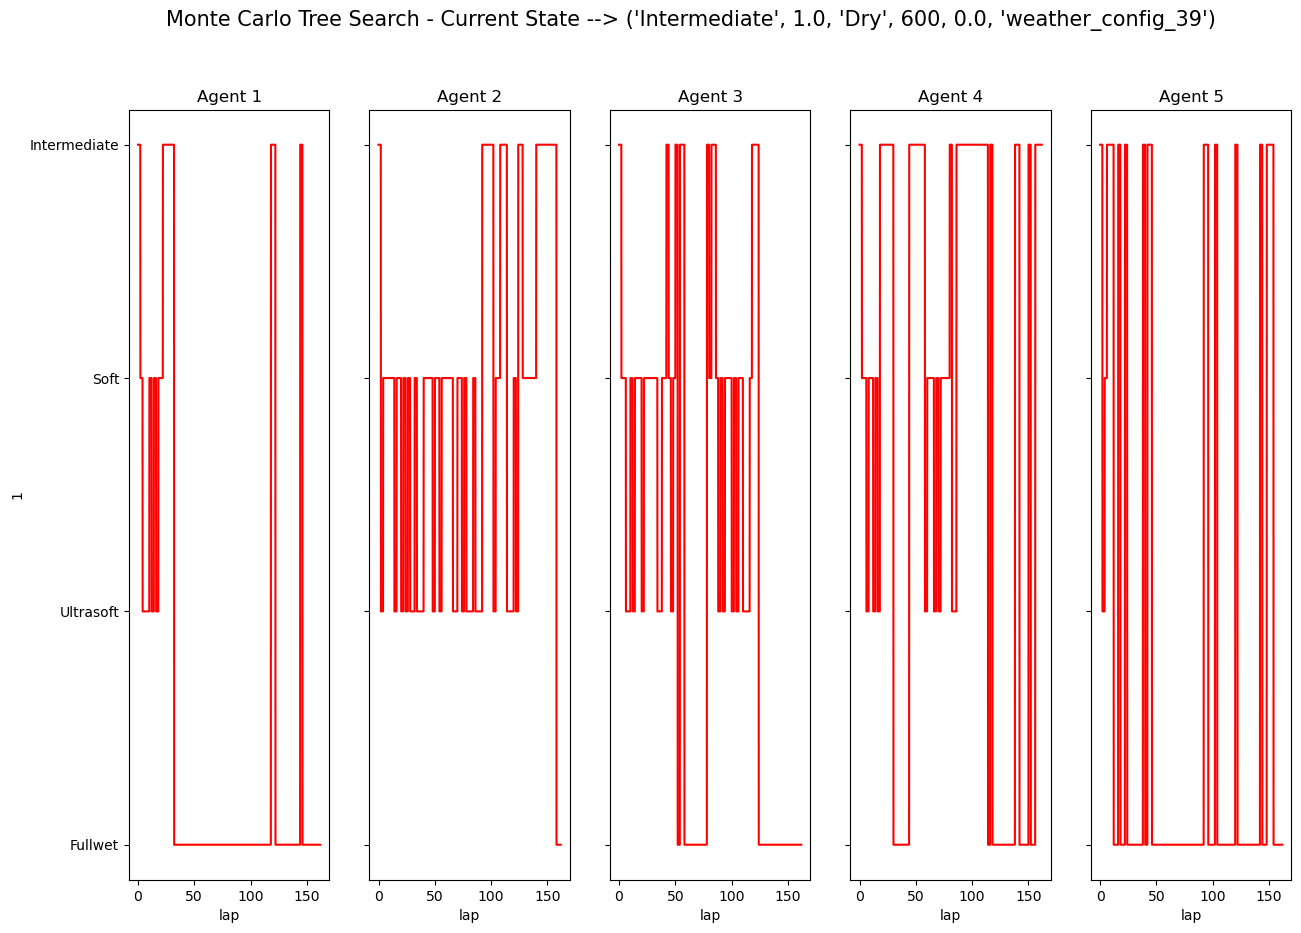

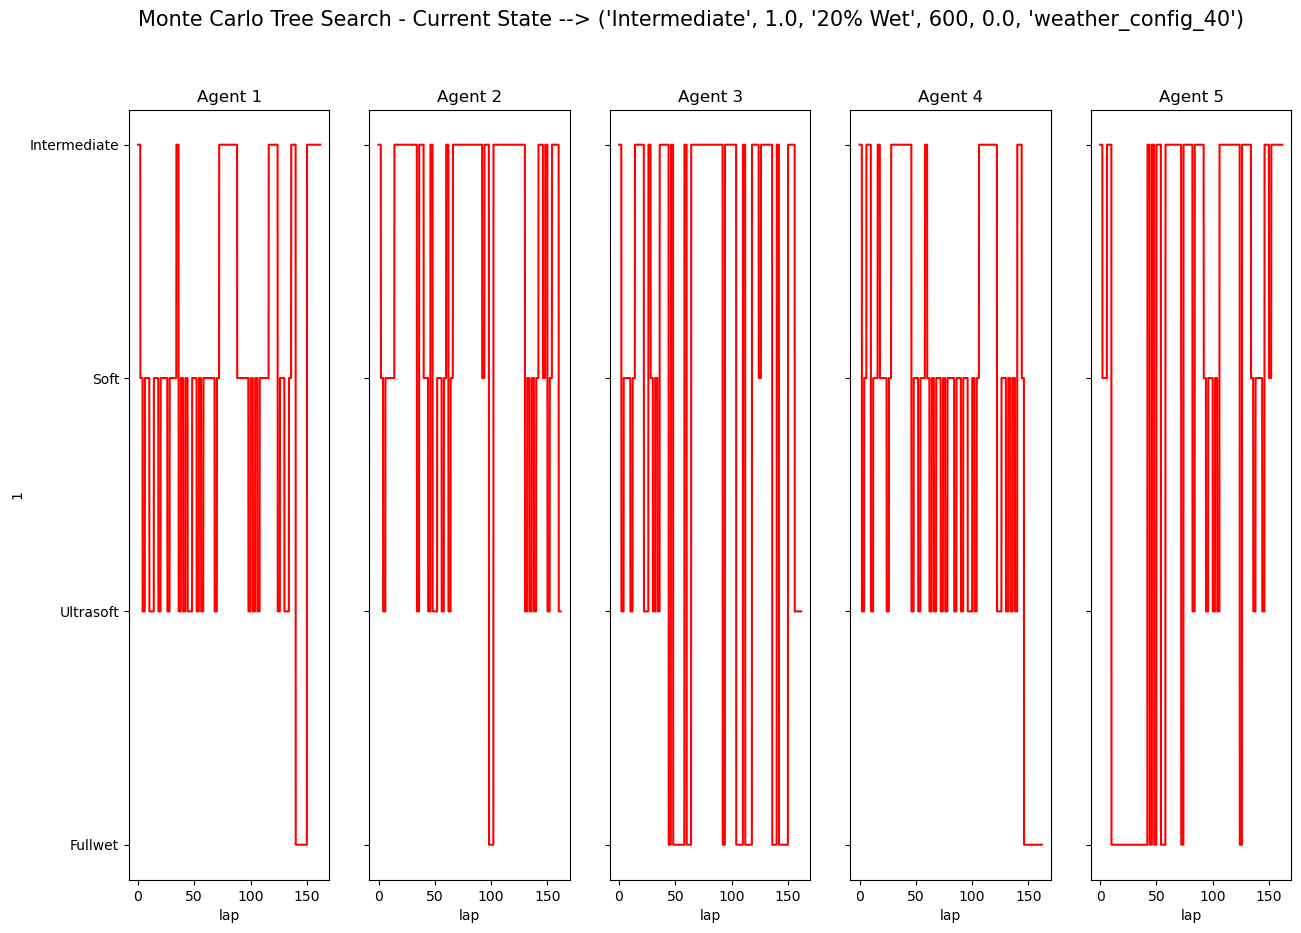

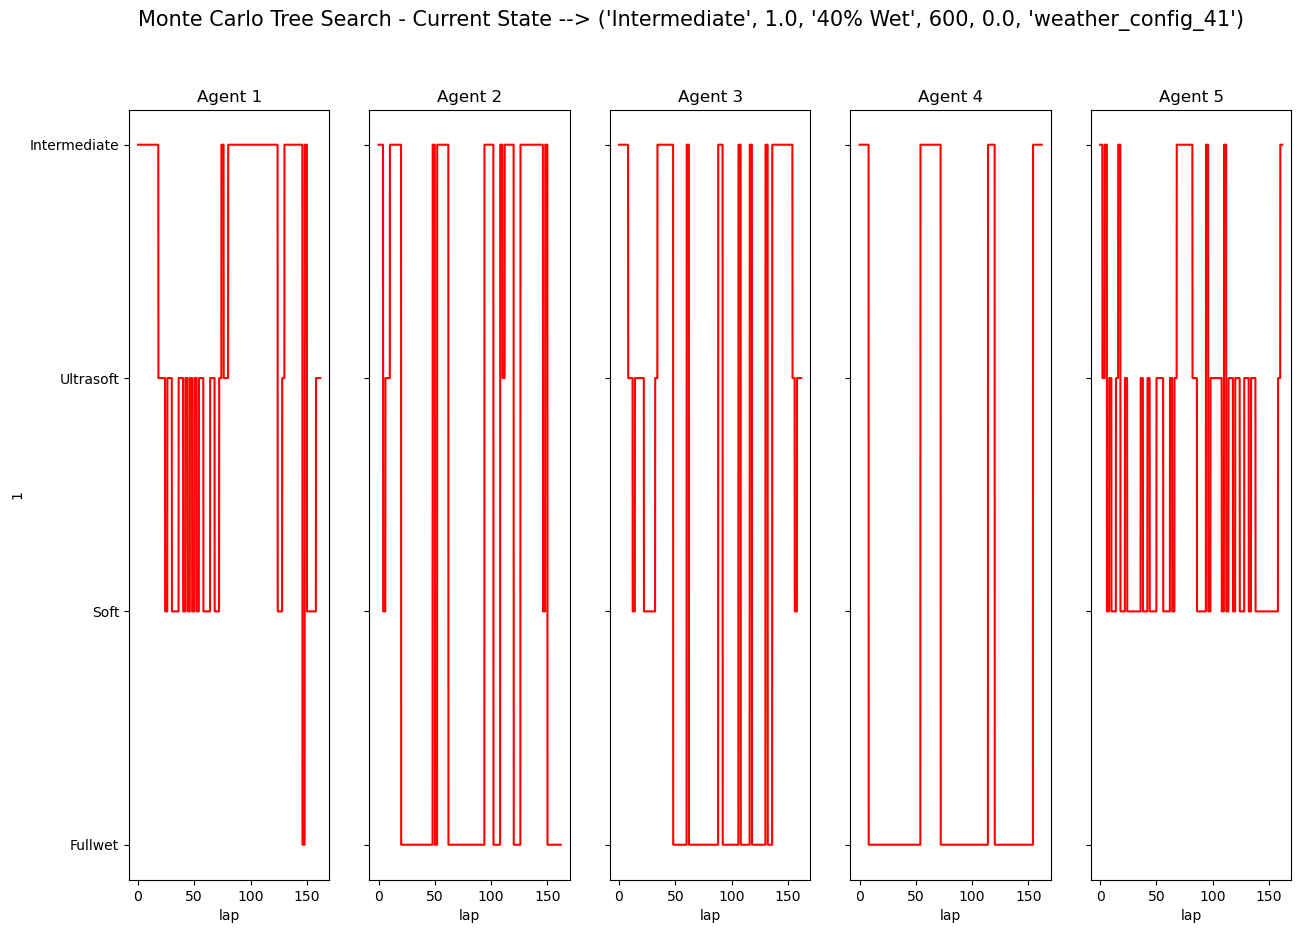

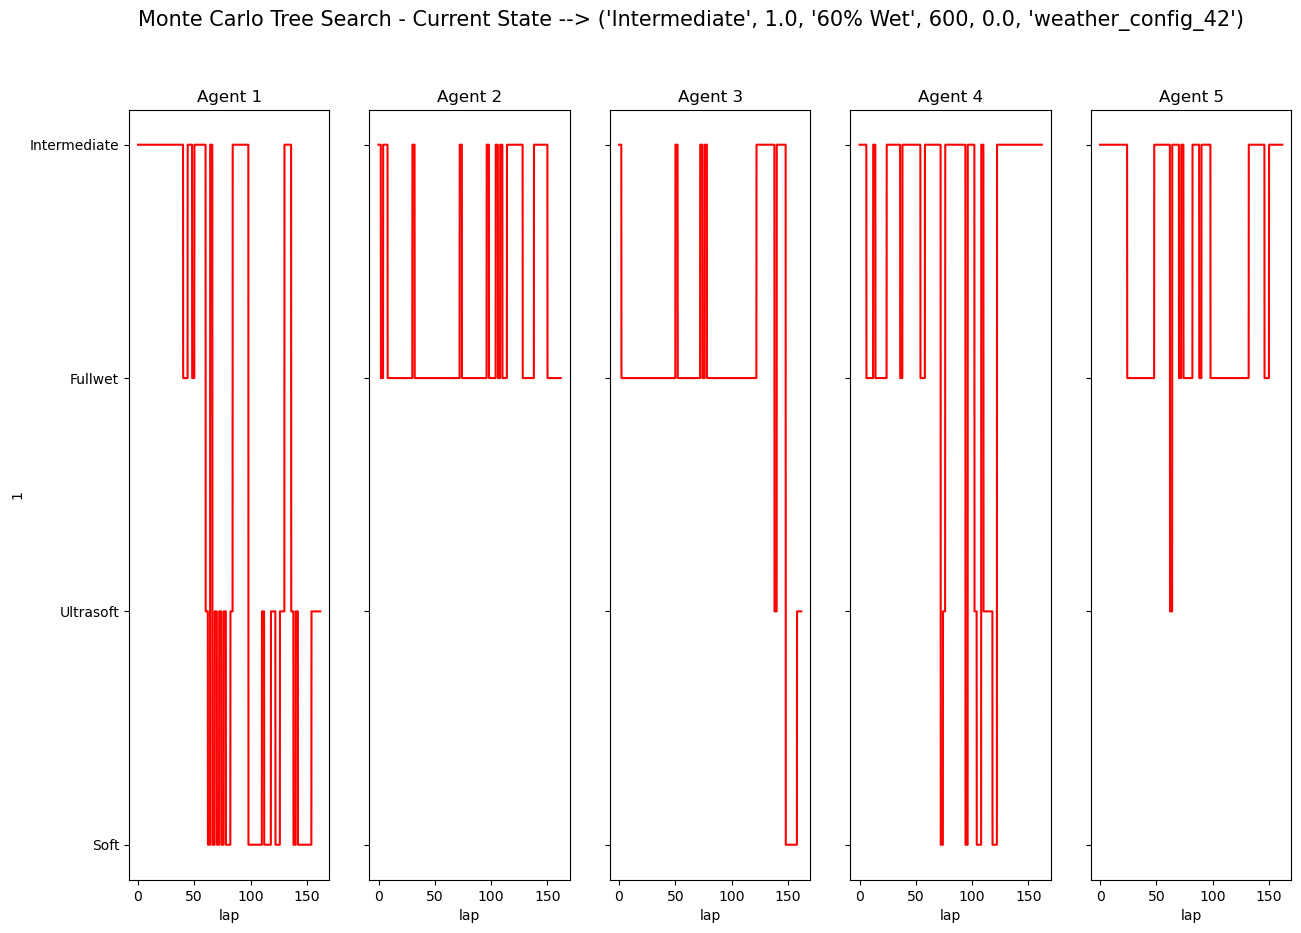

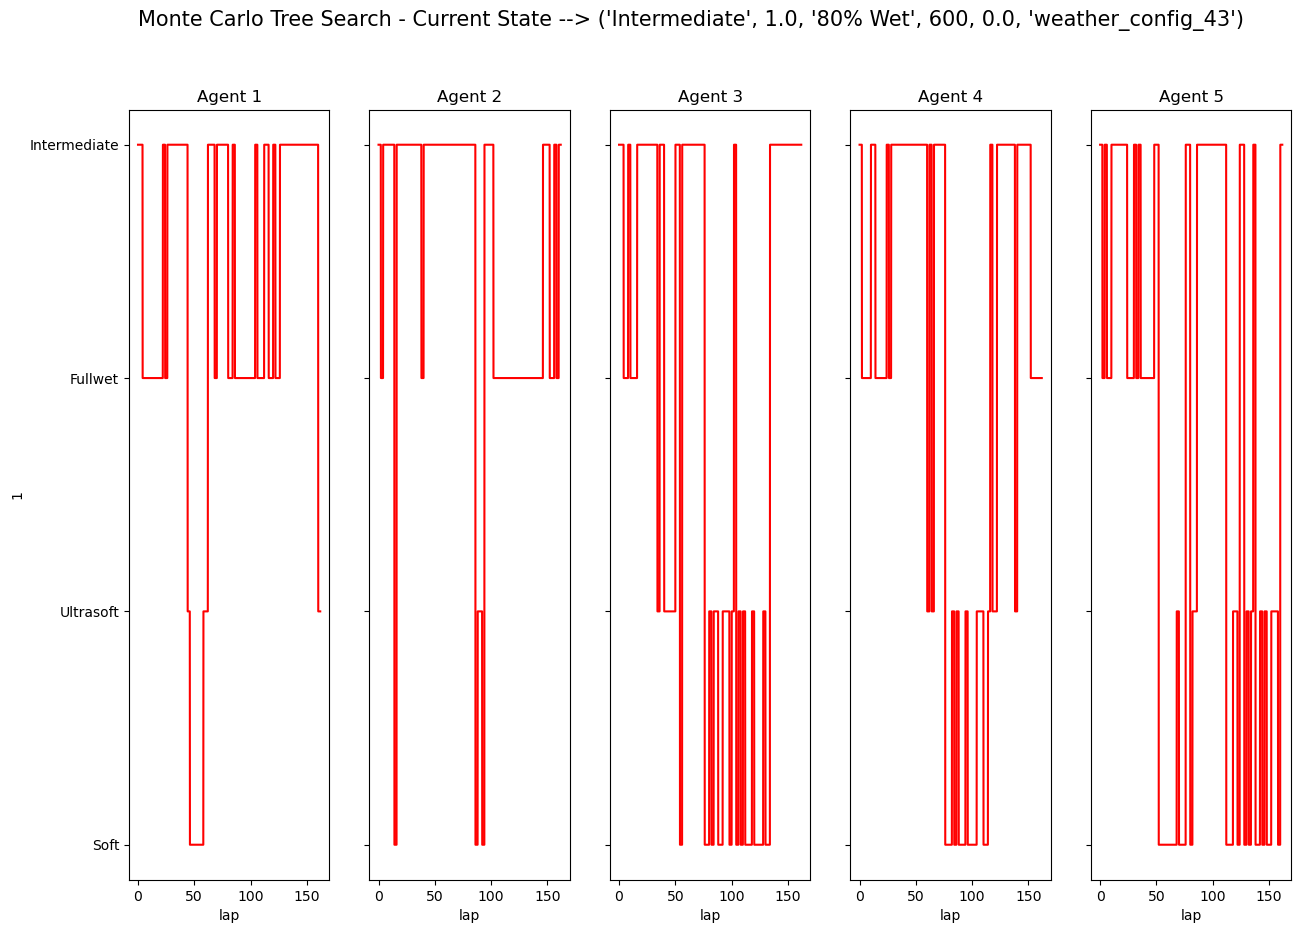

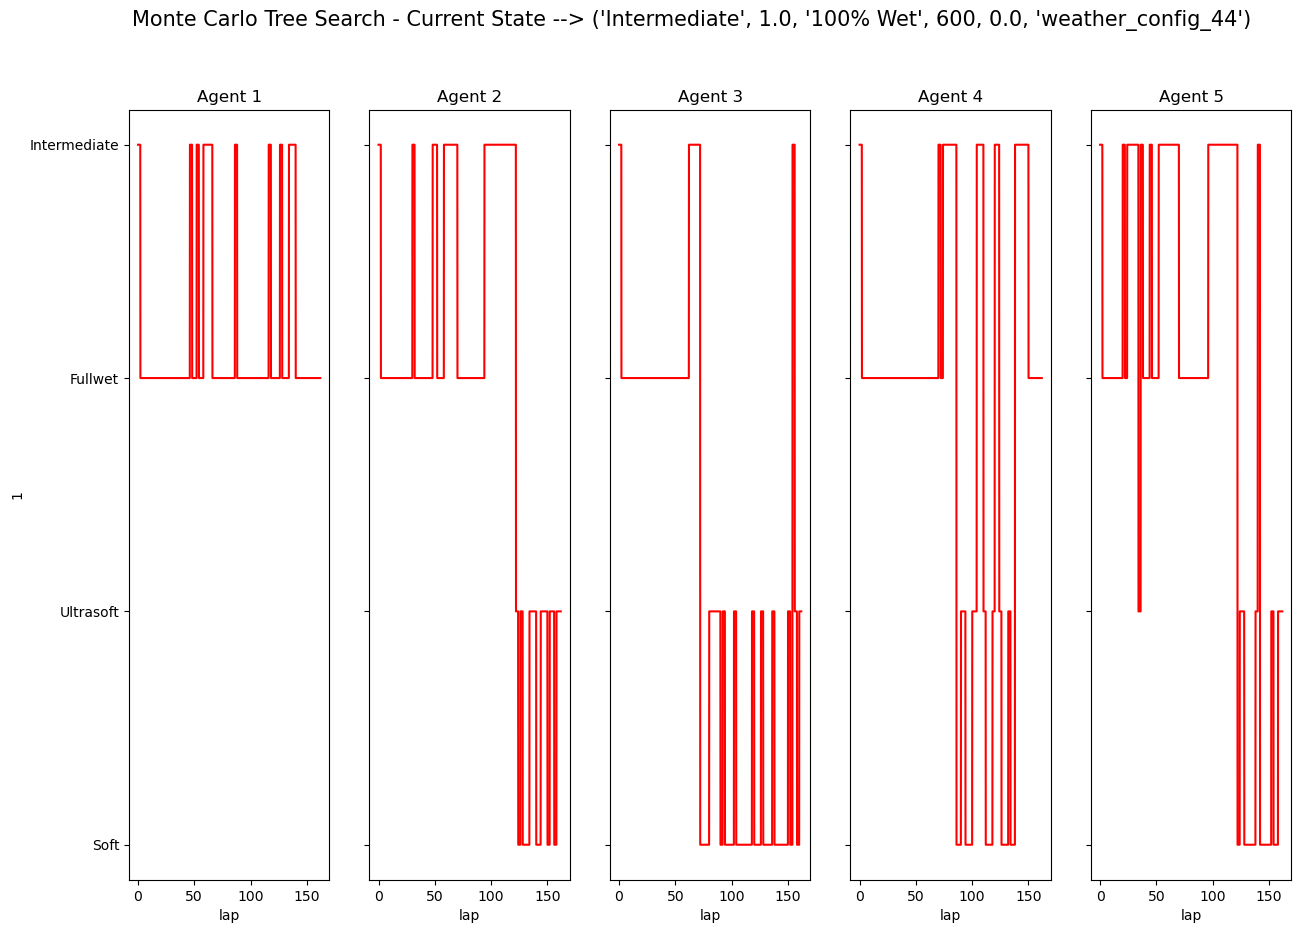

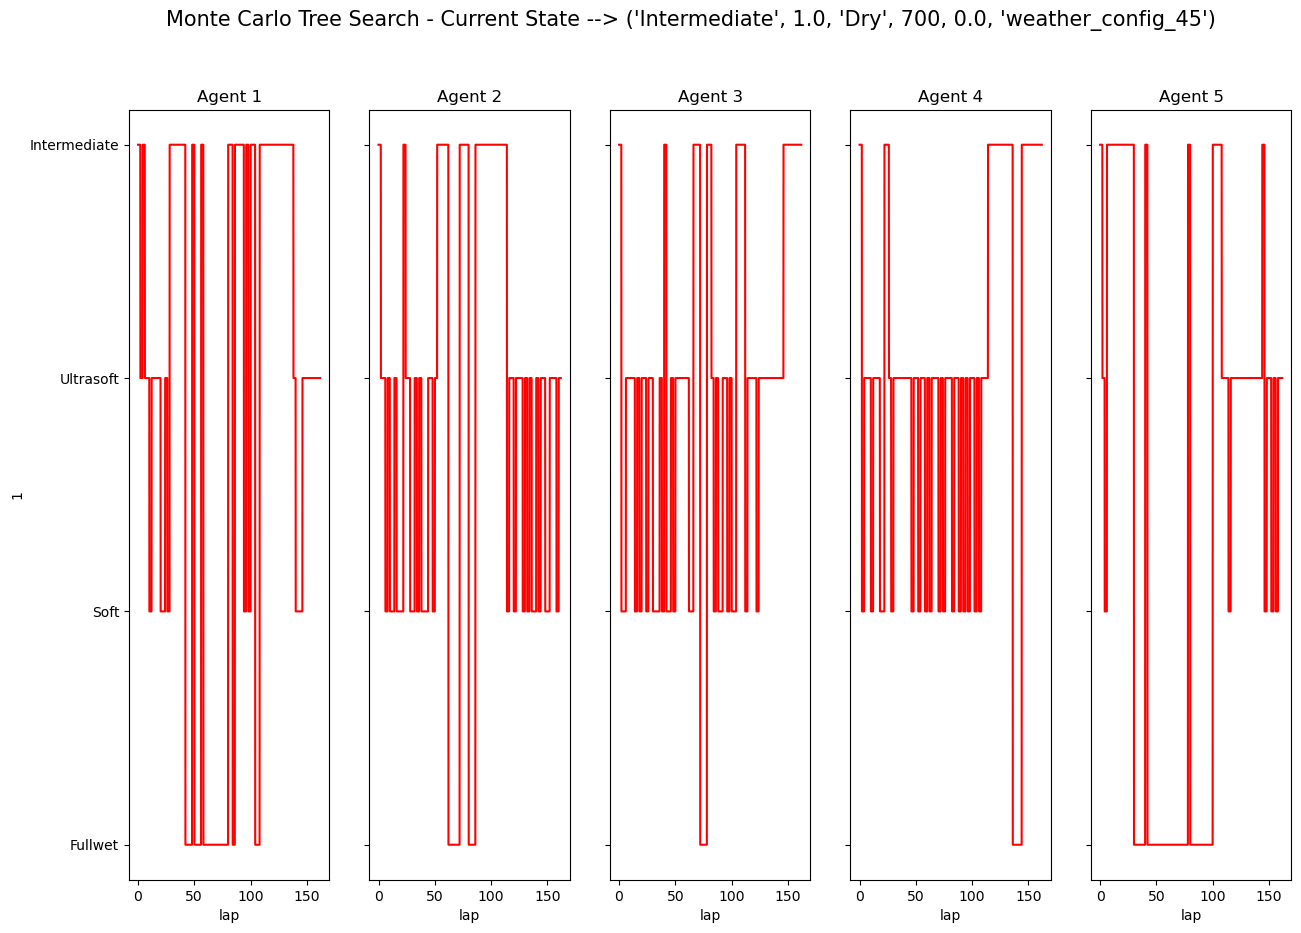

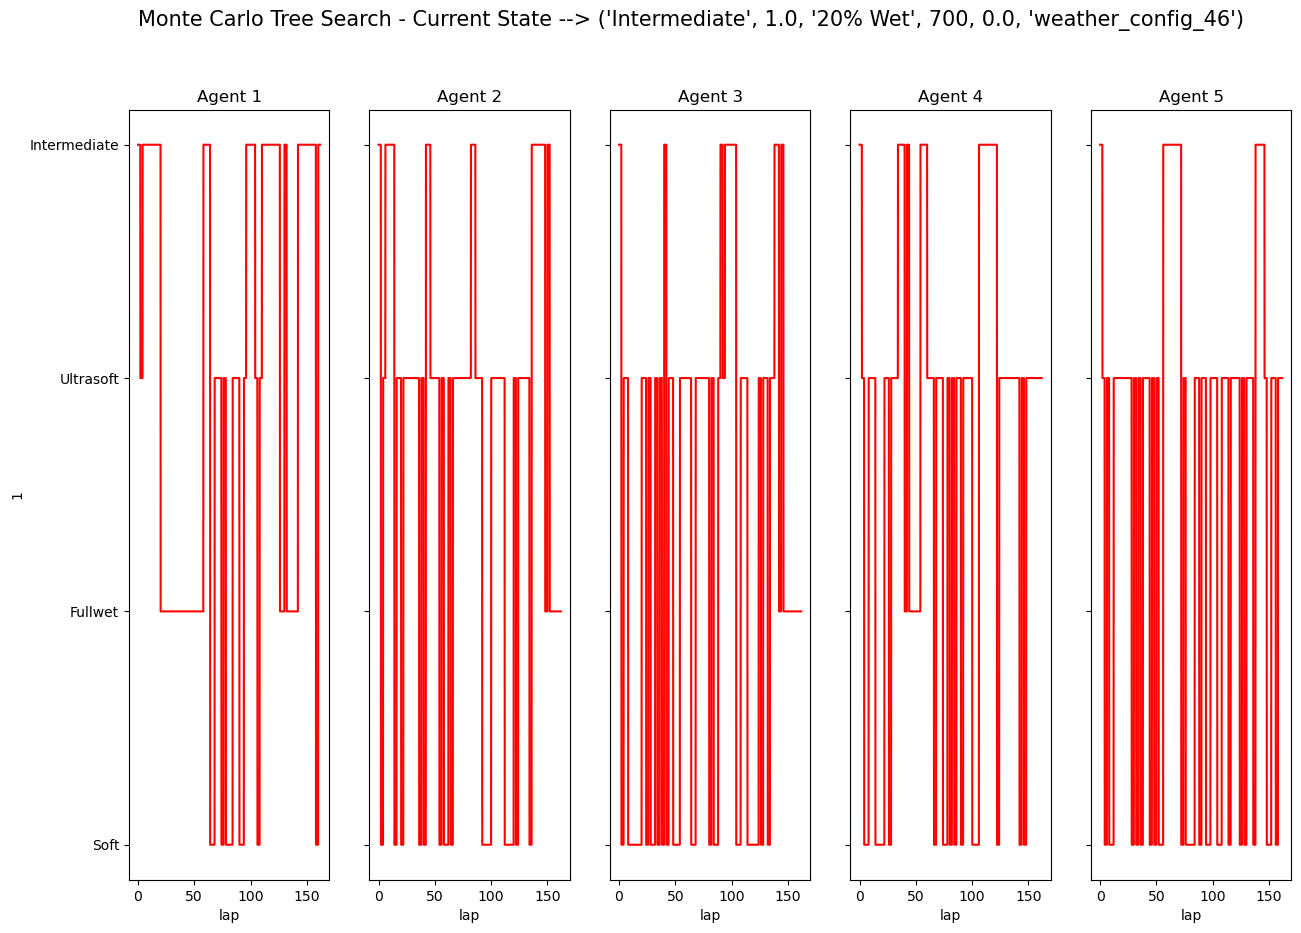

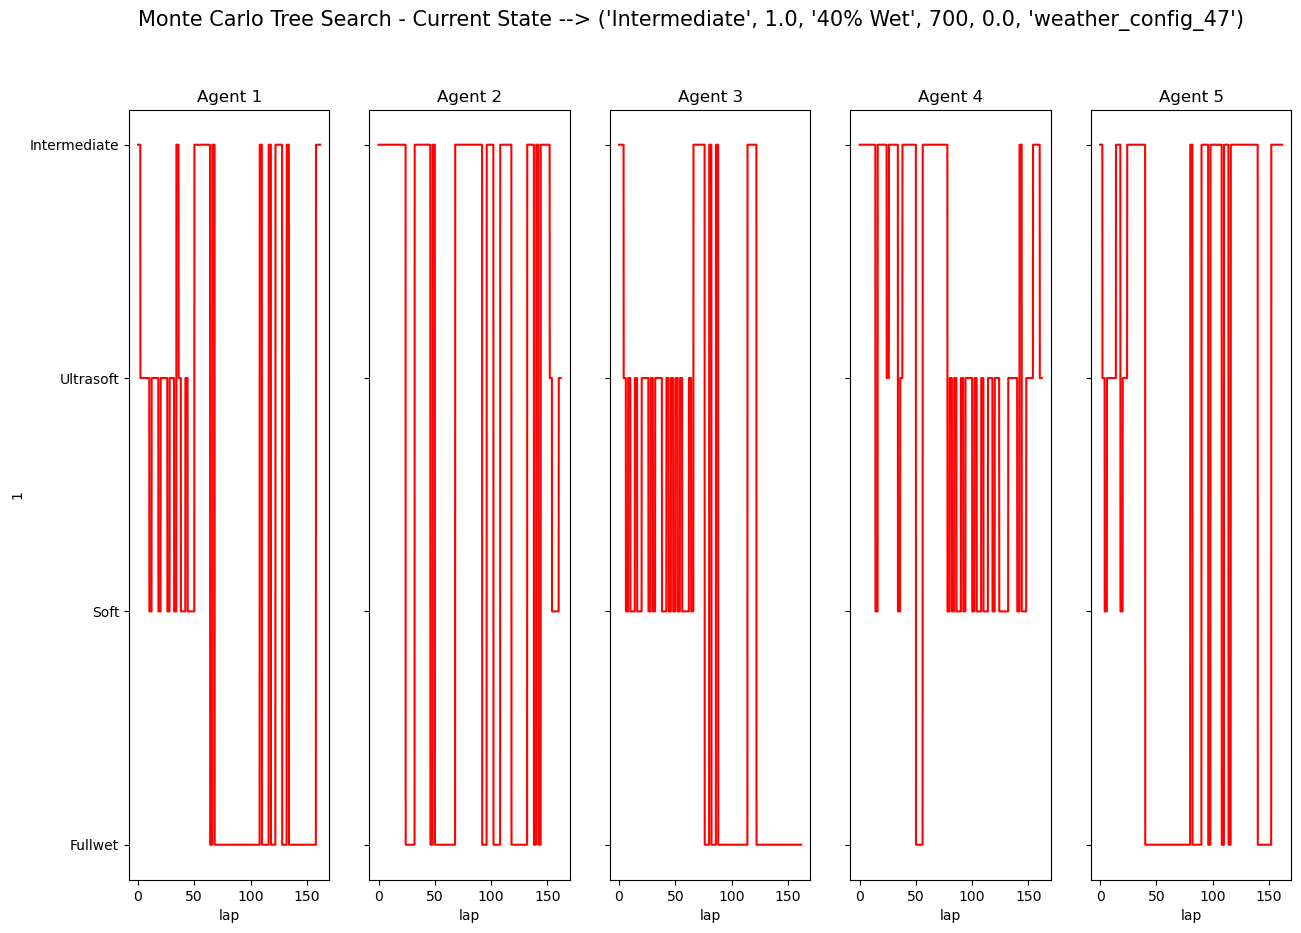

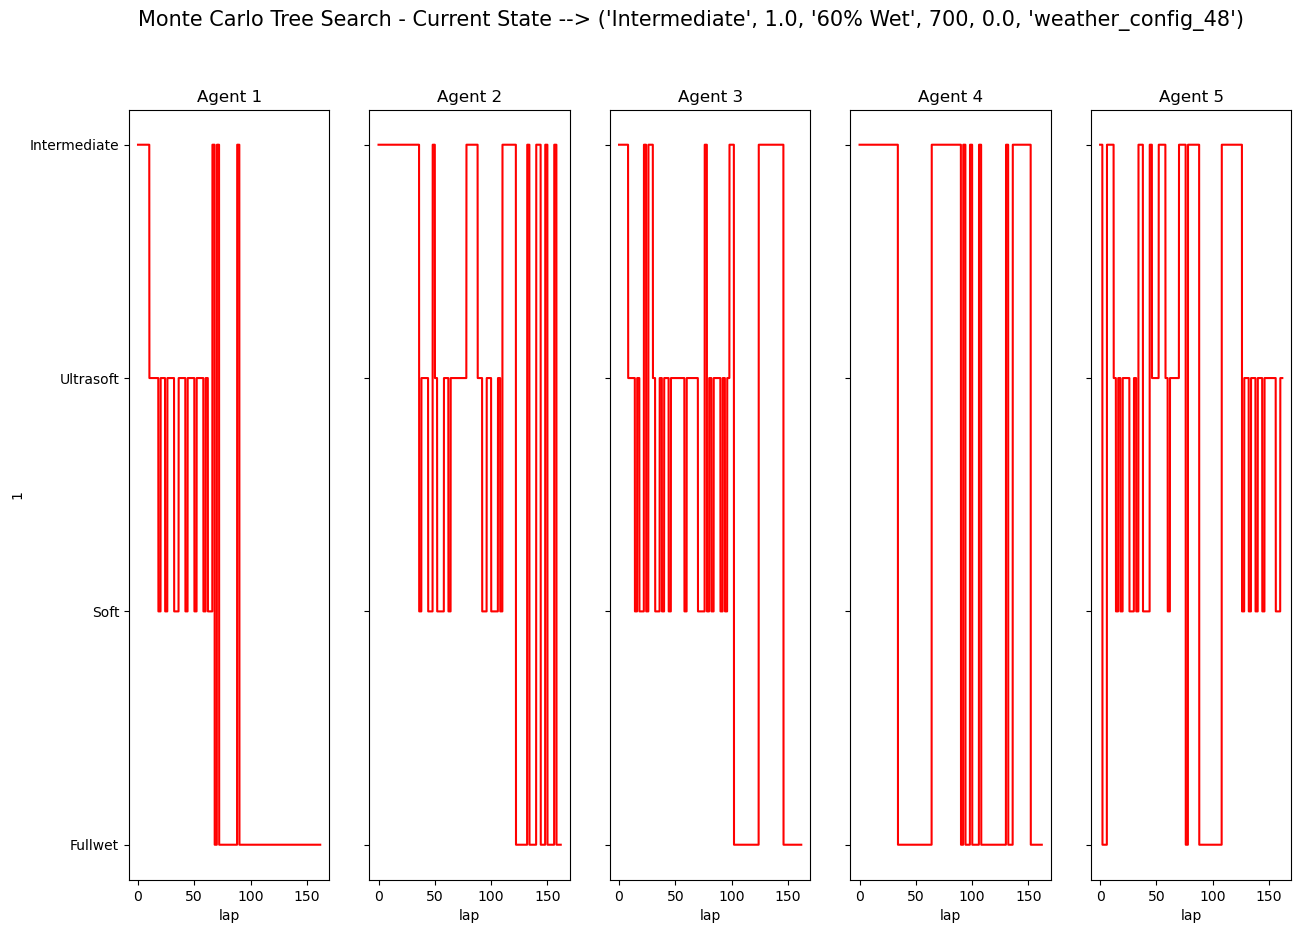

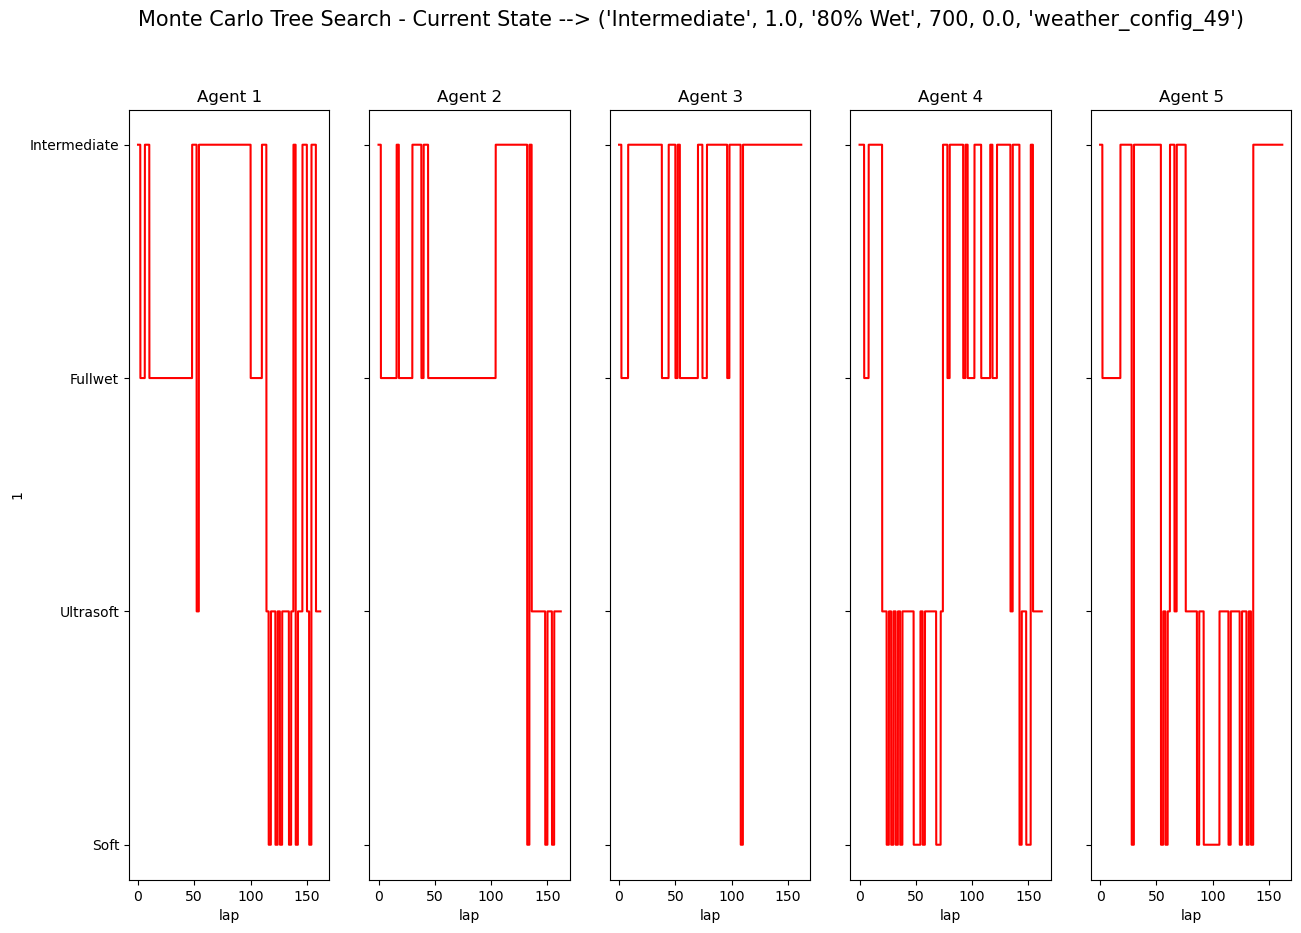

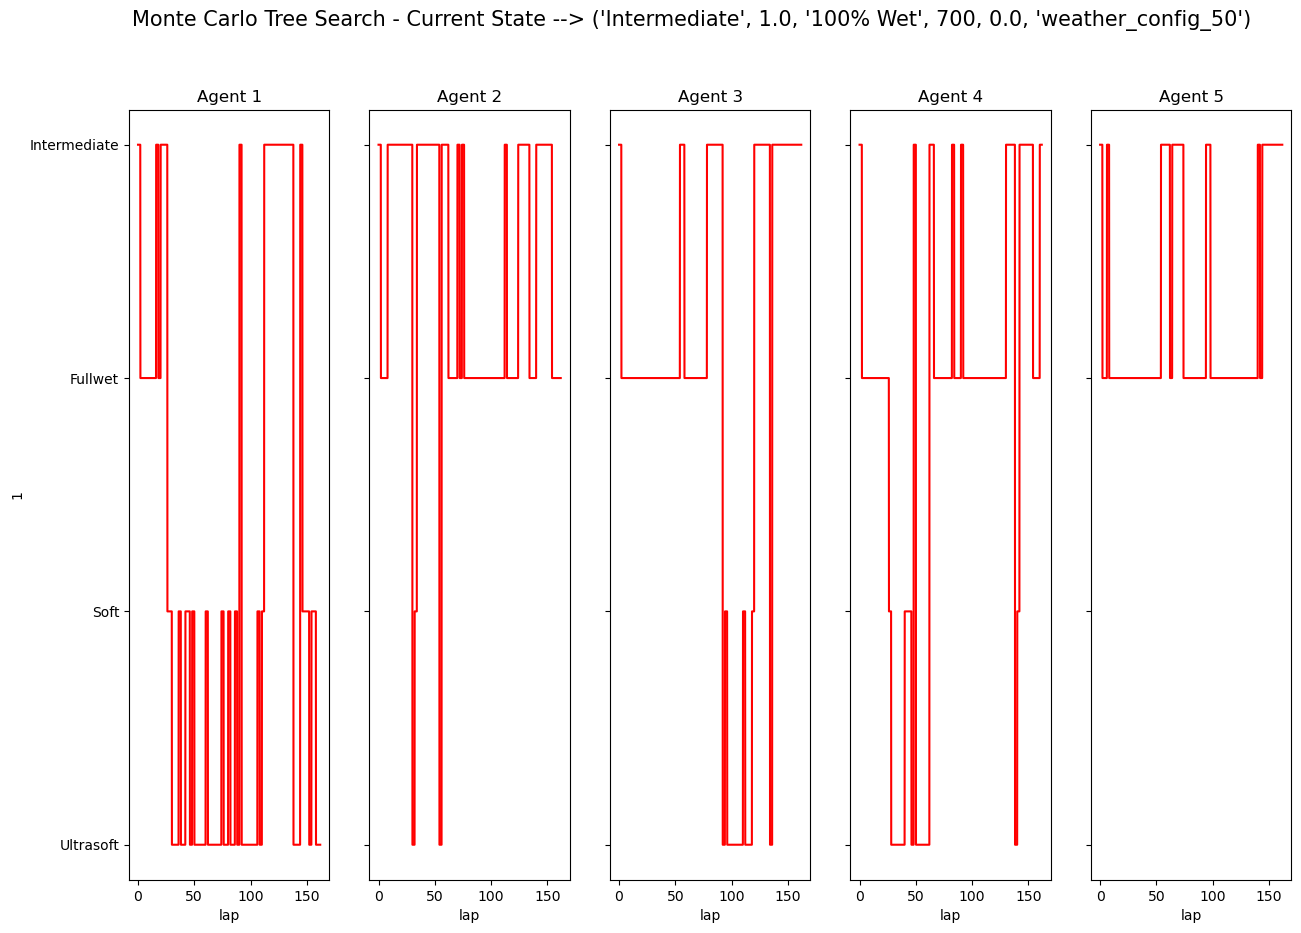

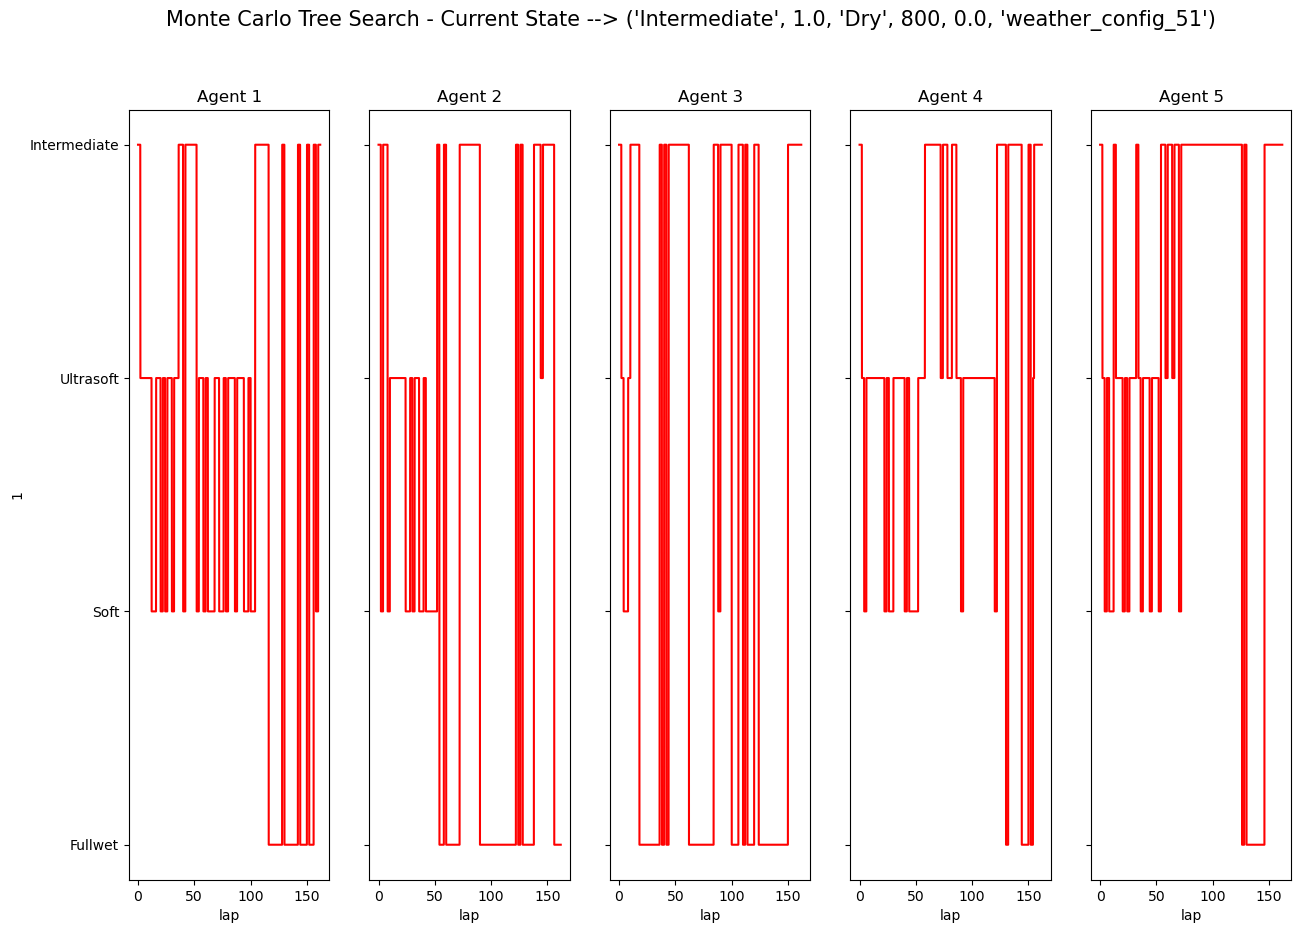

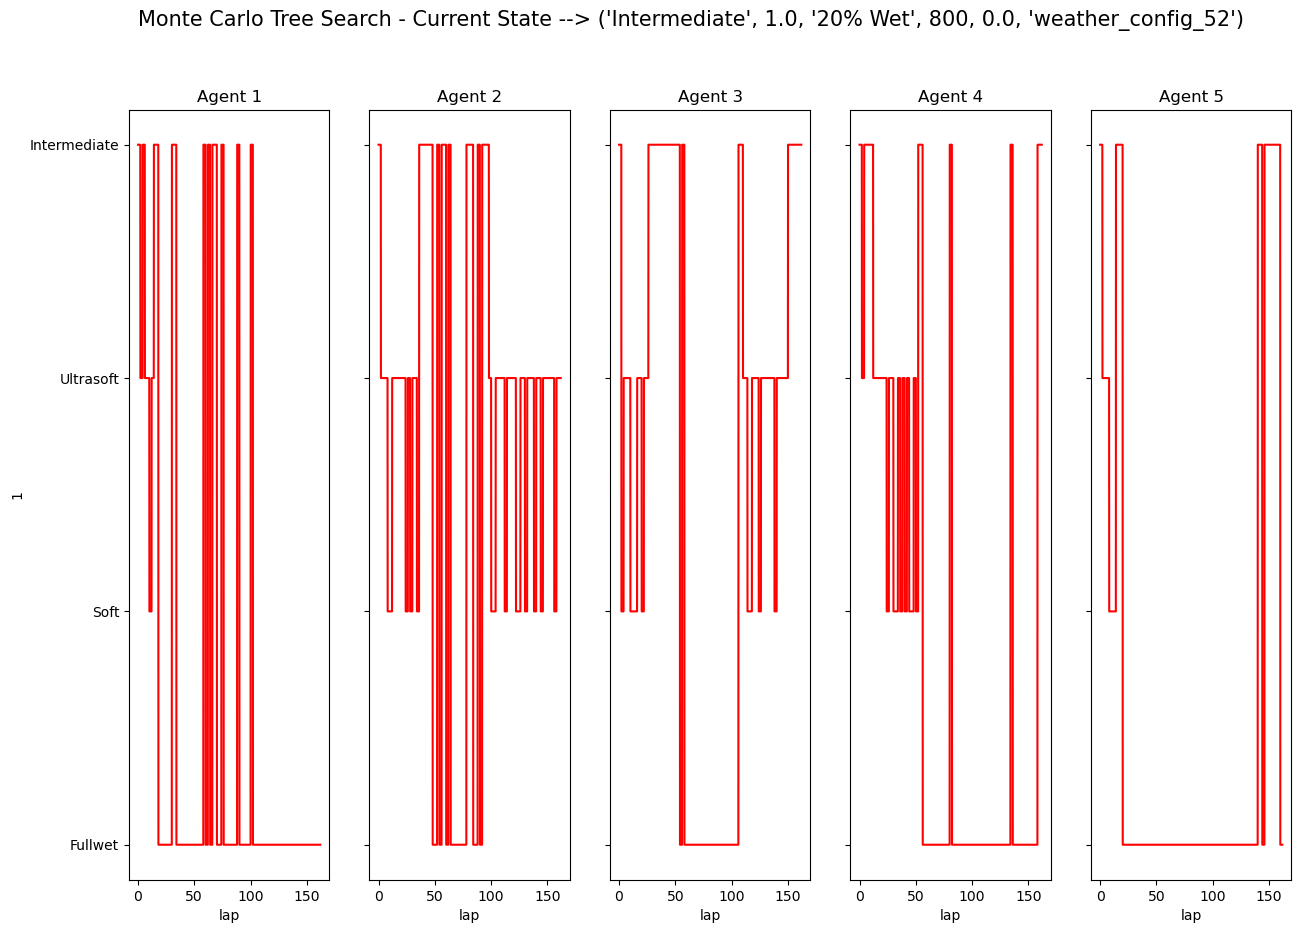

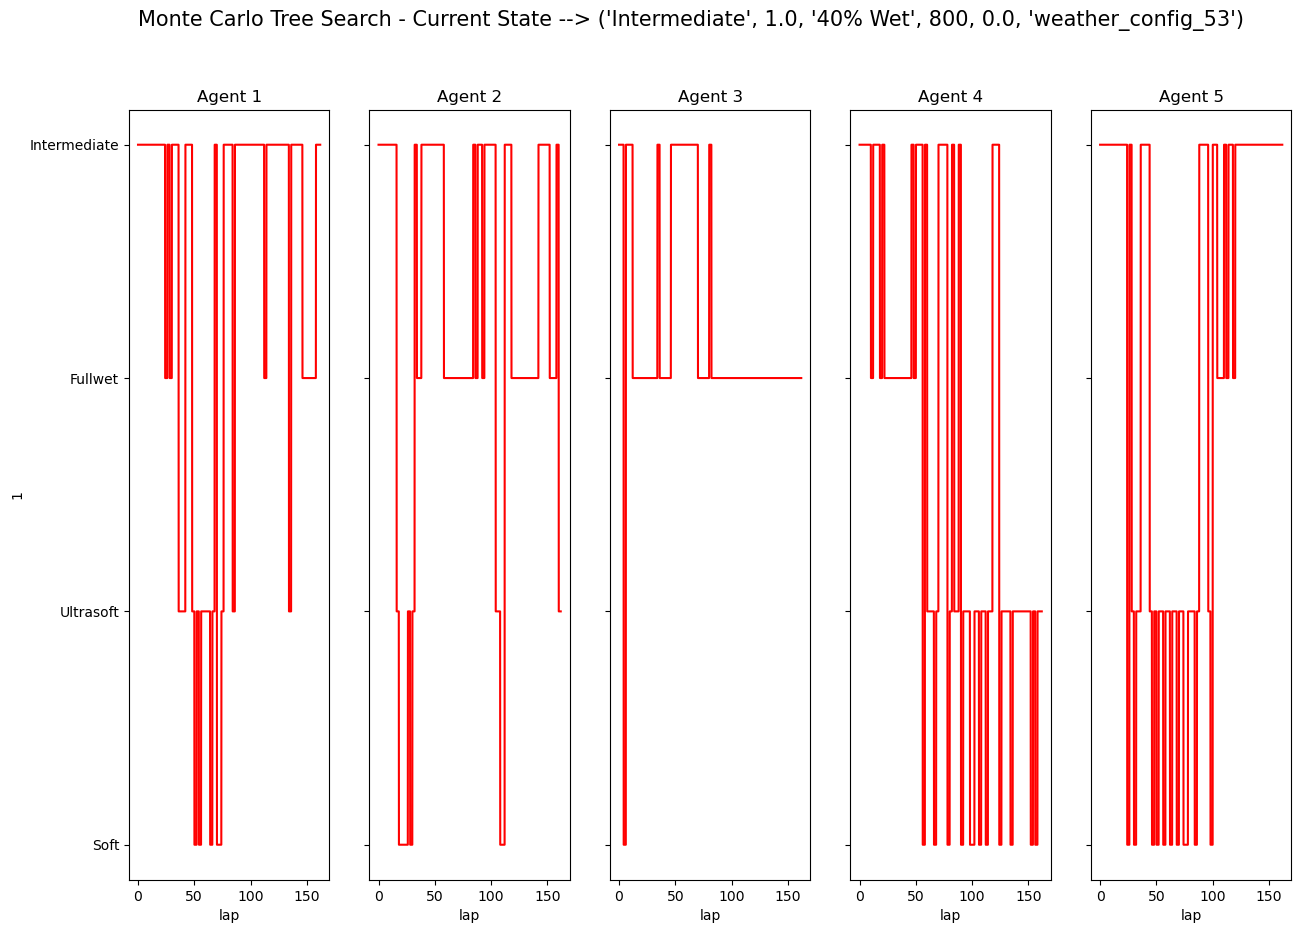

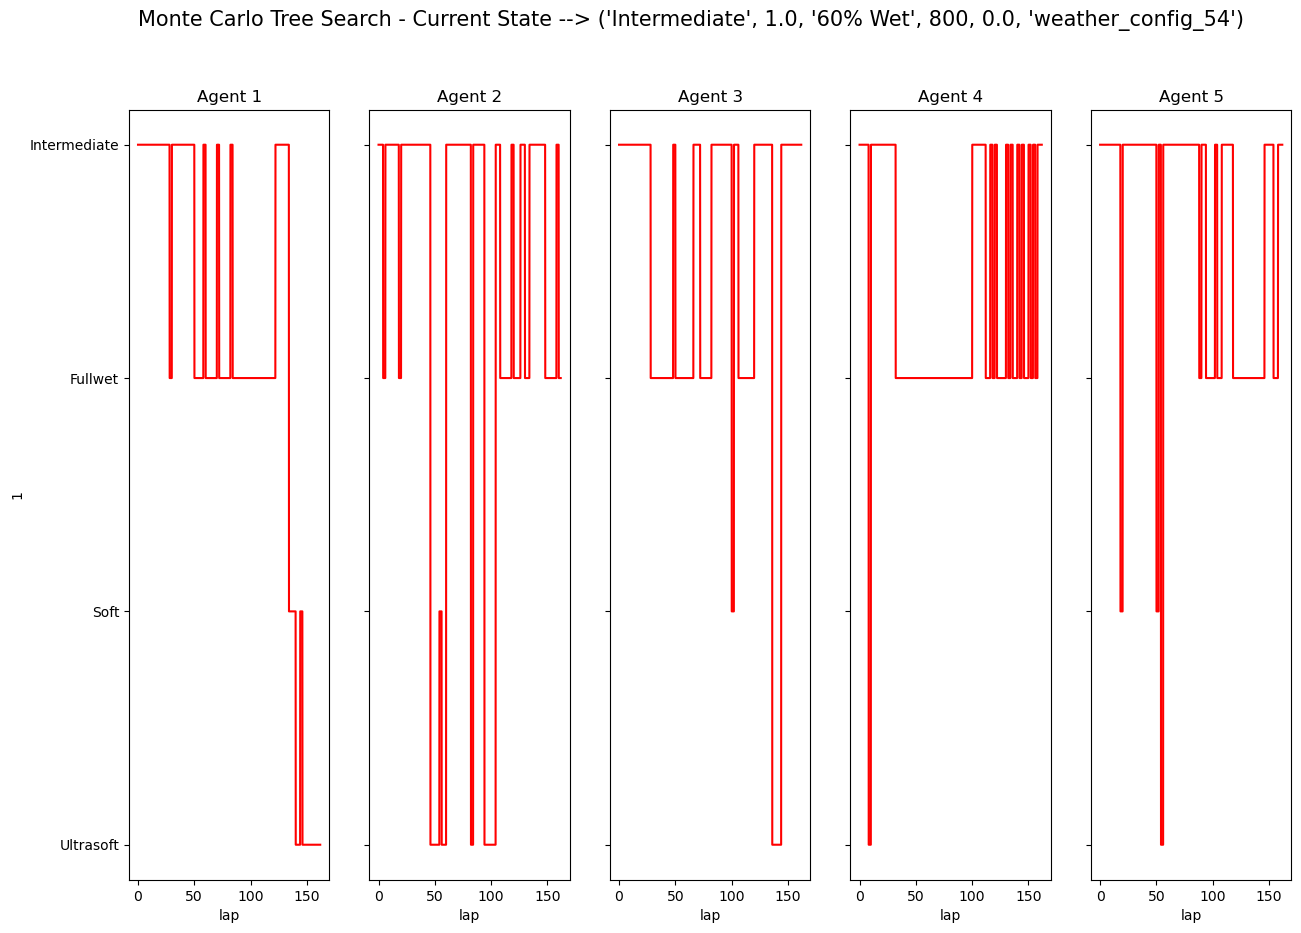

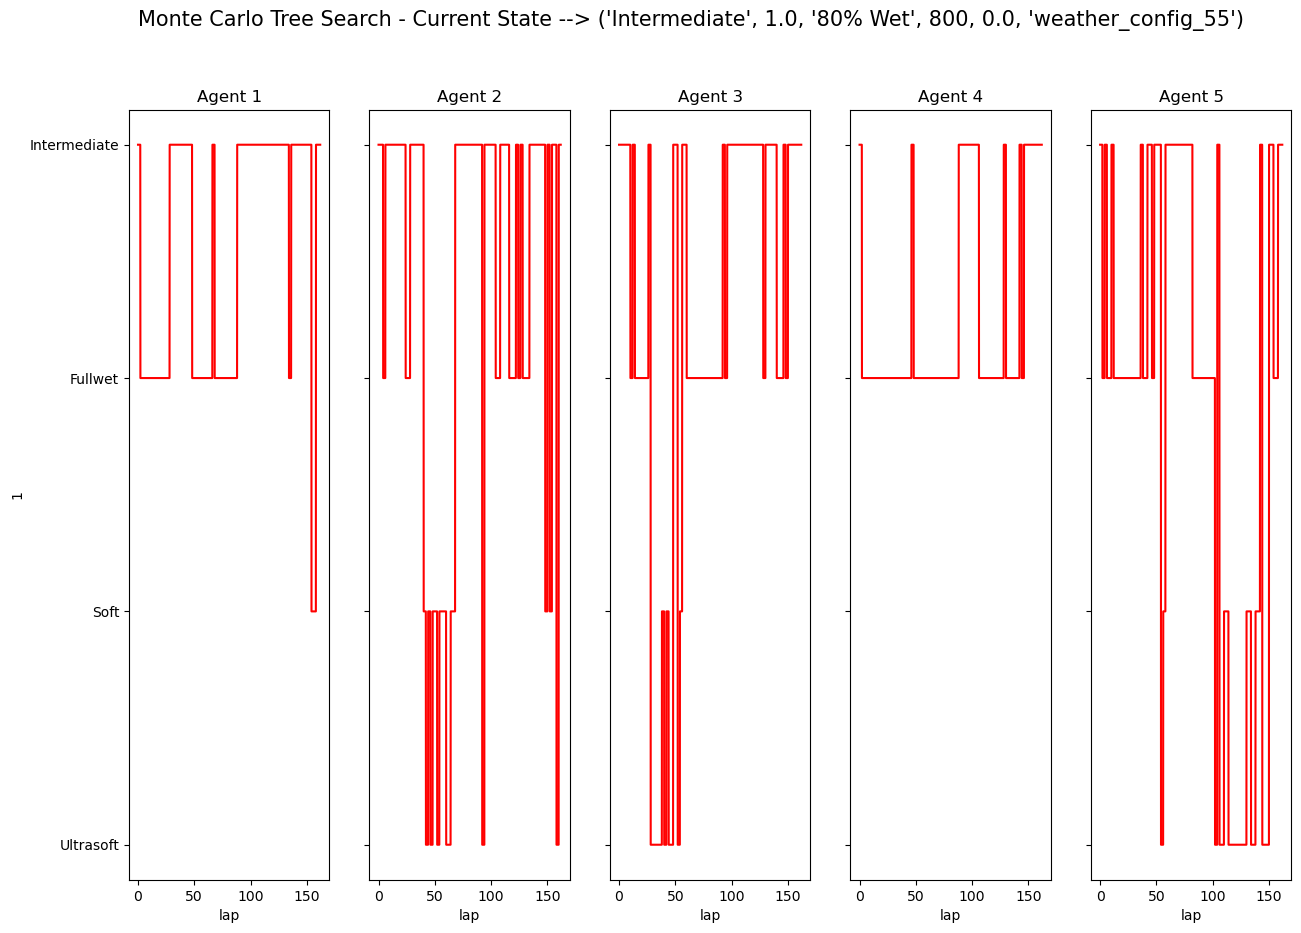

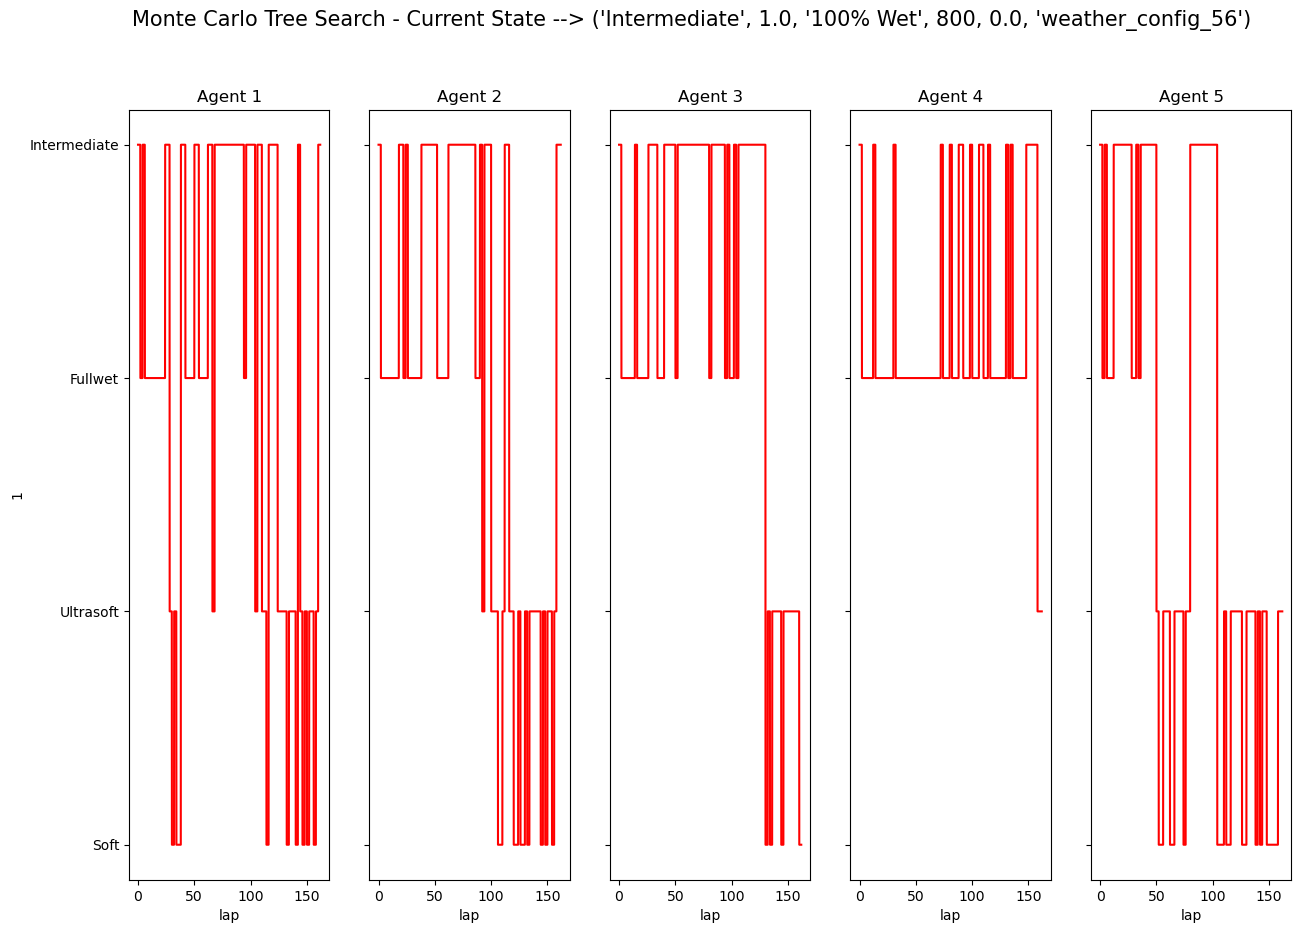

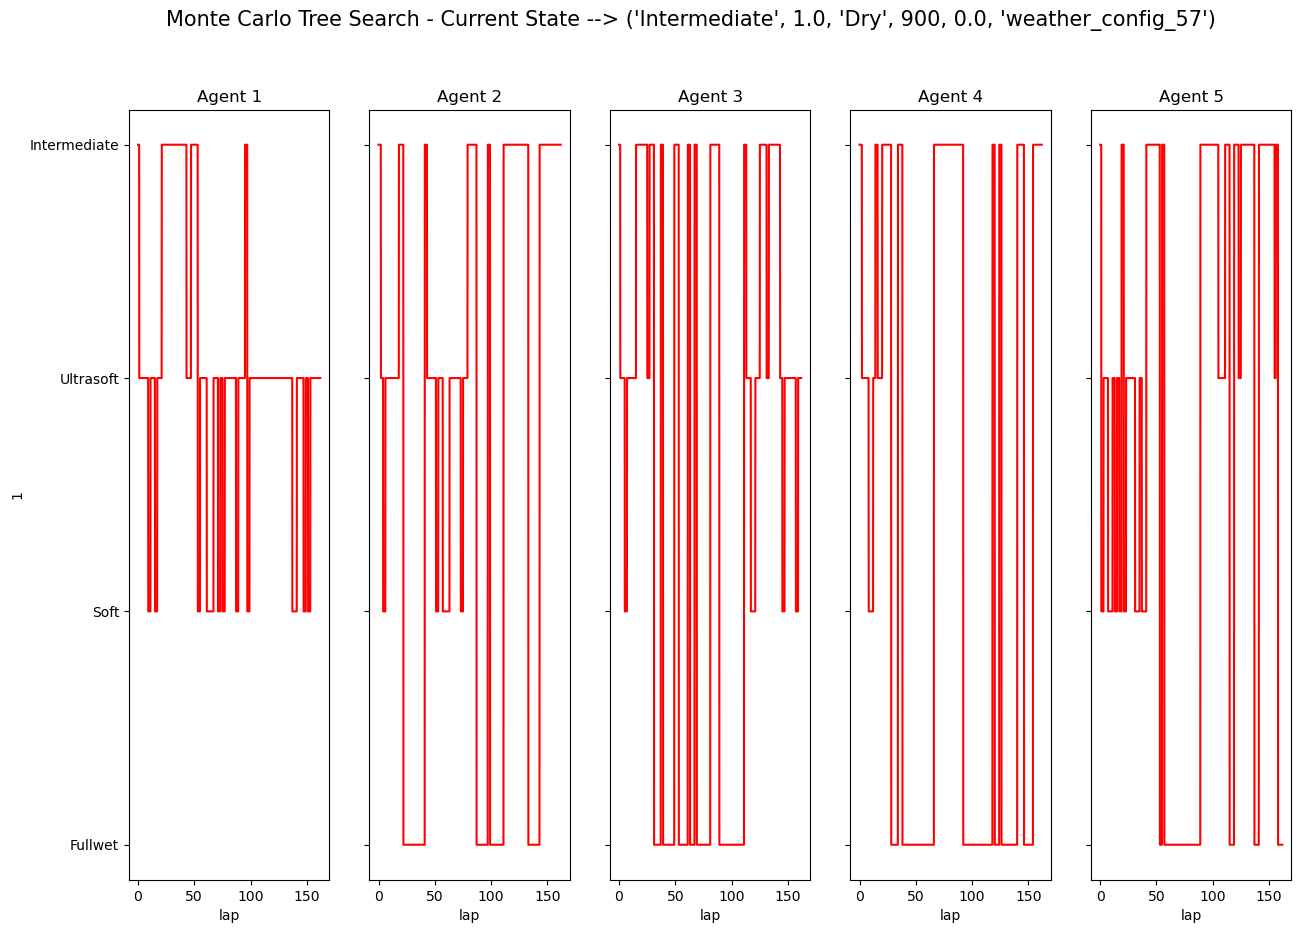

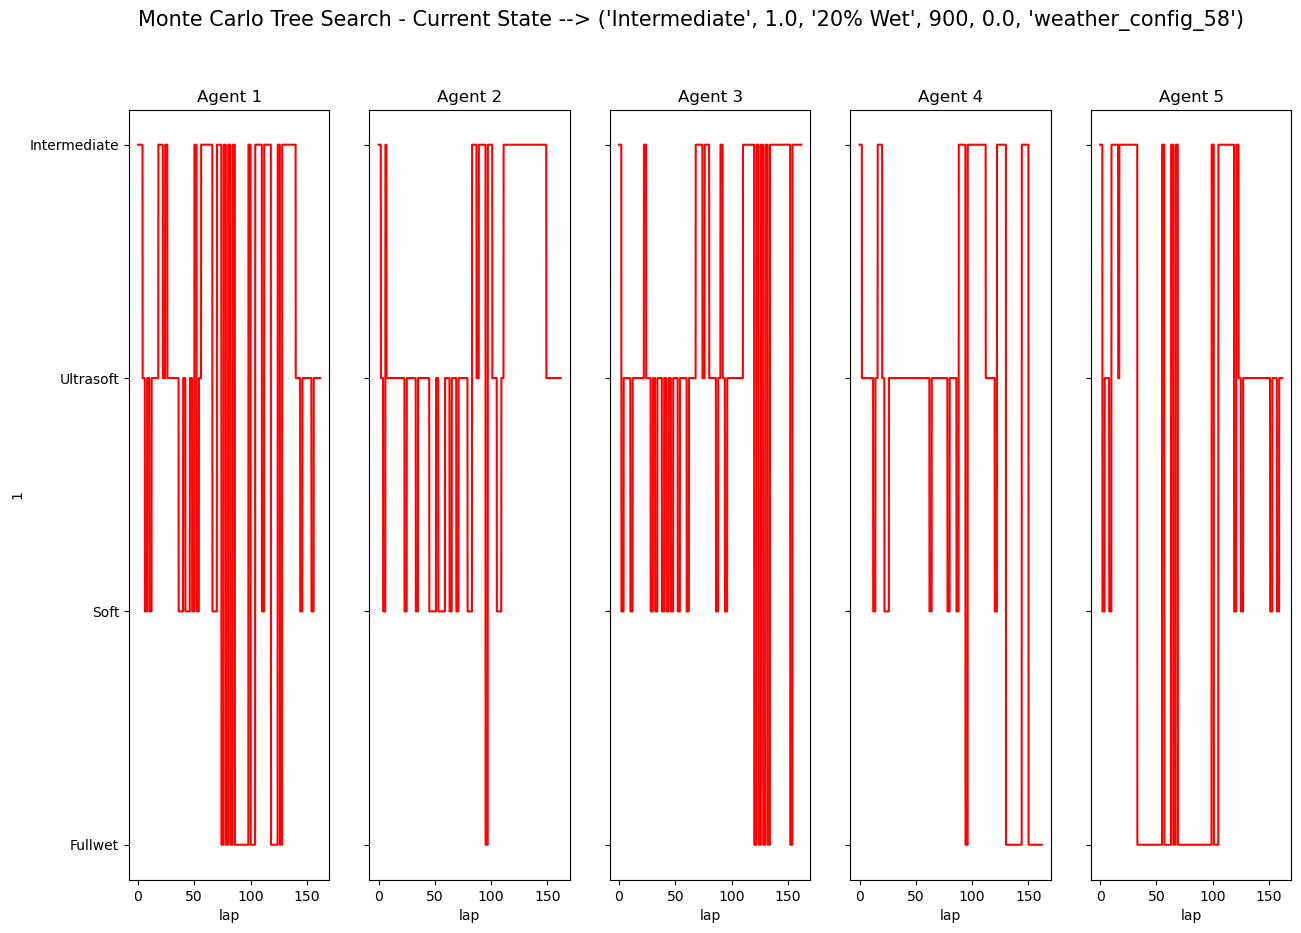

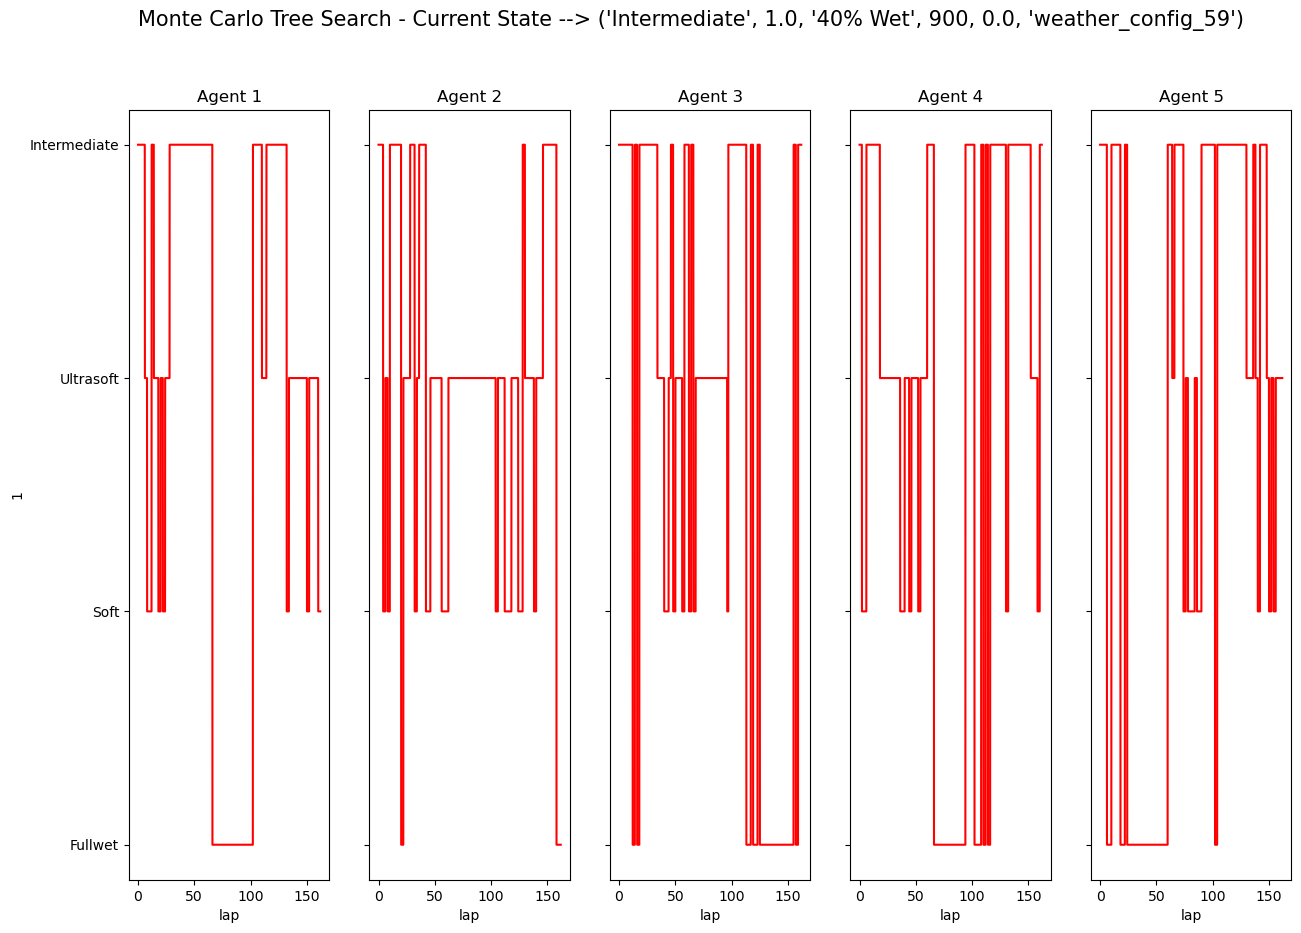

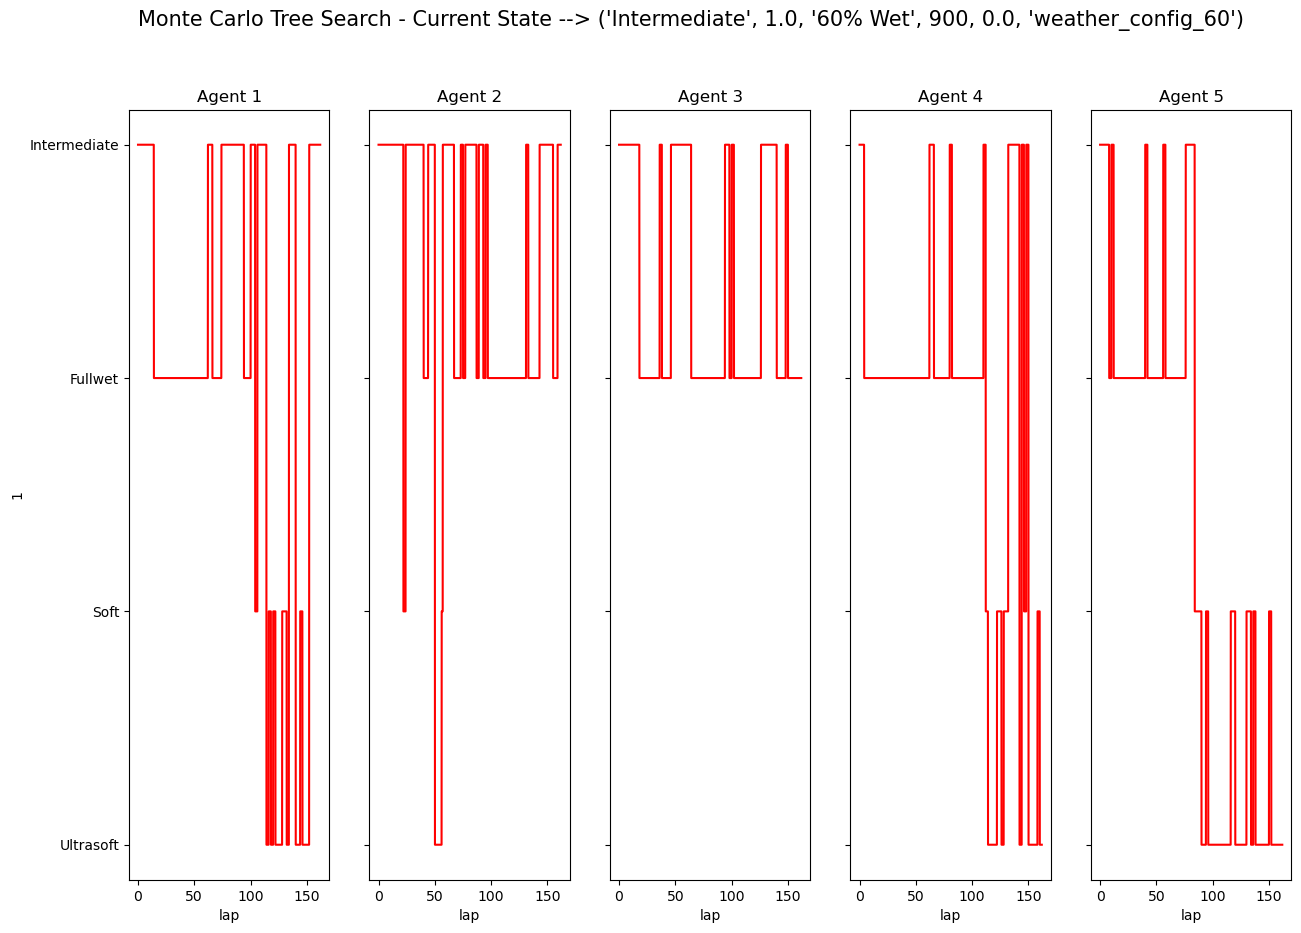

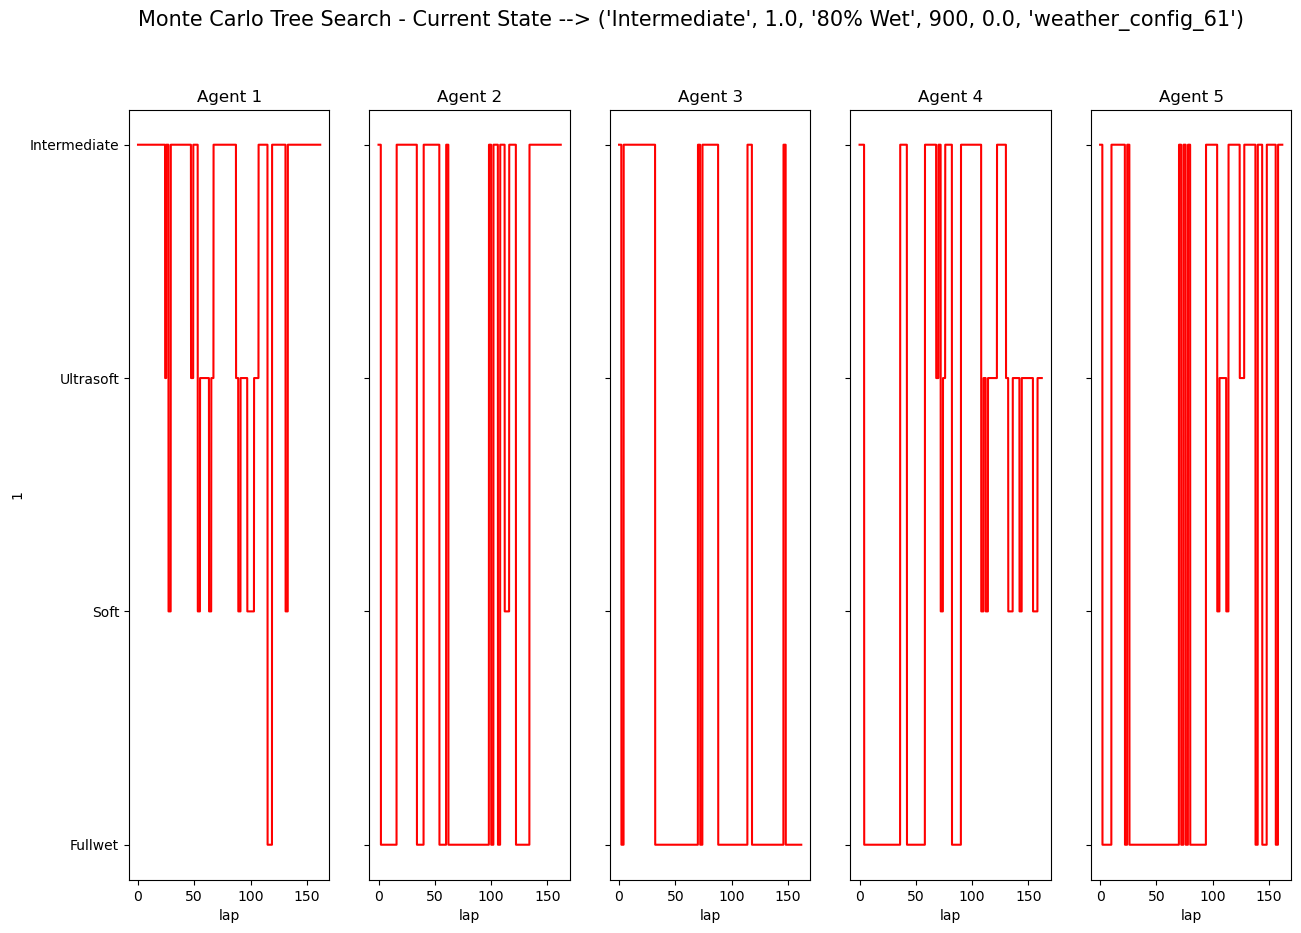

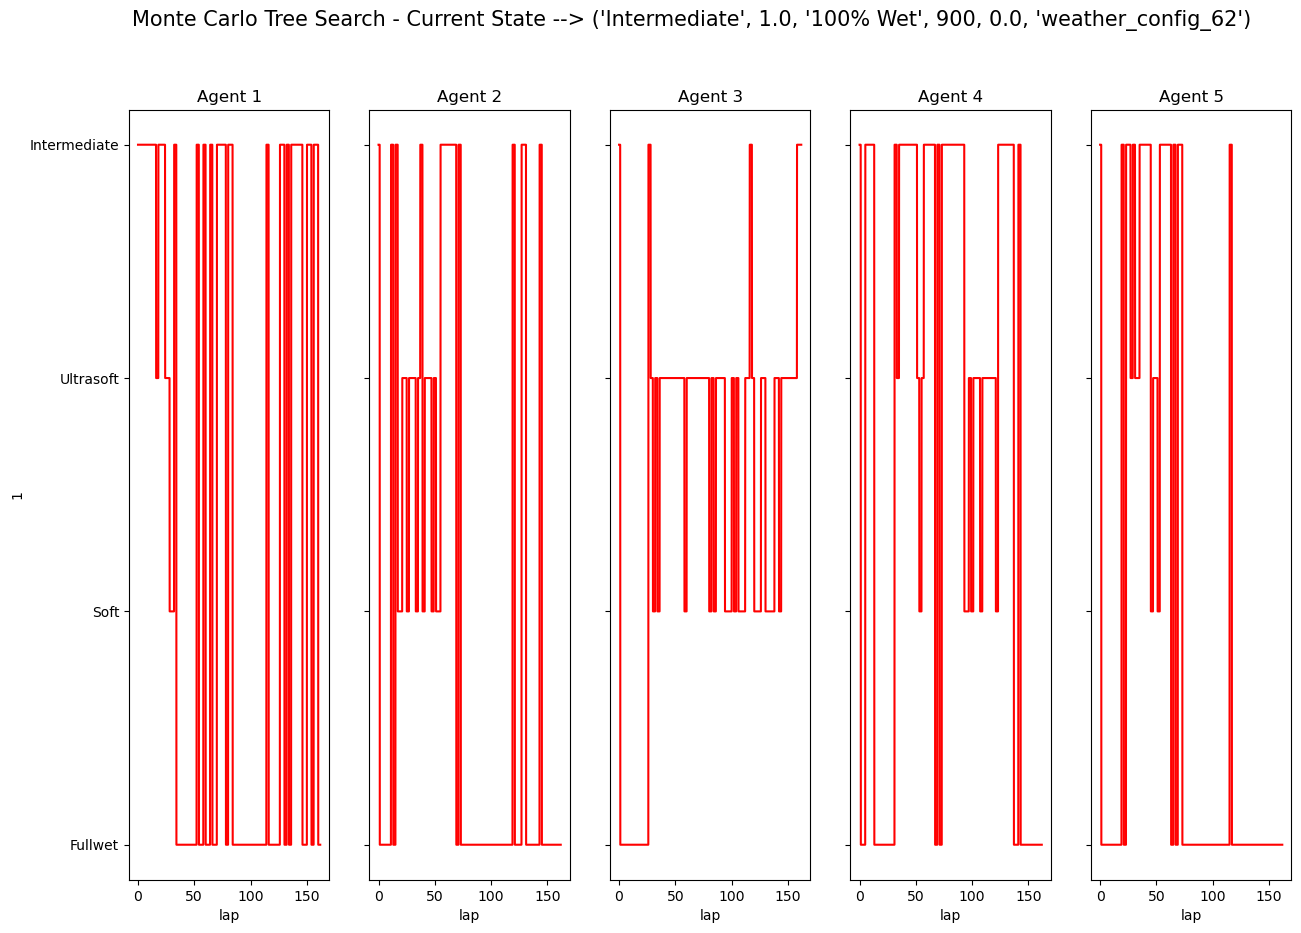

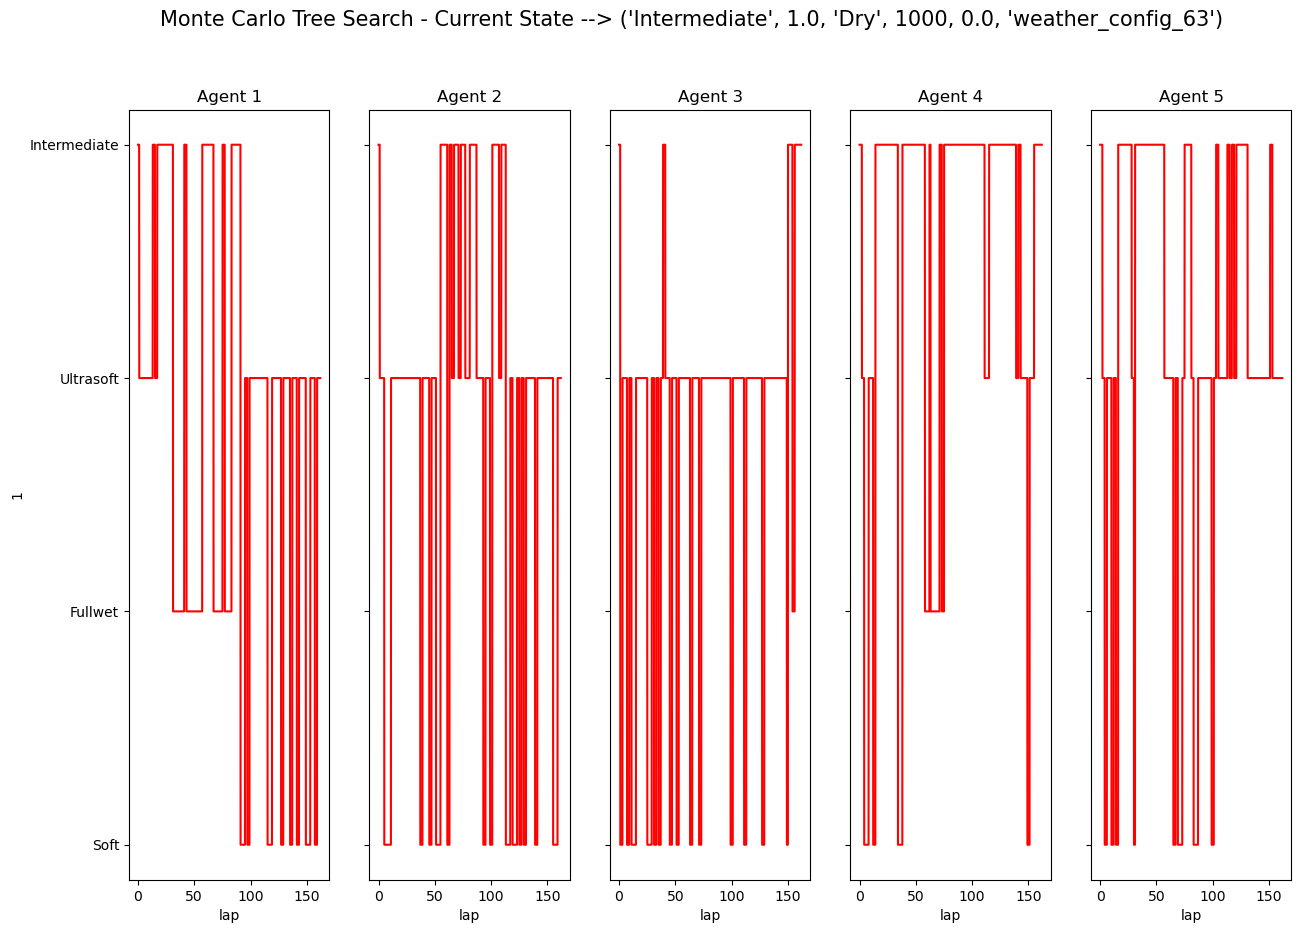

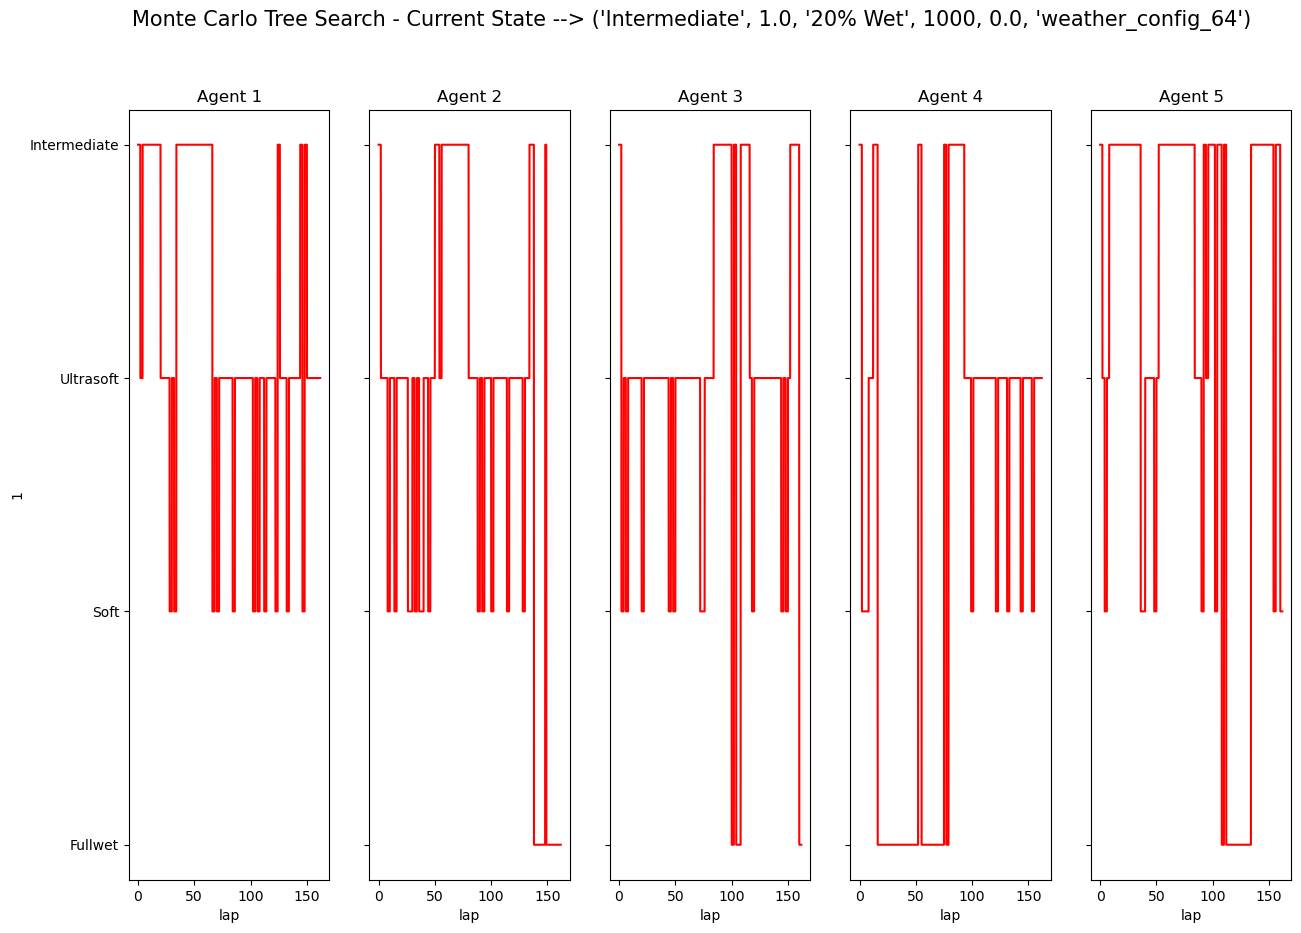

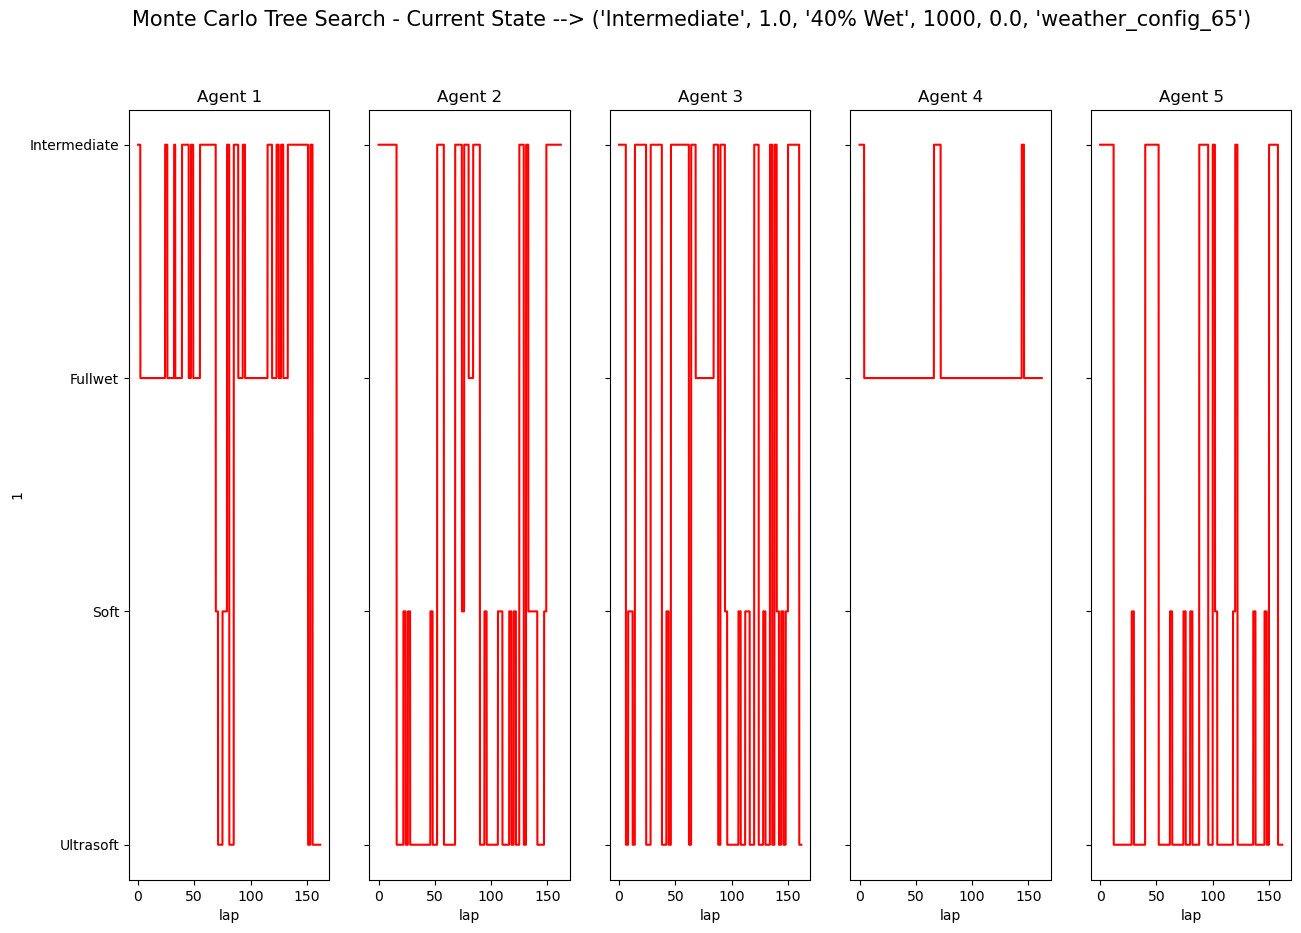

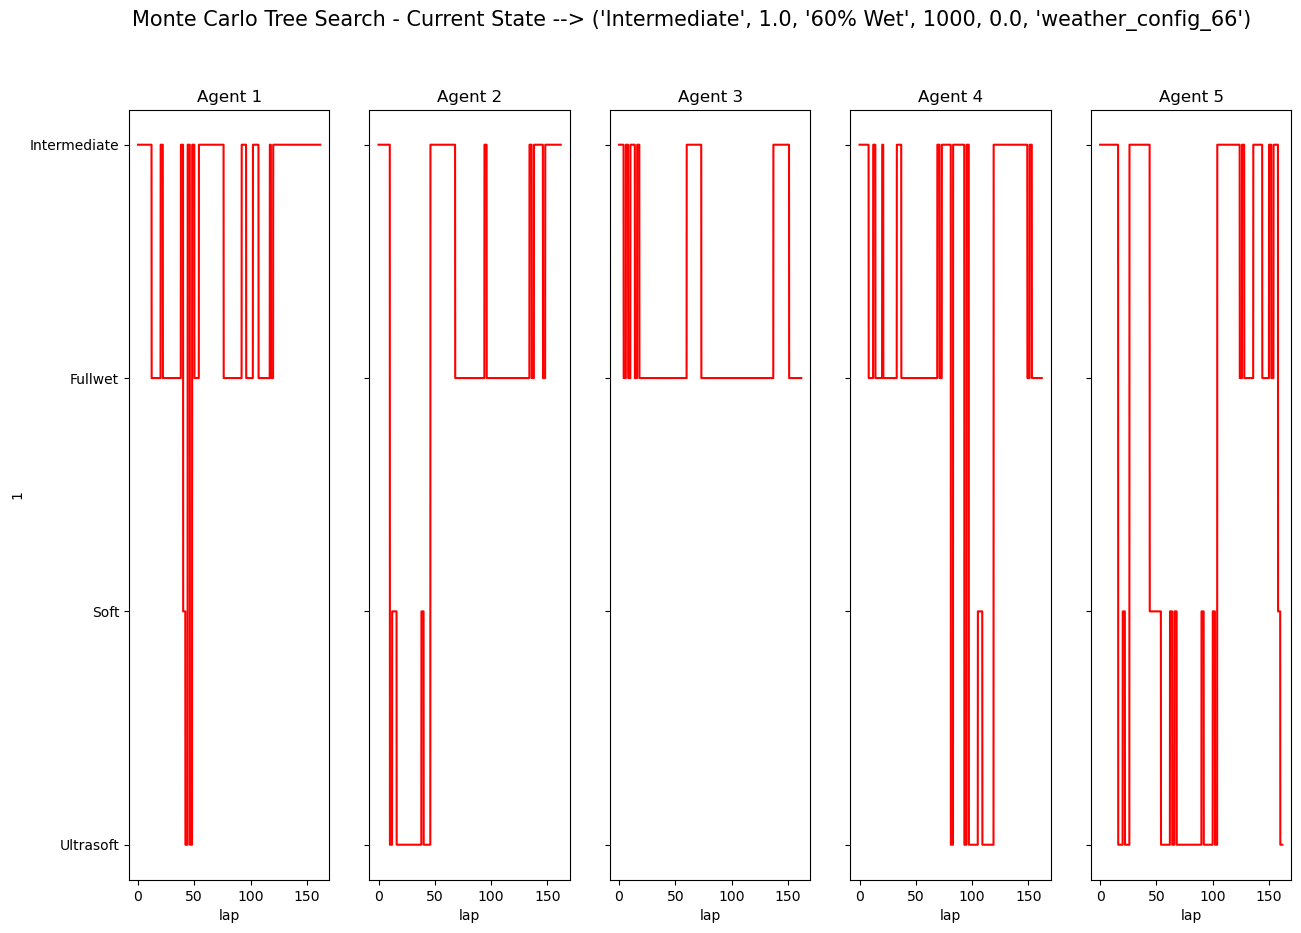

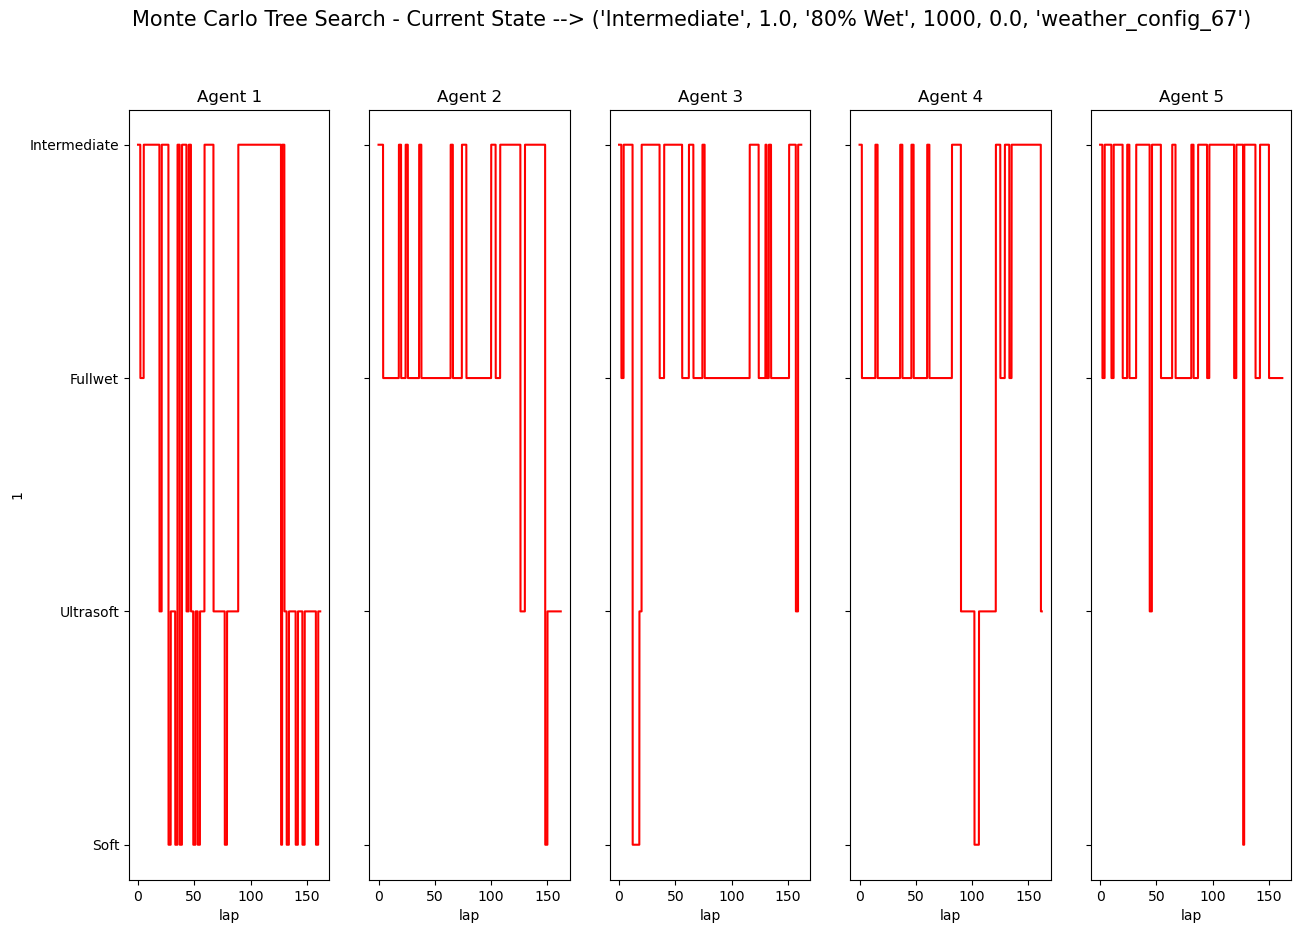

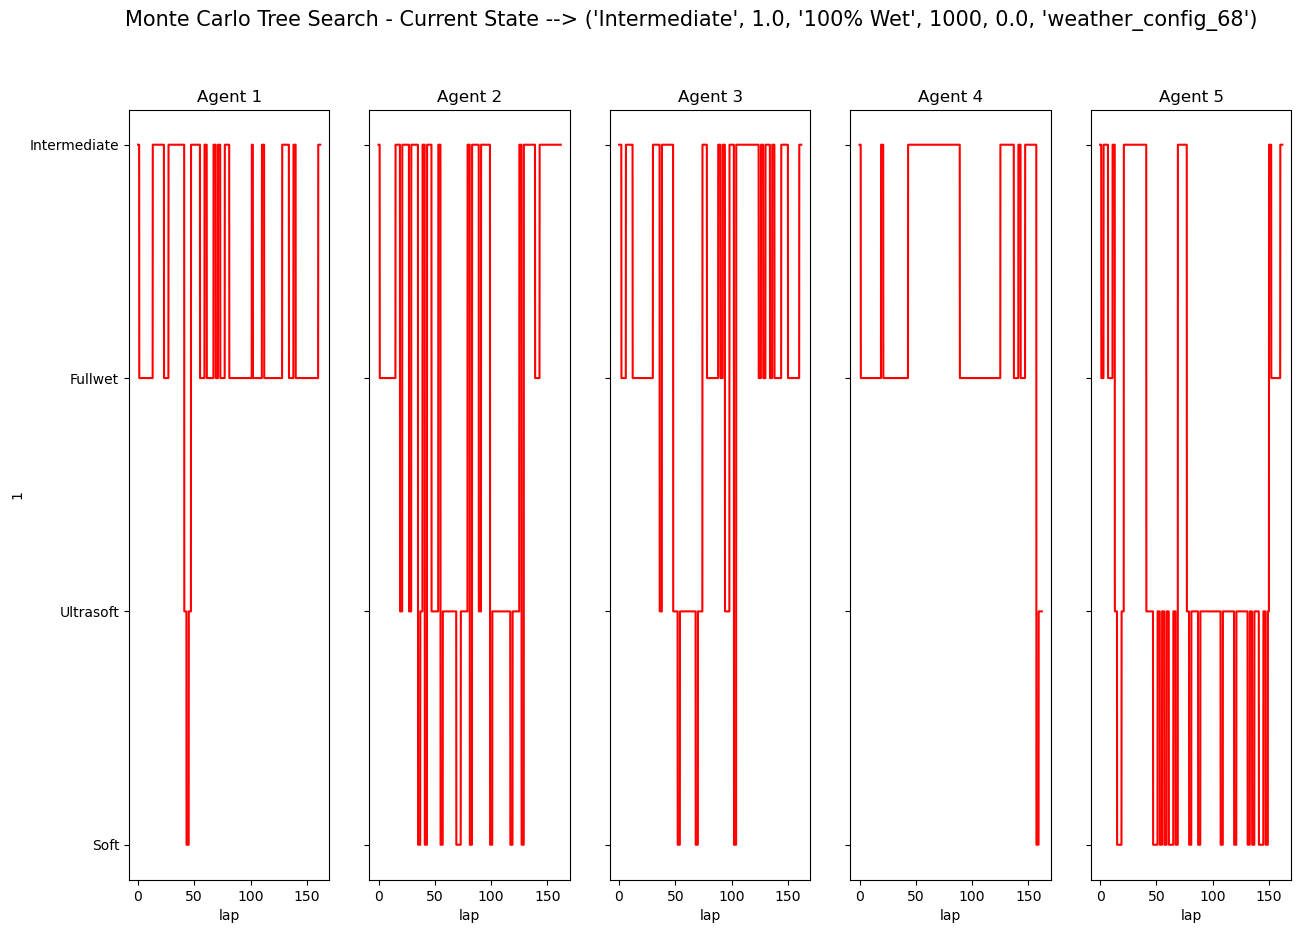

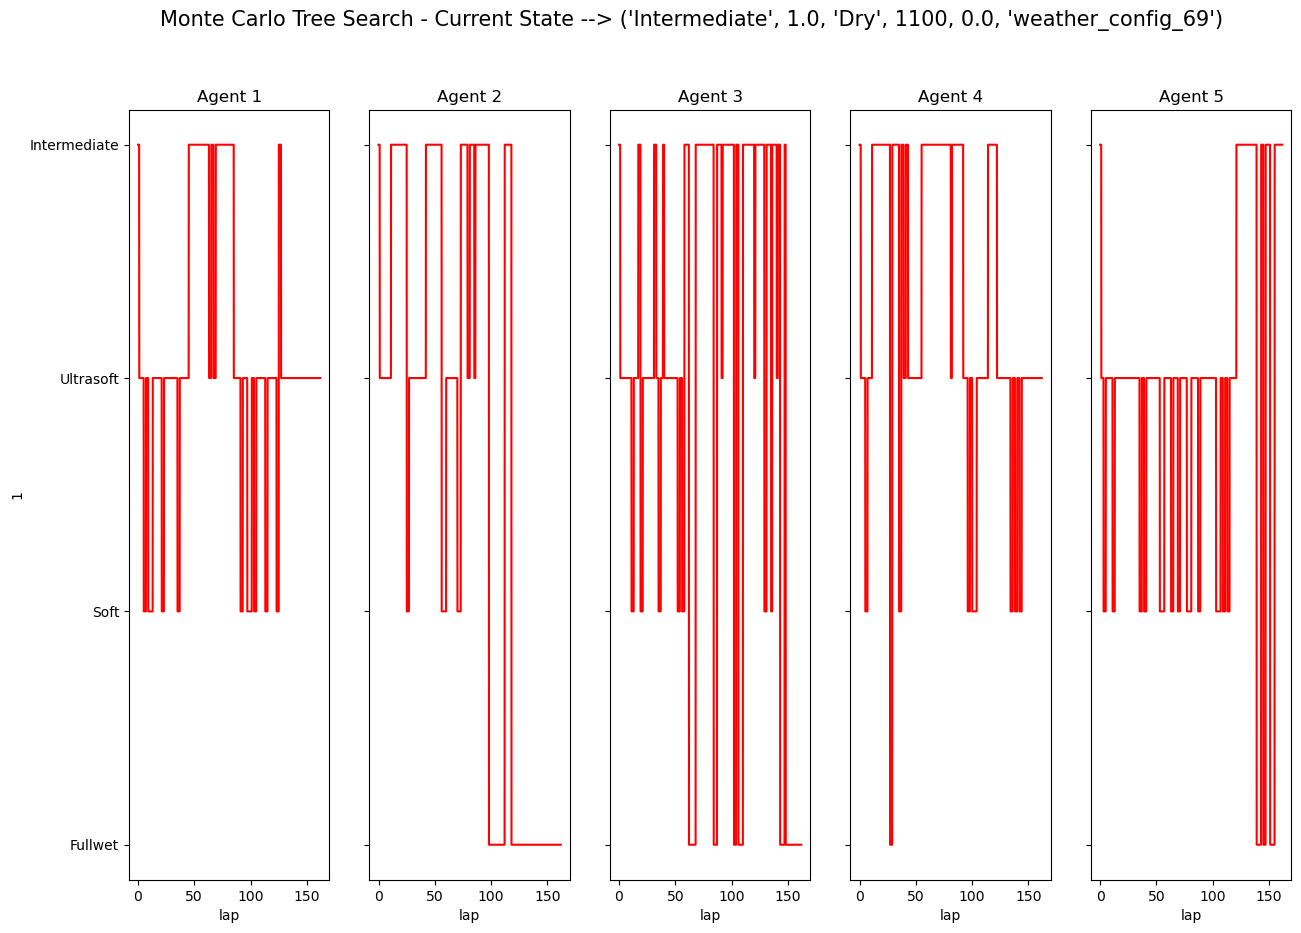

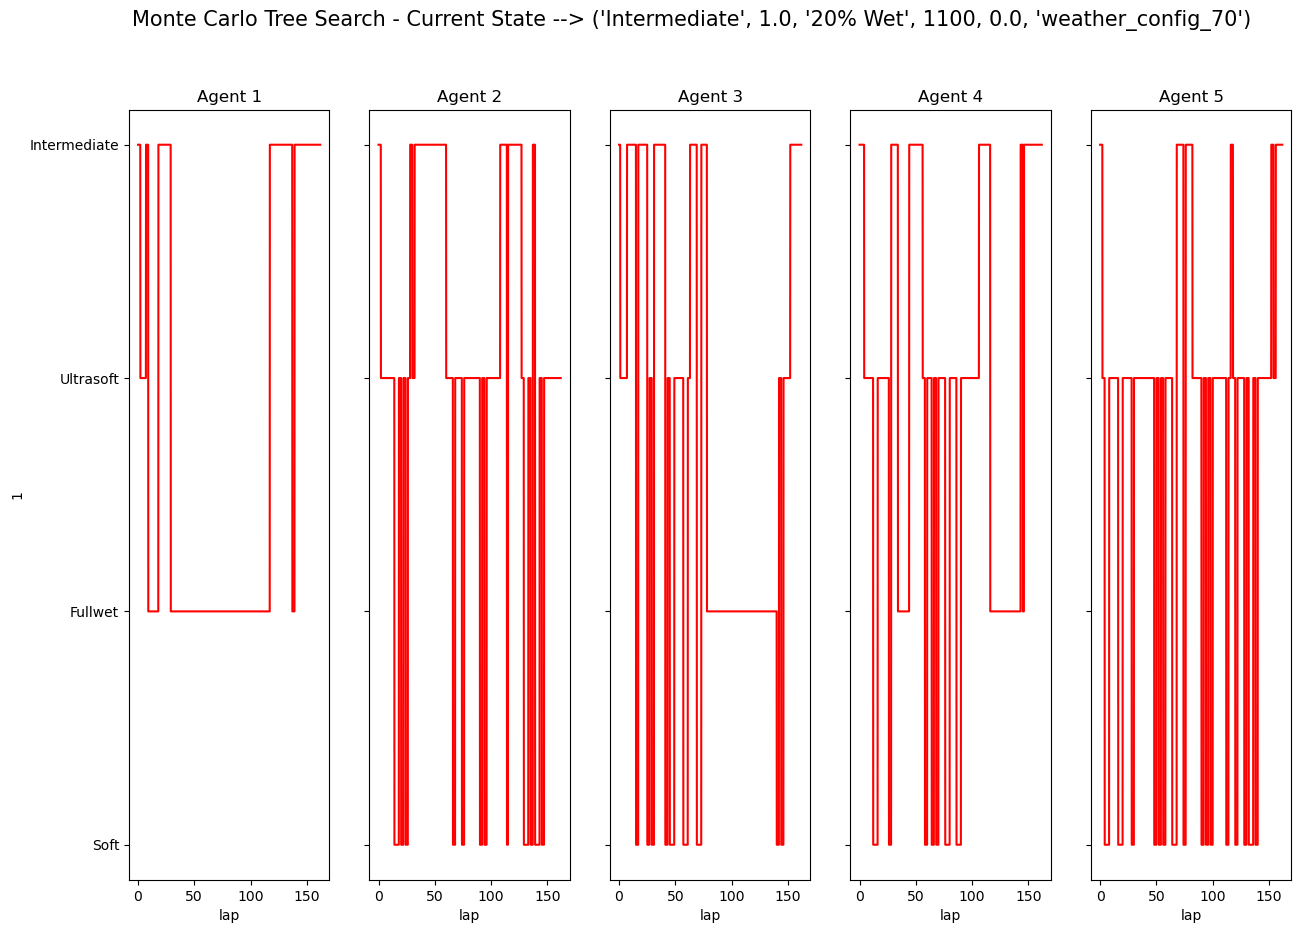

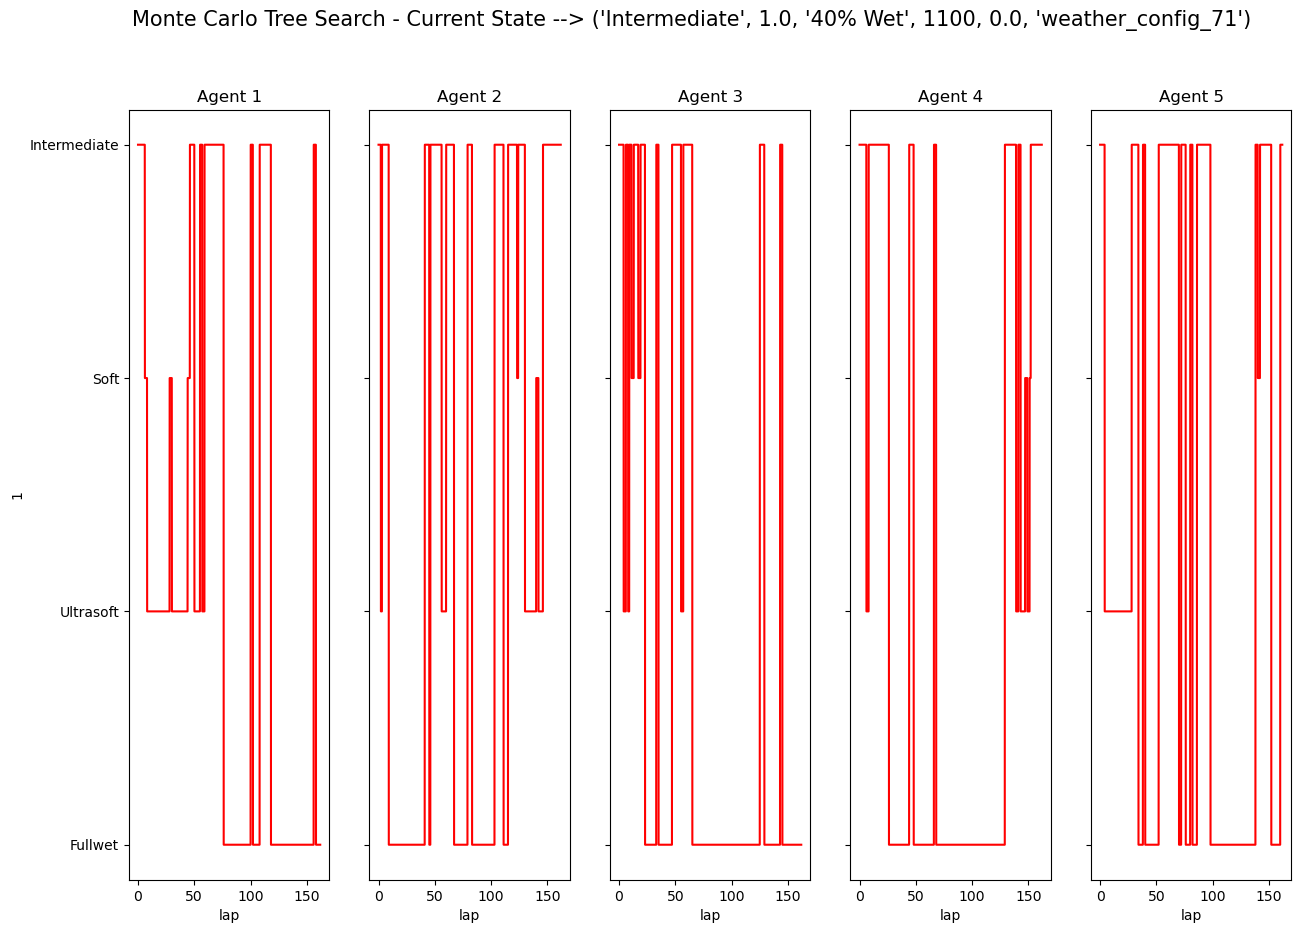

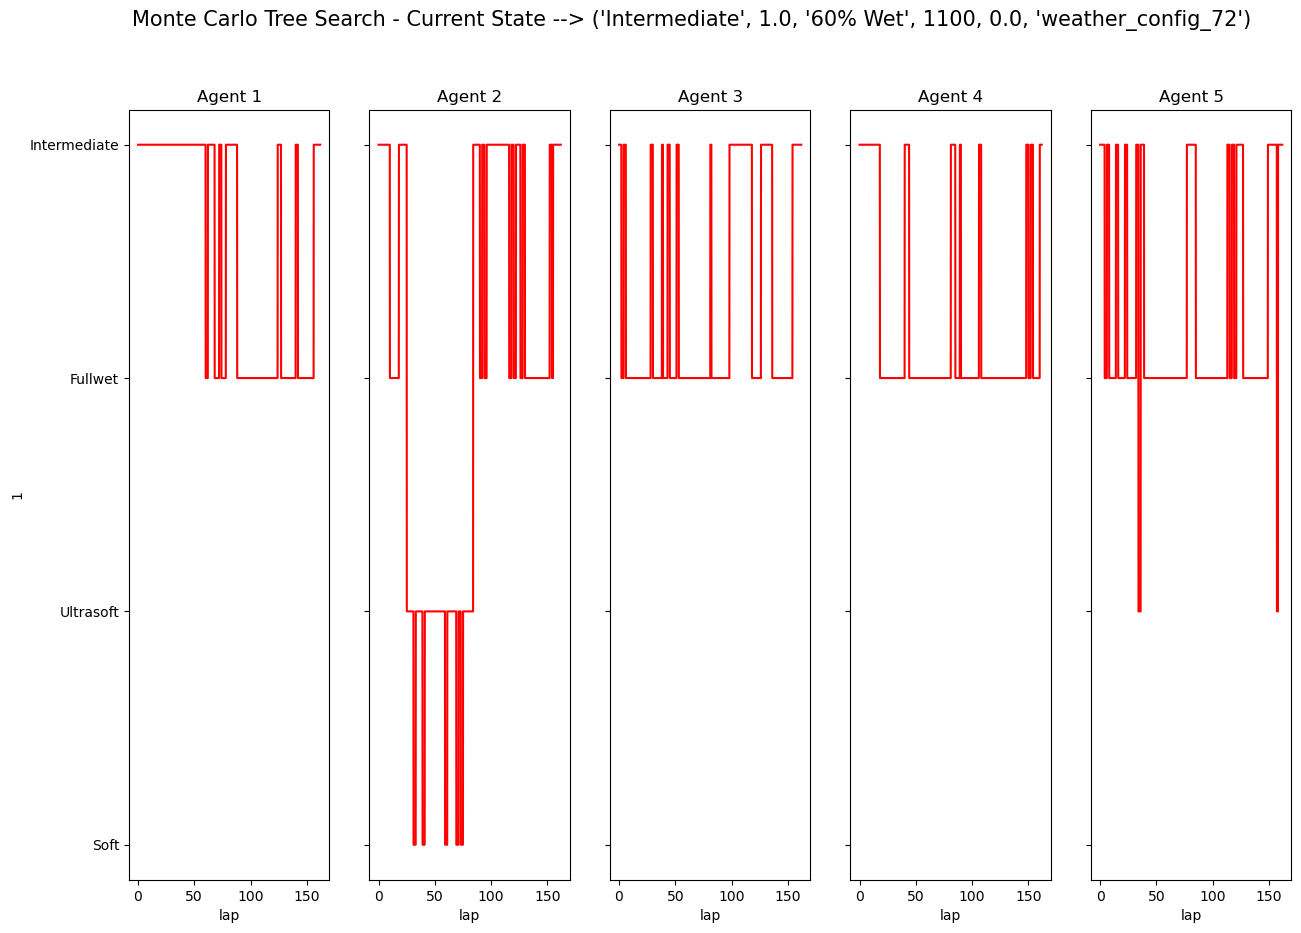

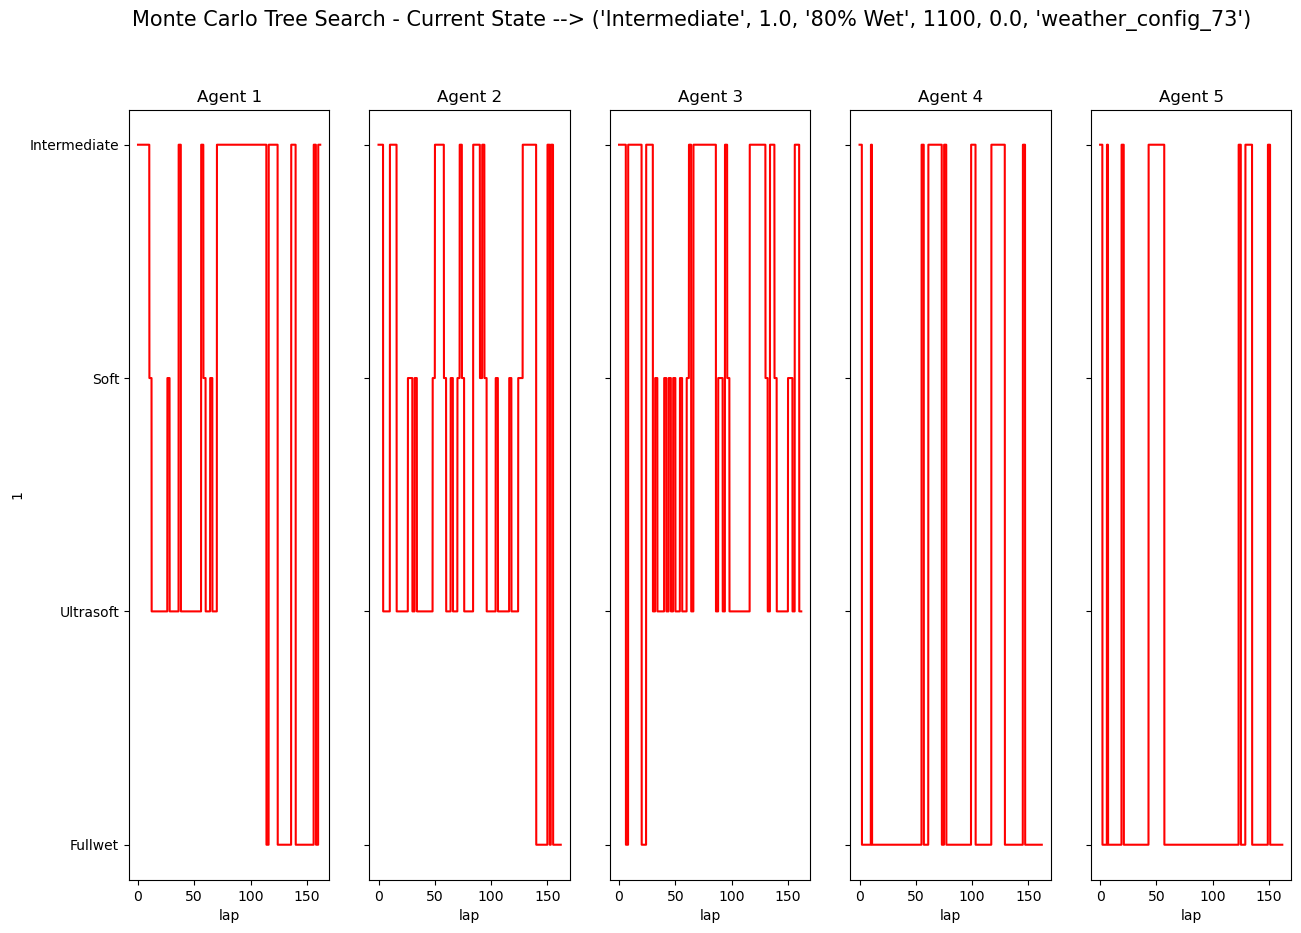

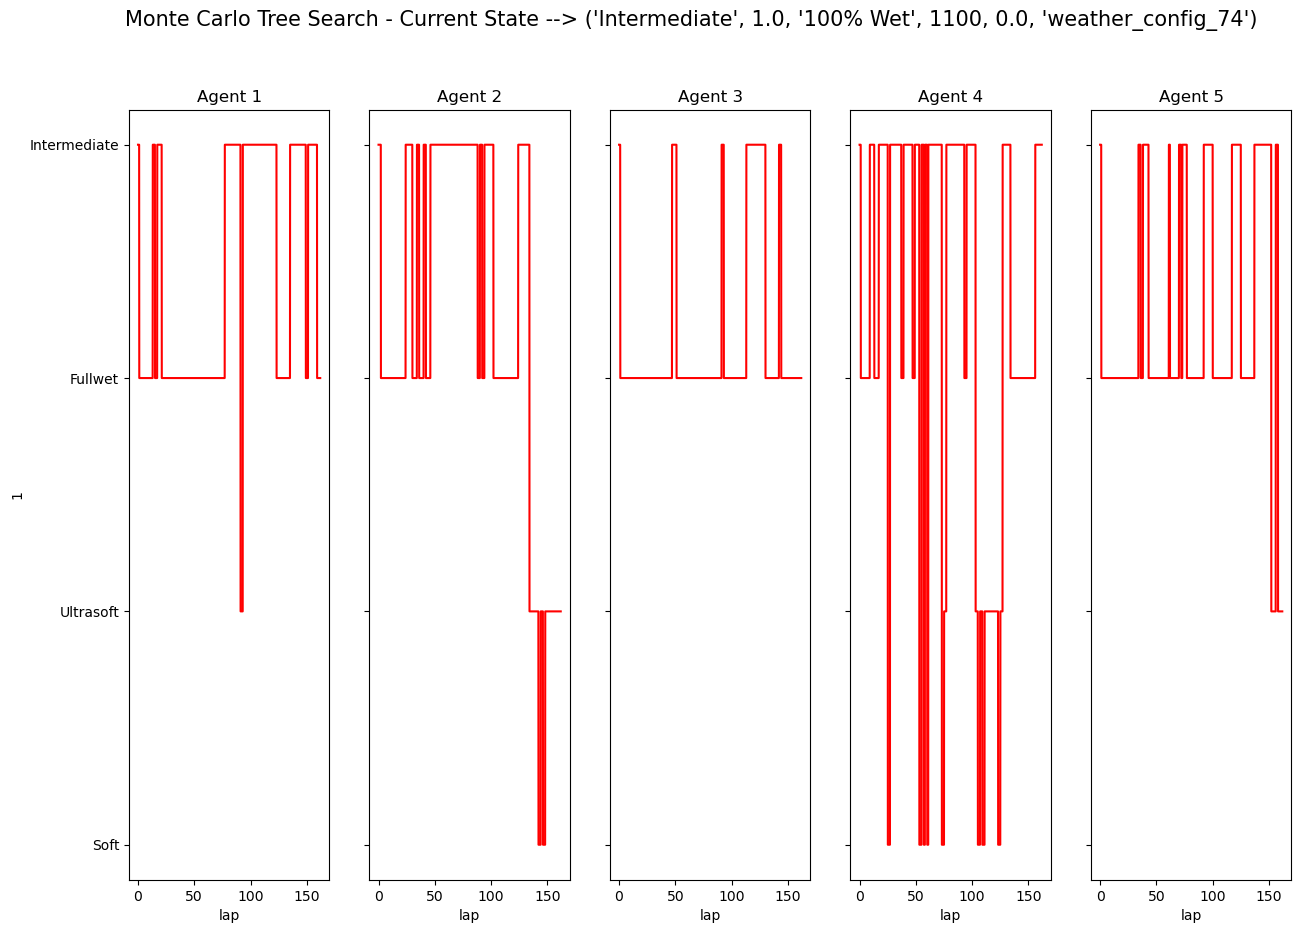

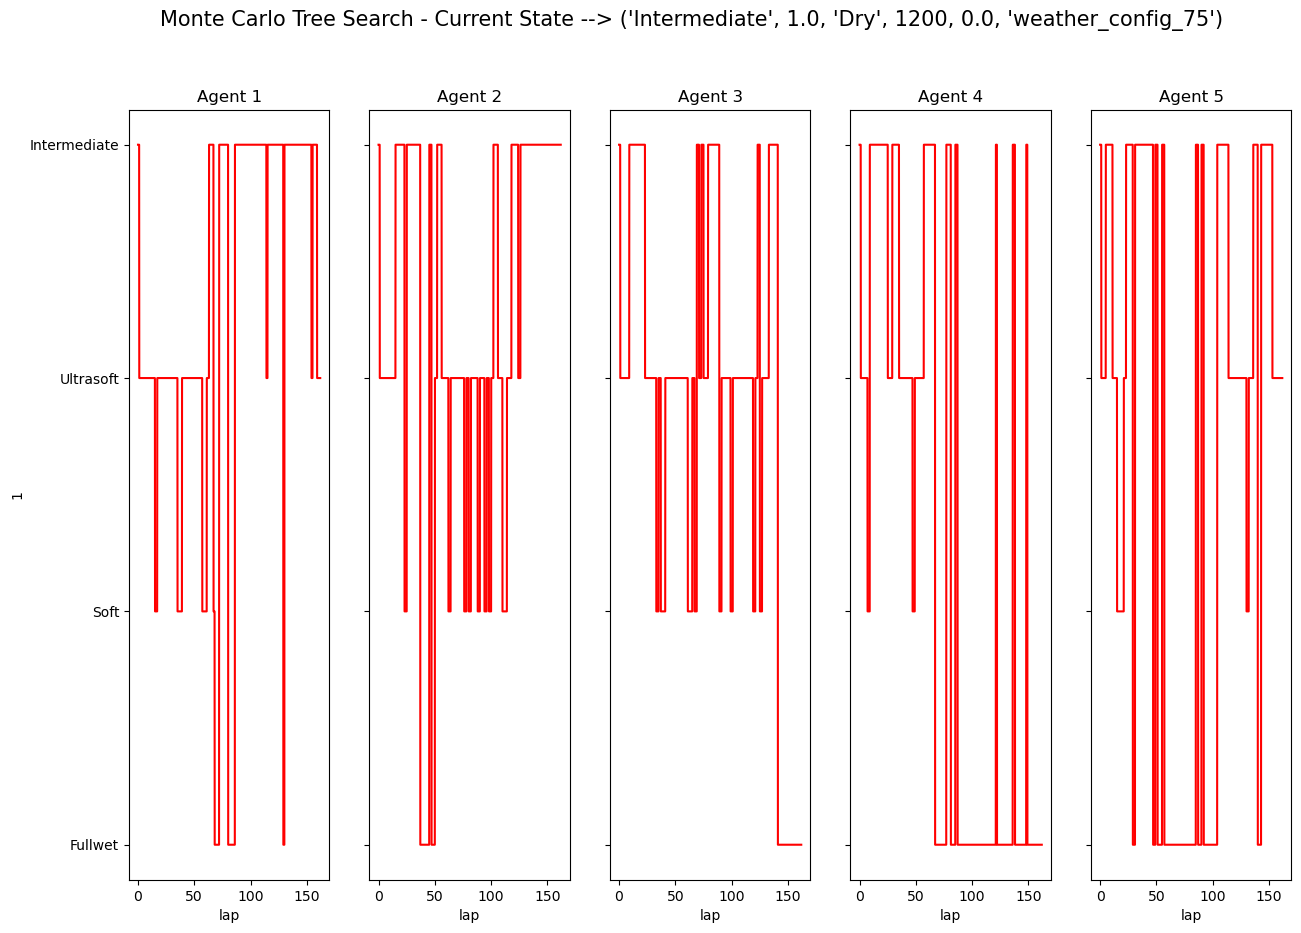

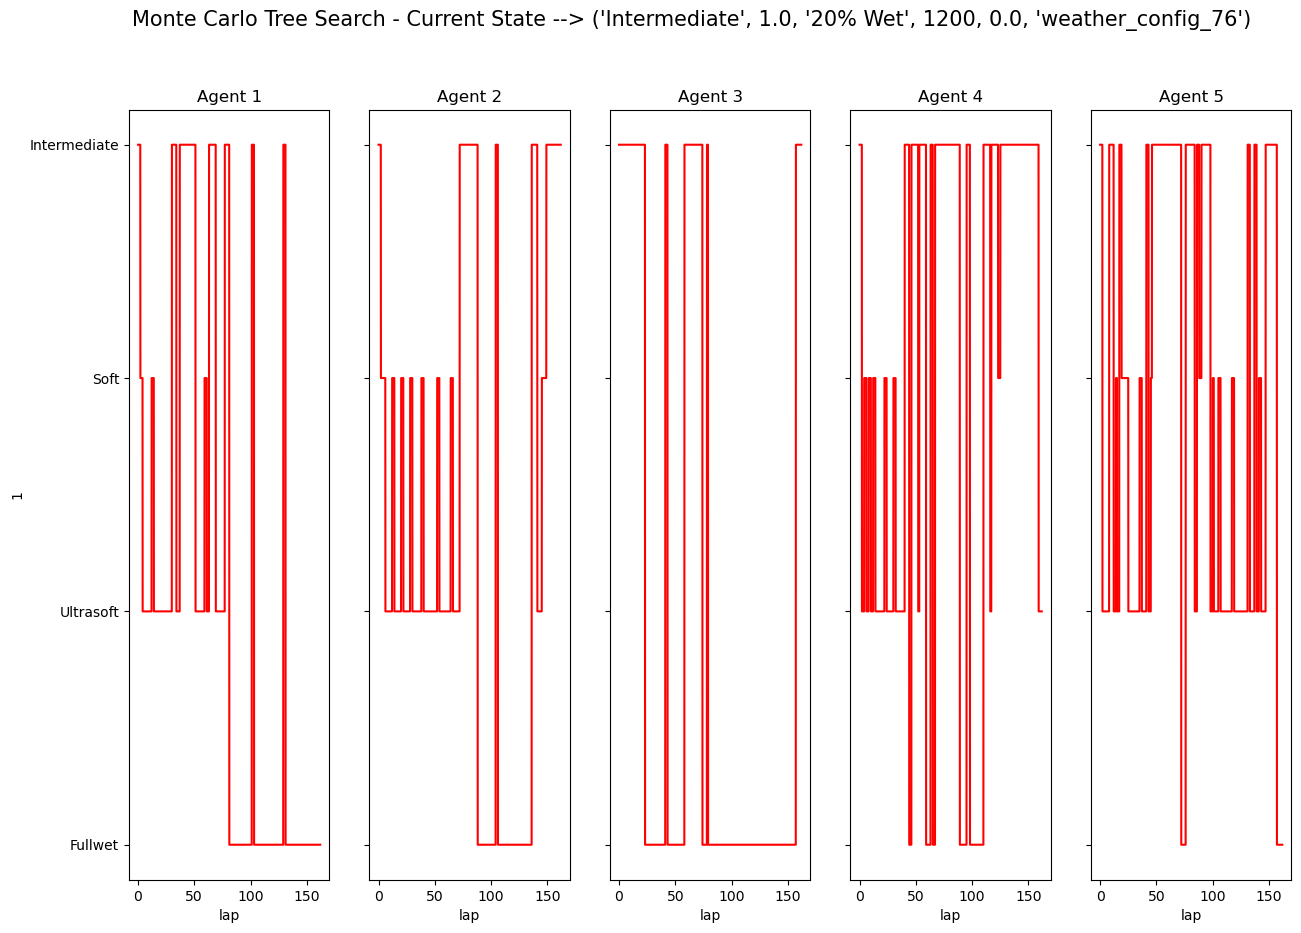

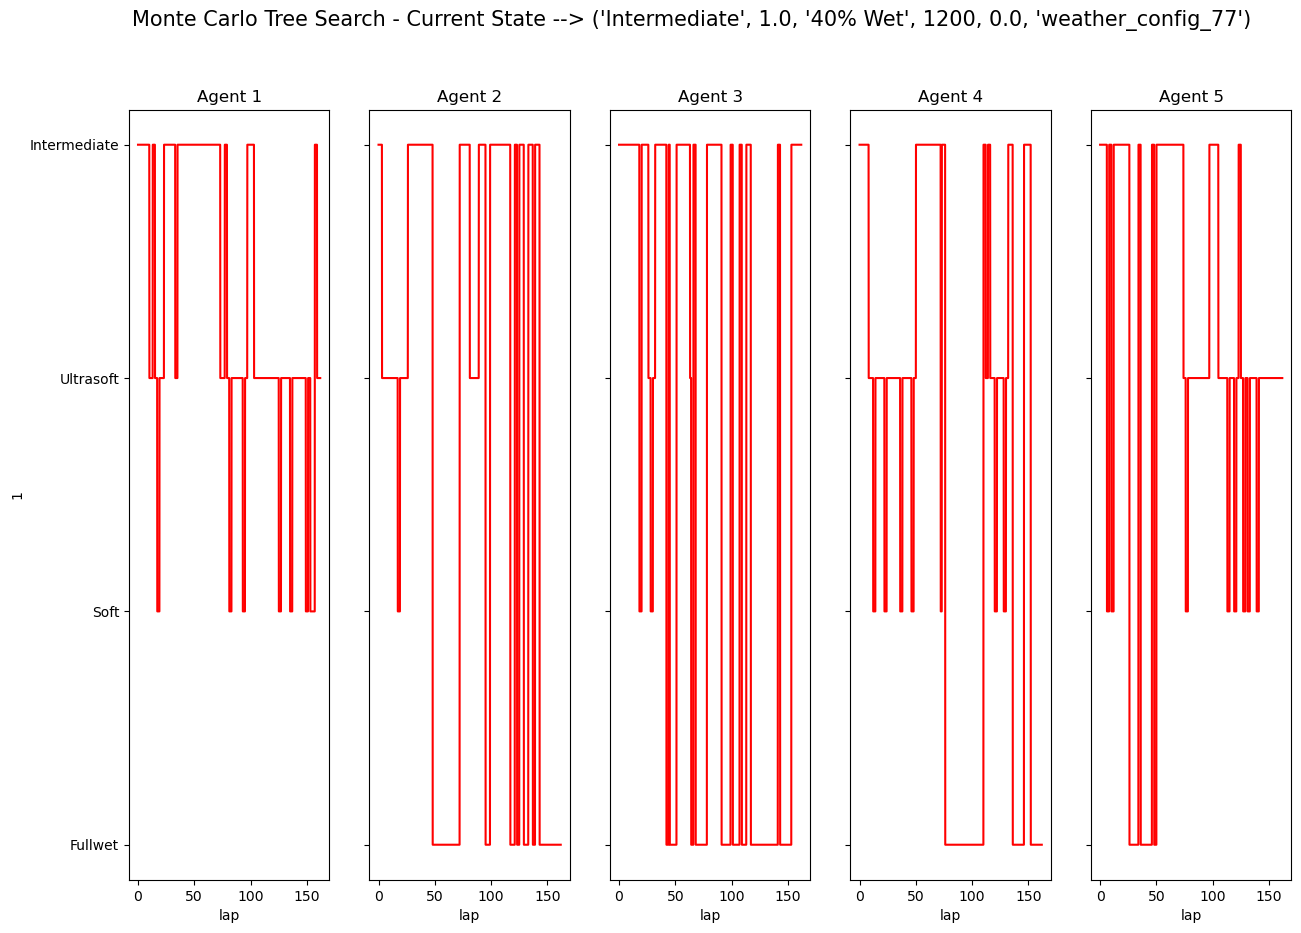

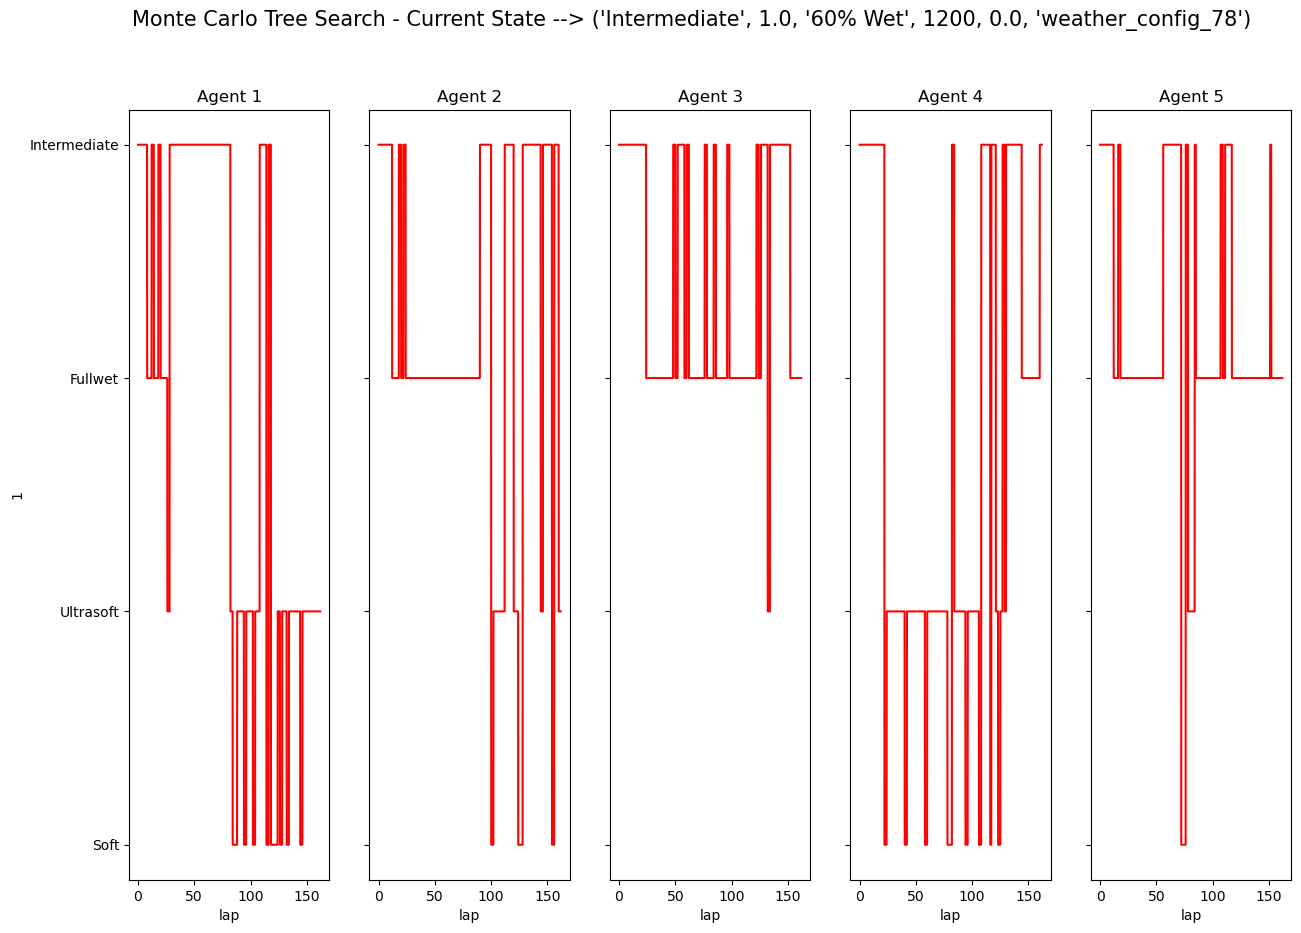

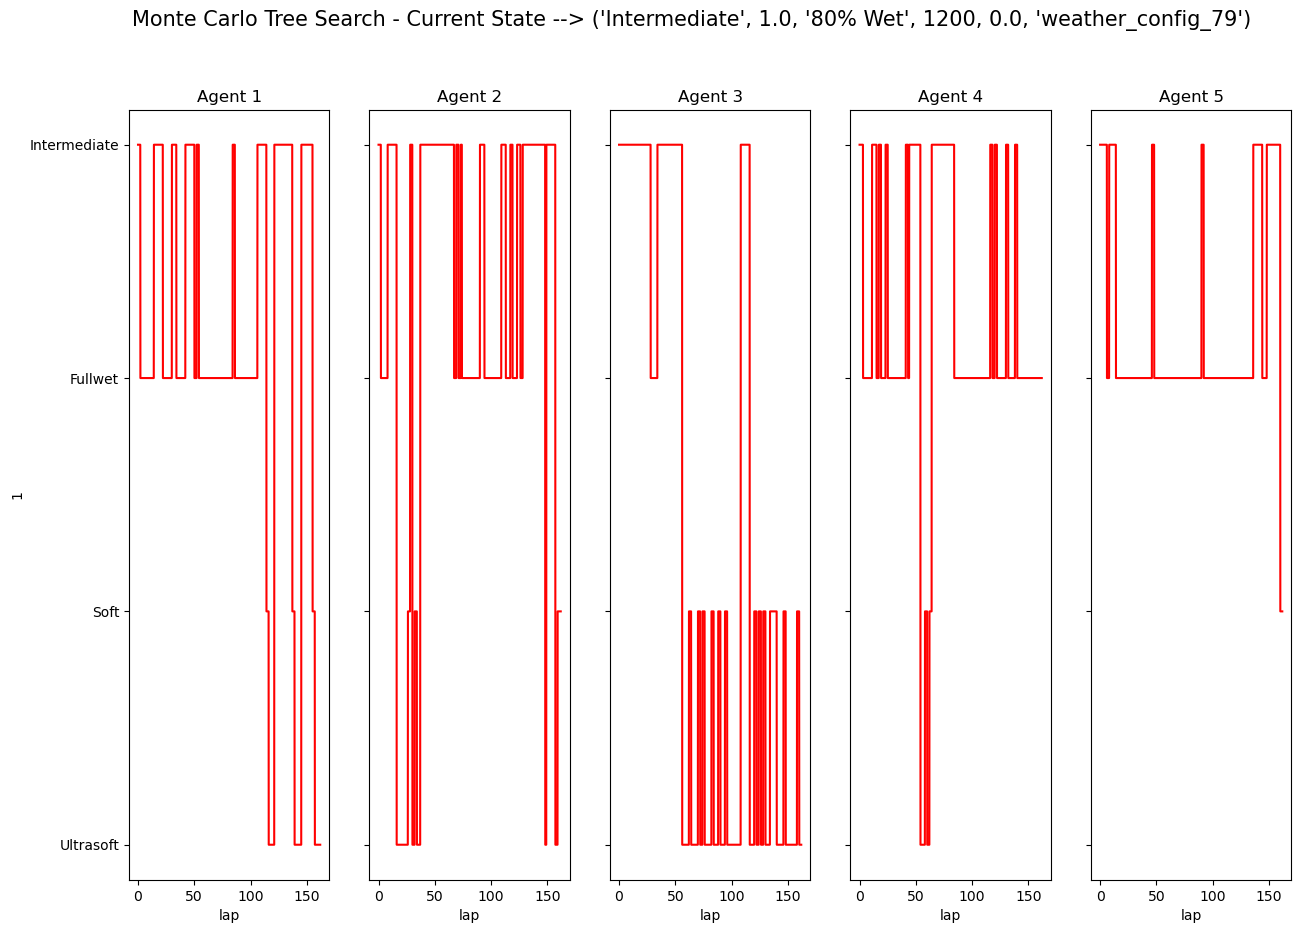

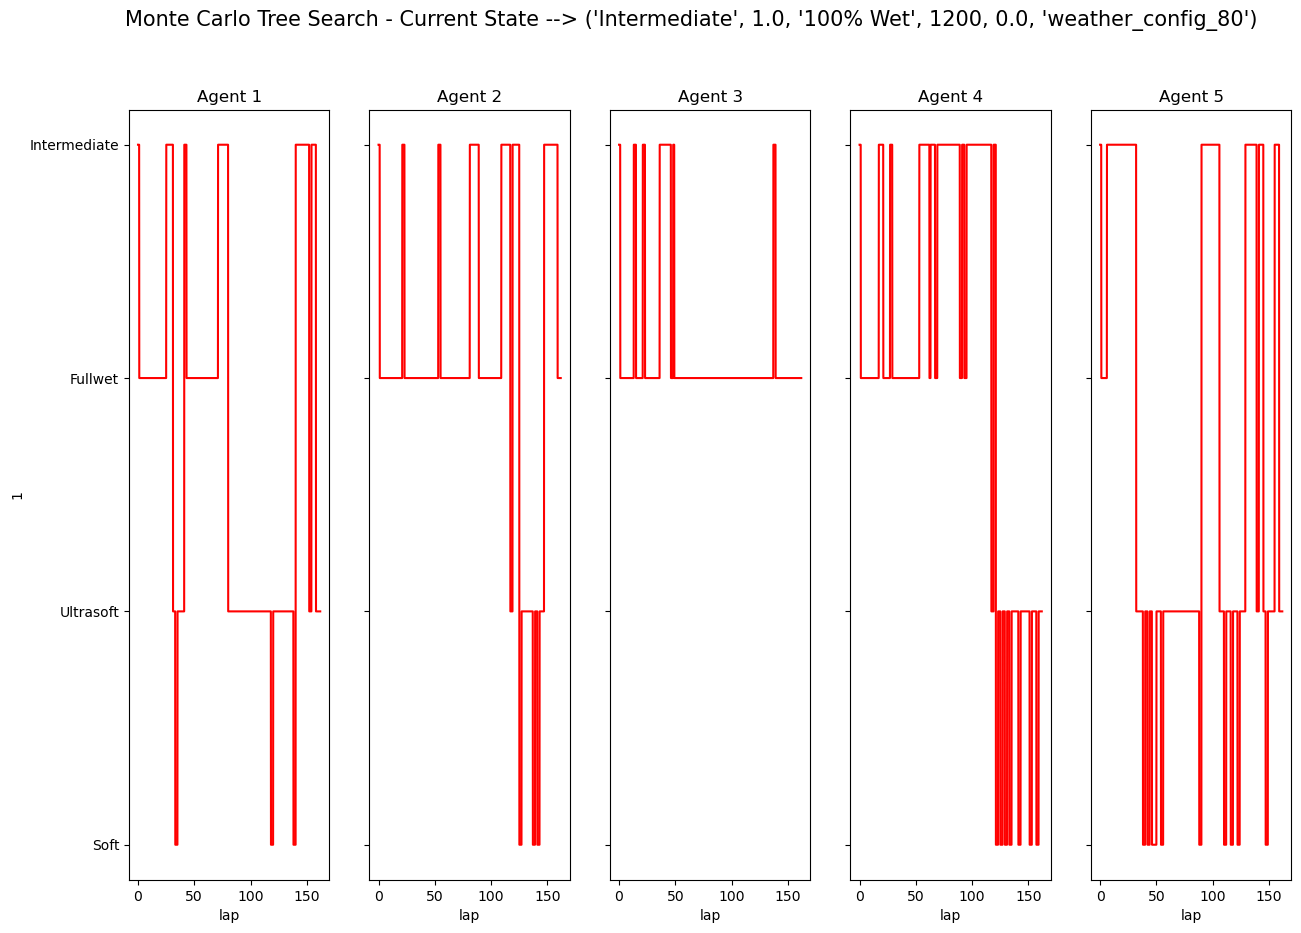

In [29]:
import seaborn as sns
lap_index = [i/8 for i in range(1296)]
agents_to_plot = [1,2,3,4,5]
for key, value in tyre_to_count_and_start_state_key.items():
  sample_df = pd.DataFrame.from_dict(value)
  sample_df["lap"] = lap_index
  
  # plot 
  fig, axes = plt.subplots(1, 5, figsize=(15, 10), sharey=True)
  for i, each in enumerate(agents_to_plot):
    sns.lineplot(data = sample_df, ax = axes[i], x = 'lap', y = each,errorbar=None, color = 'r').set(title=f"Agent {each}")
  fig.suptitle(f"Monte Carlo Tree Search - Current State --> {key}", fontsize=15)
  plt.show()

## Check Not just for Action 1 but Actions 0 to 4

In [30]:
# import json
# exp_state_time ={}

# # LOAD JSON
# f = open('evaluation_helper_file.json', "r")
# # Reading from file
# data = json.loads(f.read())
# print(f"LENGTH OF TEST DATA: {len(data)}")

# agent_action0 = Agent0()
# agent_action1 = Agent1()
# agent_action2 = Agent2()
# agent_action3 = Agent3()
# agent_action4 = Agent4()

# count = 0

# # tyre to 
# tyre_to_count_and_start_state_key = {}

# # SINGLE ACTION
# for start_state_key, weather_seq in data.items():
#   if count >= -1:
#     #convert string tuple to tuple
#     start_state_key = start_state_key.replace("(", "")
#     start_state_key = start_state_key.replace(")", "")
#     start_state_key = start_state_key.split(",")
#     start_state_key[0] = start_state_key[0].replace("'", "")
#     start_state_key[2] = start_state_key[2].replace("'", "").lstrip()
#     start_state_key[5] = start_state_key[5].replace("'", "").lstrip()
#     start_state_key[0], start_state_key[1], start_state_key[2], start_state_key[3], start_state_key[4] =str(start_state_key[0]), float(start_state_key[1]), str(start_state_key[2]), int(start_state_key[3]), float(start_state_key[4])

#     print(start_state_key)
#     #set start weather and radius
#     start_weather, radius = str(start_state_key[2]), int(start_state_key[3])
    
#     #average time
#     return_collection_single_act_0 = []
    
#     # single action algorithm
#     for agent_action0 in [group1, group2]:
#         state = env.reset() 
#         env.cur_weather = start_weather   # assert common start weather
#         env.radius = radius               # assert common track radius
#         done = False
#         G = 0
#         i = 0
#         while not done:
#             env.cur_weather = str(weather_seq[i])   # assert weather transition
#             action = agent_action0.act(state)
#             reward, next_state, done, velocity = env.transition(action)
#             # added velocity for sanity check
#             state = deepcopy(next_state)
#             G += reward
#             i += 1
#         print("Single Action 0 G: %.2f" % G)
#         return_collection_single_act_0.append(G)
    
#     avg_one_act_returns_0 = sum(return_collection_single_act_0)/len(return_collection_single_act_0)
    
#     #stringify tuple to save to json
#     exp_state_time[str((str(start_state_key[0]), float(start_state_key[1]), 
#                     str(start_state_key[2]), int(start_state_key[3]), 
#                     float(start_state_key[4]), str(start_state_key[5])))] = {"SingleAction0": avg_one_act_returns_0}

#     #average time
#     return_collection_single_act_1 = []
    
#     # single action algorithm
#     for agent_action1 in [group1, group2]:
#         state = env.reset() 
#         env.cur_weather = start_weather   # assert common start weather
#         env.radius = radius               # assert common track radius
#         done = False
#         G = 0
#         i = 0
#         while not done:
#             env.cur_weather = str(weather_seq[i])   # assert weather transition
#             action = agent_action1.act(state)
#             reward, next_state, done, velocity = env.transition(action)
#             # added velocity for sanity check
#             state = deepcopy(next_state)
#             G += reward
#             i += 1
#         print("Single Action 1 G: %.2f" % G)
#         return_collection_single_act_1.append(G)
    
#     avg_one_act_returns_1 = sum(return_collection_single_act_1)/len(return_collection_single_act_1)
    
#     #stringify tuple to save to json
#     exp_state_time[str((str(start_state_key[0]), float(start_state_key[1]), 
#                     str(start_state_key[2]), int(start_state_key[3]), 
#                     float(start_state_key[4]), str(start_state_key[5])))]['SingleAction1'] = avg_one_act_returns_1    

#     #average time
#     return_collection_single_act_2 = []

#     # single action algorithm
#     for agent_action2 in [group1, group2]:
#         state = env.reset() 
#         env.cur_weather = start_weather   # assert common start weather
#         env.radius = radius               # assert common track radius
#         done = False
#         G = 0
#         i = 0
#         while not done:
#             env.cur_weather = str(weather_seq[i])   # assert weather transition
#             action = agent_action2.act(state)
#             reward, next_state, done, velocity = env.transition(action)
#             # added velocity for sanity check
#             state = deepcopy(next_state)
#             G += reward
#             i += 1
#         print("Single Action 2 G: %.2f" % G)
#         return_collection_single_act_2.append(G)
    
#     avg_one_act_returns_2 = sum(return_collection_single_act_2)/len(return_collection_single_act_2)
    
#     #stringify tuple to save to json
#     exp_state_time[str((str(start_state_key[0]), float(start_state_key[1]), 
#                     str(start_state_key[2]), int(start_state_key[3]), 
#                     float(start_state_key[4]), str(start_state_key[5])))]['SingleAction2'] = avg_one_act_returns_2       

#     #average time
#     return_collection_single_act_3 = []

#     # single action algorithm
#     for agent_action3 in [group1, group2]:
#         state = env.reset() 
#         env.cur_weather = start_weather   # assert common start weather
#         env.radius = radius               # assert common track radius
#         done = False
#         G = 0
#         i = 0
#         while not done:
#             env.cur_weather = str(weather_seq[i])   # assert weather transition
#             action = agent_action3.act(state)
#             reward, next_state, done, velocity = env.transition(action)
#             # added velocity for sanity check
#             state = deepcopy(next_state)
#             G += reward
#             i += 1
#         print("Single Action 3 G: %.2f" % G)
#         return_collection_single_act_3.append(G)
    
#     avg_one_act_returns_3 = sum(return_collection_single_act_3)/len(return_collection_single_act_3)
    
#     #stringify tuple to save to json
#     exp_state_time[str((str(start_state_key[0]), float(start_state_key[1]), 
#                     str(start_state_key[2]), int(start_state_key[3]), 
#                     float(start_state_key[4]), str(start_state_key[5])))]['SingleAction3'] = avg_one_act_returns_3    

#     #average time
#     return_collection_single_act_4 = []

#     # single action algorithm
#     for agent_action4 in [group1, group2]:
#         state = env.reset() 
#         env.cur_weather = start_weather   # assert common start weather
#         env.radius = radius               # assert common track radius
#         done = False
#         G = 0
#         i = 0
#         while not done:
#             env.cur_weather = str(weather_seq[i])   # assert weather transition
#             action = agent_action4.act(state)
#             reward, next_state, done, velocity = env.transition(action)
#             # added velocity for sanity check
#             state = deepcopy(next_state)
#             G += reward
#             i += 1
#         print("Single Action 4 G: %.2f" % G)
#         return_collection_single_act_4.append(G)
    
#     avg_one_act_returns_4 = sum(return_collection_single_act_4)/len(return_collection_single_act_4)
    
#     #stringify tuple to save to json
#     exp_state_time[str((str(start_state_key[0]), float(start_state_key[1]), 
#                     str(start_state_key[2]), int(start_state_key[3]), 
#                     float(start_state_key[4]), str(start_state_key[5])))]["SingleAction4"] = avg_one_act_returns   

#   count += 1

In [31]:
# with open("evaluation_results_for_eval_helper_file_mcts_q_learn.json", "w") as outfile: 
#   json.dump(exp_state_time, outfile, indent=4)

In [32]:
# # visualize results for Group's weather sequences
# import pandas as pd
# import json
# # LOAD JSON
# f = open('evaluation_results_for_eval_helper_file_mcts_q_learn.json', "r")
# # Reading from file
# eval_data = json.loads(f.read())

# df = pd.DataFrame.from_dict(eval_data,orient='index')

# #to csv
# df.to_csv('eval_data_for_helper_file.csv')

## Evaluate improvement over Single Action

In [34]:
get_all_differences = []
for k, v in exp_state_time.items():
  for k1, v1 in v.items():
    if k1 == "Difference":
      get_all_differences.append(v1)
print(get_all_differences)

[-1030.690726830282, -987.4623230047418, -925.6619723559234, -922.5122268915857, -865.8564699469152, -836.041362394164, -861.9207587175297, -783.001398056198, -768.8501839780147, -784.1395492257179, -768.5828157565084, -759.7750093464165, -724.0802206210683, -1017.6110899566229, -970.009093811499, -906.9822929578277, -880.1448435676302, -838.1050497139695, -825.8381967592268, -783.7335150654799, -754.3769016607821, -736.06475921116, -725.4596250686955, -694.1010965857677, -729.481102604539, -701.1069384910807, -1017.0845260887436, -975.7401352664874, -947.662148157091, -890.7711674584389, -875.6891619839953, -849.9027473571059, -812.5972190382399, -810.0534184647295, -787.3292459144068, -789.5414110149286, -754.5911803507806, -745.5884132131032, -710.2429122413887, -929.2469192794342, -939.3105965323412, -934.0808056361839, -1010.274120218759, -1015.2604996180162, -1080.2168053818496, -851.6167269824964, -892.2632519226681, -938.7391417925828, -872.4027357299183, -1006.2293854587097, -

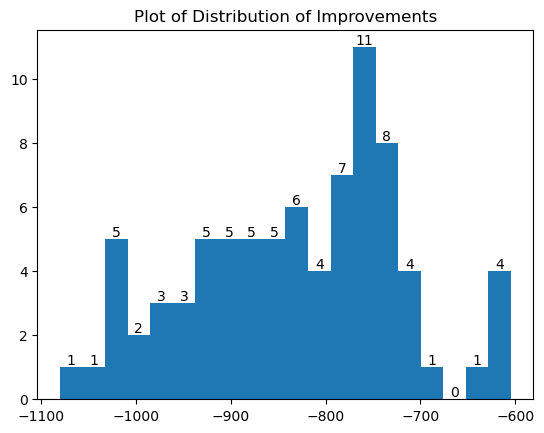

In [47]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(get_all_differences, bins =20)
plt.bar_label(patches)
plt.title("Plot of Distribution of Improvements")
plt.show()


In [48]:
df_describe = pd.DataFrame(get_all_differences)
df_describe.describe()

0
count    81.000000
mean   -830.525079
std     109.890237
min   -1080.216805
25%    -906.982293
50%    -825.331788
75%    -754.376902
max    -604.513900